In [24]:
#blah blah blah

In [2]:
#notes
#256, 256 images will run with batchsize 32, sometimes 64
#GPU memory gets eaten up when loading pre-trained nets
#We shoudl look at tfrecords instead of flow from directory
#Maybe try cudnnltsm.  or not because who wants to make eevrything thread safe
#Look at the Cuda section of GPU on task manager; try to get it running higher
#found this.  looks liek someone tried somthing similar https://stackoverflow.com/questions/57852043/keras-conditional-passing-one-model-output-to-another-model


In [1]:
#Libraries

#https://www.tensorflow.org/tutorials/images/cnn

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns 
from tensorflow import keras
from collections import Counter
from numba import cuda 



from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Rescaling
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.applications.mobilenet_v2 import MobileNetV2  
from keras.applications.vgg19 import VGG19, preprocess_input 
from keras.callbacks import BackupAndRestore, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import class_weight 

import matplotlib.pyplot as plt
import splitfolders
from itertools import chain

In [2]:
#!pip install tensorflow

#https://www.tensorflow.org/guide/gpu
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

print("If this outputs the matrix, then the GPU is working")
#https://stackoverflow.com/questions/58289983/low-nvidia-gpu-usage-with-keras-and-tensorflow?rq=1
with tf.device('/gpu:0'):
    with tf.compat.v1.Session() as sess:
        a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
        b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
        c = tf.matmul(a, b)
        print (sess.run(c))

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16834154195344411445
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1385247131
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9211272848633811277
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
Default GPU Device: /device:GPU:0
If this outputs the matrix, then the GPU is working
[[22. 28.]
 [49. 64.]]


In [40]:
#Flushes GPU memoryview
device = cuda.get_current_device()
device.reset()

In [3]:
#Splits off a holdout set, which is only used for evaluating trained models
#SAVE THIS FOR EMERGENCIES (aka if your computer dies, you can re-create the dataset as is.  this isnt on one-drive)
#splitfolders.ratio(r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Data\Plant Village\archive\plantvillage dataset\color", output="output", seed=28, ratio=(0.9, 0.1), group_prefix=None) # default values

Copying files: 54305 files [48:31, 18.65 files/s] 


Found 5417 images belonging to 1 classes.
(1, 256, 256, 3)


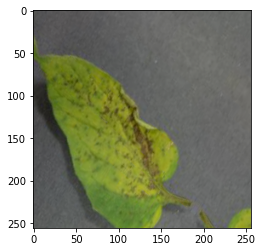

(1, 256, 256, 3)


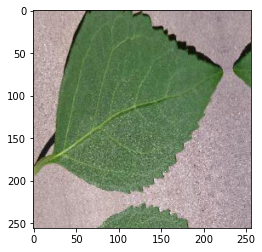

(1, 256, 256, 3)


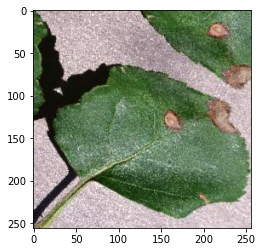

(1, 256, 256, 3)


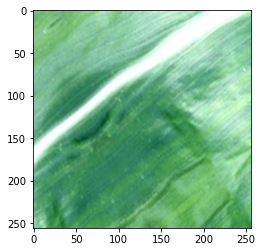

(1, 256, 256, 3)


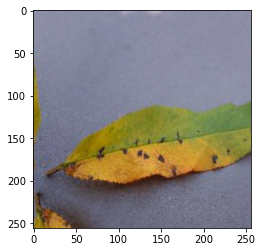

(1, 256, 256, 3)


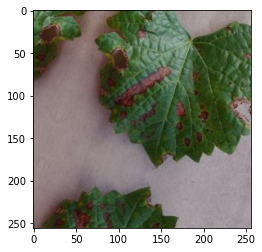

(1, 256, 256, 3)


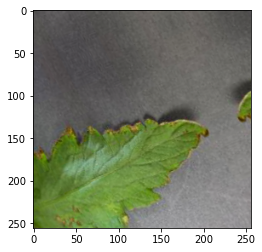

(1, 256, 256, 3)


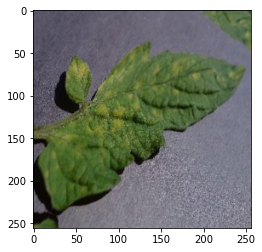

(1, 256, 256, 3)


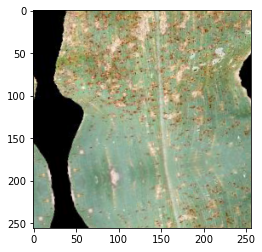

(1, 256, 256, 3)


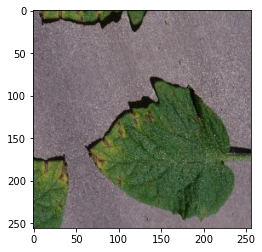

In [3]:
#https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
#for testing purposes


datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.3,
        height_shift_range=0.3,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        brightness_range = (0.6,1.3),
        horizontal_flip=True,
        fill_mode='reflect',
        validation_split=0.22222)

example_flow = datagen.flow_from_directory(
    directory = r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Data\Plant Village\All\test",
    batch_size = 1)

#https://stackoverflow.com/questions/63355107/keras-imagedatagenerator-result-display-flow
for _ in range(10):
    img, label = example_flow.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

In [4]:
#Stick EDA here

#Class counts
#https://stackoverflow.com/questions/65632501/keras-flow-from-directory-how-to-get-number-of-samples-in-each-category

imflow = ImageDataGenerator(rescale = 1./255).flow_from_directory(r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Data\Plant Village\Apples\train")
counter = Counter(imflow.classes)  

print(counter.items())

Found 2852 images belonging to 4 classes.
dict_items([(0, 567), (1, 558), (2, 247), (3, 1480)])


For apple Class 0, 1, 2, 3 are respectively: apple scab, black rot, apple rust, and healthy

Our dataset is somewhat imbalanced, with about 3x healthy and 1/2x apple rust images compared to black rot and apple scab.

In [ ]:
#Model evaluation
image = 




## Apple Modle 1 (Plant Village Apple Only)

In [13]:
def AMod1_create():
    #Apple model 1
    #This is mostly copy paste from a tutorial, link below:
    #https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
    
    ########################################################################################
    #First, define the model structure
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(256, 256, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())  
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4))
    model.add(Activation('softmax')) #Sigmoid is supposed to be better for multilabel or binary classification, but we'll try it anyway (is in the tutorial I was looking at)

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    
    #######################################################################################
    #Took some code from link below
    #https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
    
    #batches of 32 images @ 256^2 pixels seems to work well with my gpu. About twice as fast as running on cpu
    batchsize = 32

    #Specifies the range of augmentation for all images (preprocessing)
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.4,
        horizontal_flip=True,
        fill_mode='reflect',
        validation_split=0.22222)

    #Sets the training data generator
    train_generator = datagen.flow_from_directory(
        directory = r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Data\Plant Village\Apples\train",
        target_size = (256,256),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "training")


    #Sets the validation data generator
    val_generator = datagen.flow_from_directory(
        directory = r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Data\Plant Village\Apples\train",
        target_size = (256,256),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "validation")

    ################################################################33
    #This fits the model 
    
    model.fit(
        train_generator,
        steps_per_epoch=np.ceil(train_generator.samples // batchsize),
        epochs=25,
        validation_data=val_generator,
        validation_steps=np.ceil(val_generator.samples // batchsize))
    
    #Saves it
    model.save_weights('Apple_1_Weights.h5')  
    model.save('Apple_1_Model.h5')  
    
    return model

In [14]:
#Loss: 0.1344 Accuracy: 0.9373
#Some missclassification of apple scab as healthy
AMod1 = AMod1_create()

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\blume\\OneDrive\\Desktop\\CUNY MSDS\\Data 698 Masters Thesis\\Data\\Plant Village\\Apples\\train'

In [76]:
#Evaluate on the test set
testmodel = keras.models.load_model(r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Apple_1_Model.h5')

testdata = ImageDataGenerator(rescale=1./255)

testgen = testdata.flow_from_directory(
    directory = r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Data\Plant Village\Apples\test",
    target_size = (256,256),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = False)

metrics = tf.keras.models.Model.evaluate(testmodel,
                  testgen)

print("Loss: " + str(round(metrics[0],4)), "Accuracy: " + str(round(metrics[1],4)))

#https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = testmodel.predict(testgen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(testgen.classes, y_pred))
print('Classification Report')
target_names = testgen.class_indices.keys()
print(classification_report(testgen.classes, y_pred, target_names=target_names))

Found 319 images belonging to 4 classes.
10/10 [==============================] - 1s 74ms/step - loss: 0.1344 - accuracy: 0.9373
Loss: 0.1344 Accuracy: 0.9373
Confusion Matrix
[[ 58   1   4   0]
 [  0  63   0   0]
 [  0   0  27   1]
 [ 13   0   1 151]]
Classification Report
                          precision    recall  f1-score   support

      Apple___Apple_scab       0.82      0.92      0.87        63
       Apple___Black_rot       0.98      1.00      0.99        63
Apple___Cedar_apple_rust       0.84      0.96      0.90        28
         Apple___healthy       0.99      0.92      0.95       165

                accuracy                           0.94       319
               macro avg       0.91      0.95      0.93       319
            weighted avg       0.94      0.94      0.94       319



## Apple Model 2 (Plant Village Apple Only)
#### Transfer Learning with MobileNetV2
#### MobileNet Weights are kept.  Top layer was relapled with two fully connected layers (aftr flattening)

In [104]:
def AMod2_create():
    #Apple model 2
    #
    #
    
    ########################################################################################
    #First, define the model structure
    
    model = Sequential()
    model.add(MobileNetV2(include_top = False, input_shape = (224,224,3)))  #Loads Mobilenet Layers, without the top layer

    model.get_layer("mobilenetv2_1.00_224").trainable = False  #We'll keep the weights from mobilenetV2
    model.add(Flatten())   #These next bits flatten the output from the mobilenet (without the top layer), and add add a couple dense layers which we train on the apple data
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dense(4))
    model.add(Activation("softmax"))  #Softmax for multiclass classification
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',   # I hear this one works well
                  metrics=['accuracy'])
    
    
    #######################################################################################
    #Took some code from link below
    #https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
    
    #batches of 32 images @ 256^2 pixels seems to work well with my gpu. About twice as fast as running on cpu
    batchsize = 32

    #Specifies the range of augmentation for all images (preprocessing)
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.3,
        height_shift_range=0.3,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        brightness_range = (0.6,1.3),
        horizontal_flip=True,
        fill_mode='reflect',
        validation_split=0.22222) #this ends up being about 20% of the entire dataset (we seperate testing prior to anything)

    #Sets the training data generator
    train_generator = datagen.flow_from_directory(
        directory = r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Data\Plant Village\Apples\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "training")


    #Sets the validation data generator
    val_generator = datagen.flow_from_directory(
        directory = r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Data\Plant Village\Apples\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "validation")

    ################################################################33
    #This fits the model 
    
    model.fit(
        train_generator,
        steps_per_epoch=np.ceil(train_generator.samples // batchsize),
        epochs=50,
        validation_data=val_generator,
        validation_steps=np.ceil(val_generator.samples // batchsize))
    
    #Saves it
    model.save_weights('Apple_2_Weights.h5')  
    model.save('Apple_2_Model.h5')  
    
    return model

In [103]:
#Loss: 0.0715 Accuracy: 0.9781
#Needed to downsize images to work with the pre-trained weights
AMod2 = AMod2_create()

Found 2222 images belonging to 4 classes.
Found 630 images belonging to 4 classes.
Epoch 1/50


ResourceExhaustedError:  OOM when allocating tensor with shape[64,96,112,112] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_26/mobilenetv2_1.00_224/block_1_expand_BN/FusedBatchNormV3 (defined at <ipython-input-102-76fa91918c25>:69) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_124136]

Function call stack:
train_function


In [74]:
#Evaluate on the test set
testmodel = keras.models.load_model(r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Apple_2_Model.h5')

testdata = ImageDataGenerator(rescale=1./255)

testgen = testdata.flow_from_directory(
    directory = r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Data\Plant Village\Apples\test",
    target_size = (224,224),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = False)

metrics = tf.keras.models.Model.evaluate(testmodel,
                  testgen)

print("Loss: " + str(round(metrics[0],4)), "Accuracy: " + str(round(metrics[1],4)))

#https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = testmodel.predict(testgen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(testgen.classes, y_pred))
print('Classification Report')
target_names = testgen.class_indices.keys()
print(classification_report(testgen.classes, y_pred, target_names=target_names))

Found 319 images belonging to 4 classes.
10/10 [==============================] - 2s 103ms/step - loss: 0.0715 - accuracy: 0.9781
Loss: 0.0715 Accuracy: 0.9781
Confusion Matrix
[[ 62   0   0   1]
 [  0  59   0   4]
 [  1   1  26   0]
 [  0   0   0 165]]
Classification Report
                          precision    recall  f1-score   support

      Apple___Apple_scab       0.98      0.98      0.98        63
       Apple___Black_rot       0.98      0.94      0.96        63
Apple___Cedar_apple_rust       1.00      0.93      0.96        28
         Apple___healthy       0.97      1.00      0.99       165

                accuracy                           0.98       319
               macro avg       0.98      0.96      0.97       319
            weighted avg       0.98      0.98      0.98       319



## Apple Model 3
#### Transfer Learning with VGG


In [ ]:

model = Sequential()
model.add(keras.layers.Lambda(preprocess_input, name='preprocessing', input_shape=(224, 224, 3))) #VGG needs special pre-processsing, done in this layer.  Found this @ https://stackoverflow.com/questions/50547382/cant-use-preprocess-input-as-preprocessing-function-in-imagedatagenerator-in-ke
model.add(VGG19(include_top = False, input_shape=(224, 224, 3)))  #Loads VGG19 Layers, without the top layer

model.get_layer("vgg19").trainable = False  #We'll keep the weights from VGG19
model.add(Flatten())   #These next bits flatten the output from the mobilenet (without the top layer), and add add a couple dense layers which we train on the apple data
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dense(4))
model.add(Activation("Softmax"))  #Softmax for multiclass classification

model.compile(loss='categorical_crossentropy',
              optimizer='Adam',   # I hear this one works well
              metrics=['accuracy'])

    
model.summary()

In [5]:
def AMod3_create():
    #Apple model 3
    #
    #
    
    ########################################################################################
    #First, define the model structure
    
    model = Sequential()
    #Not sure this layer is helping; wont converge with it
    #model.add(keras.layers.Lambda(preprocess_input, name='preprocessing', input_shape=(224, 224, 3))) #VGG needs special pre-processsing, done in this layer.  Found this @ https://stackoverflow.com/questions/50547382/cant-use-preprocess-input-as-preprocessing-function-in-imagedatagenerator-in-ke
    model.add(VGG19(include_top = False, input_shape=(224, 224, 3)))  #Loads VGG19 Layers, without the top layer

    model.get_layer("vgg19").trainable = False  #We'll keep the weights from VGG19
    model.add(Flatten())   #These next bits flatten the output from the mobilenet (without the top layer), and add add a couple dense layers which we train on the apple data
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dense(4))
    model.add(Activation("Softmax"))  #Softmax for multiclass classification
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',   # I hear this one works well
                  metrics=['accuracy'])
    
    
    #######################################################################################
    #Took some code from link below
    #https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
    
    #batches of 32 images @ 256^2 pixels seems to work well with my gpu. About twice as fast as running on cpu
    batchsize = 32

    #Specifies the range of augmentation for all images (preprocessing)
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.3,
        height_shift_range=0.3,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        brightness_range = (0.6,1.3),
        horizontal_flip=True,
        fill_mode='reflect',
        validation_split=0.22222) #this ends up being about 20% of the entire dataset (we seperate testing prior to anything)

    #Sets the training data generator
    train_generator = datagen.flow_from_directory(
        directory = r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Data\Plant Village\Apples\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "training")


    #Sets the validation data generator
    val_generator = datagen.flow_from_directory(
        directory = r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Data\Plant Village\Apples\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "validation")

   
    ################################################################
    #This sets up the training schedule 
    
    #Add some callbacks to aid in training
    callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.0001), #Reduces the learning rate if no improvements are made.  Hopefully make for a more accurate model
                BackupAndRestore(r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\TrainingBackup") #Make backups, just incase
                ]
    
    #Fits the model
    model.fit(
        train_generator,
        steps_per_epoch=np.ceil(train_generator.samples / batchsize),
        epochs=20,
        validation_data=val_generator,
        validation_steps=np.ceil(val_generator.samples / batchsize),
        callbacks = callbacks)
    
    #Saves it
    model.save_weights('Apple_3_Weights.h5')  
    model.save('Apple_3_Model.h5')  
    
    return model

In [6]:
#Apple Model 3
#Needed to downsize images to work with the pre-trained weights
#Added a some callbacks
#This is a bigger model
#Loss: 0.1685 Accuracy: 0.9342

AMod3 = AMod3_create()

Found 2222 images belonging to 4 classes.
Found 630 images belonging to 4 classes.
Epoch 1/200
69/69 [==============================] - 56s 649ms/step - loss: 0.9342 - accuracy: 0.6607 - val_loss: 0.5082 - val_accuracy: 0.8092
Epoch 2/200
69/69 [==============================] - 40s 588ms/step - loss: 0.4711 - accuracy: 0.8320 - val_loss: 0.4520 - val_accuracy: 0.8520
Epoch 3/200
69/69 [==============================] - 40s 577ms/step - loss: 0.4612 - accuracy: 0.8183 - val_loss: 0.5150 - val_accuracy: 0.8191
Epoch 4/200
69/69 [==============================] - 41s 587ms/step - loss: 0.4041 - accuracy: 0.8530 - val_loss: 0.3046 - val_accuracy: 0.8931
Epoch 5/200
69/69 [==============================] - 40s 570ms/step - loss: 0.3591 - accuracy: 0.8694 - val_loss: 0.3072 - val_accuracy: 0.8832
Epoch 6/200
69/69 [==============================] - 42s 603ms/step - loss: 0.3439 - accuracy: 0.8731 - val_loss: 0.3257 - val_accuracy: 0.8734
Epoch 7/200
69/69 [==============================] - 

In [7]:
#Evaluate on the test set
testmodel = keras.models.load_model(r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Apple_3_Model.h5')

testdata = ImageDataGenerator(rescale=1./255)

testgen = testdata.flow_from_directory(
    directory = r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Data\Plant Village\Apples\test",
    target_size = (224,224),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = False)

metrics = tf.keras.models.Model.evaluate(testmodel,
                  testgen)

print("Loss: " + str(round(metrics[0],4)), "Accuracy: " + str(round(metrics[1],4)))

#https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = testmodel.predict(testgen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(testgen.classes, y_pred))
print('Classification Report')
target_names = testgen.class_indices.keys()
print(classification_report(testgen.classes, y_pred, target_names=target_names))

Found 319 images belonging to 4 classes.
10/10 [==============================] - 15s 1s/step - loss: 0.1685 - accuracy: 0.9342
Loss: 0.1685 Accuracy: 0.9342
Confusion Matrix
[[ 46   2   0  15]
 [  0  62   0   1]
 [  0   0  25   3]
 [  0   0   0 165]]
Classification Report
                          precision    recall  f1-score   support

      Apple___Apple_scab       1.00      0.73      0.84        63
       Apple___Black_rot       0.97      0.98      0.98        63
Apple___Cedar_apple_rust       1.00      0.89      0.94        28
         Apple___healthy       0.90      1.00      0.95       165

                accuracy                           0.93       319
               macro avg       0.97      0.90      0.93       319
            weighted avg       0.94      0.93      0.93       319



## Apple Model 4

In [28]:
def AMod4_create():
    #Apple model 4
    #
    #
    
    ########################################################################################
    #First, define the model structure
    
    model = Sequential()
    model.add(MobileNetV2(include_top = False, input_shape = (224,224,3)))  #Loads Mobilenet Layers, without the top layer
    model.get_layer("mobilenetv2_1.00_224").trainable = False  #We'll keep the weights from mobilenetV2
    
    model.add(Flatten())   #These next bits flatten the output from the mobilenet (without the top layer), and add add a couple dense layers which we train on the apple data
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dense(4))
    model.add(Activation("softmax"))  #Softmax for multiclass classification
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',   # I hear this one works well
                  metrics=['accuracy'])
    
    
    #######################################################################################
    #Took some code from link below
    #https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
    
    #batches of 32 images @ 256^2 pixels seems to work well with my gpu. About twice as fast as running on cpu
    batchsize = 32

    #Specifies the range of augmentation for all images (preprocessing)
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.3,
        height_shift_range=0.3,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        brightness_range = (0.6,1.3),
        horizontal_flip=True,
        fill_mode='reflect',
        validation_split=0.22222) #this ends up being about 20% of the entire dataset (we seperate testing prior to anything)

    #Sets the training data generator
    train_generator = datagen.flow_from_directory(
        directory = r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Data\Plant Village\Apples\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "training")


    #Sets the validation data generator
    val_generator = datagen.flow_from_directory(
        directory = r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Data\Plant Village\Apples\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "validation")

    ################################################################33
    #This fits the model 
    
    callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001, verbose = 1) #Reduces the learning rate if no improvements are made.  Hopefully make for a more accurate model
                ]
    
    model.fit(
        train_generator,
        steps_per_epoch=np.ceil(train_generator.samples / batchsize),
        epochs=20,
        validation_data=val_generator,
        validation_steps=np.ceil(val_generator.samples / batchsize),
        callbacks = callbacks
        )

    #Saves it
    model.save_weights('Apple_4_Weights.h5')  
    model.save('Apple_4_Model.h5')  
    
    return model

In [29]:
#0.0301 Accuracy: 0.9906
AMod4 = AMod4_create()

Found 2222 images belonging to 4 classes.
Found 630 images belonging to 4 classes.
Epoch 1/20
70/70 [==============================] - 42s 580ms/step - loss: 1.7583 - accuracy: 0.7795 - val_loss: 0.3585 - val_accuracy: 0.8571
Epoch 2/20
70/70 [==============================] - 41s 583ms/step - loss: 0.3341 - accuracy: 0.8920 - val_loss: 0.4950 - val_accuracy: 0.8794
Epoch 3/20
70/70 [==============================] - 41s 592ms/step - loss: 0.2927 - accuracy: 0.9172 - val_loss: 0.1705 - val_accuracy: 0.9460
Epoch 4/20
70/70 [==============================] - 40s 576ms/step - loss: 0.2871 - accuracy: 0.9307 - val_loss: 0.3069 - val_accuracy: 0.9397
Epoch 5/20
70/70 [==============================] - 43s 613ms/step - loss: 0.2744 - accuracy: 0.9383 - val_loss: 0.2917 - val_accuracy: 0.9270

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/20
70/70 [==============================] - 45s 637ms/step - loss: 0.1941 - accuracy: 0.9505 - val_loss: 0.1854 -

In [30]:
#Evaluate on the test set
testmodel = keras.models.load_model(r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Apple_4_Model.h5')

testdata = ImageDataGenerator(rescale=1./255)

testgen = testdata.flow_from_directory(
    directory = r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Data\Plant Village\Apples\test",
    target_size = (224,224),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = False)

metrics = tf.keras.models.Model.evaluate(testmodel,
                  testgen)

print("Loss: " + str(round(metrics[0],4)), "Accuracy: " + str(round(metrics[1],4)))

#https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = testmodel.predict(testgen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(testgen.classes, y_pred))
print('Classification Report')
target_names = testgen.class_indices.keys()
print(classification_report(testgen.classes, y_pred, target_names=target_names))

Found 319 images belonging to 4 classes.
10/10 [==============================] - 2s 111ms/step - loss: 0.0301 - accuracy: 0.9906
Loss: 0.0301 Accuracy: 0.9906
Confusion Matrix
[[ 61   0   1   1]
 [  0  62   0   1]
 [  0   0  28   0]
 [  0   0   0 165]]
Classification Report
                          precision    recall  f1-score   support

      Apple___Apple_scab       1.00      0.97      0.98        63
       Apple___Black_rot       1.00      0.98      0.99        63
Apple___Cedar_apple_rust       0.97      1.00      0.98        28
         Apple___healthy       0.99      1.00      0.99       165

                accuracy                           0.99       319
               macro avg       0.99      0.99      0.99       319
            weighted avg       0.99      0.99      0.99       319



## Apple Model 5

In [3]:
def Apple5_create():
    #Apple model 5
    #
    #
    
    ########################################################################################
    #First, define the model structure
    
    model = Sequential()
    model.add(MobileNetV2(include_top = False, input_shape = (224,224,3)))  #Loads Mobilenet Layers, without the top layer

    model.get_layer("mobilenetv2_1.00_224").trainable = False  #We'll keep the weights from mobilenetV2
    model.add(Flatten())   #These next bits flatten the output from the mobilenet (without the top layer), and add add a couple dense layers which we train on the apple data
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(4))
    model.add(Activation("softmax"))  #Softmax for multiclass classification
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',   # I hear this one works well
                  metrics=['accuracy'])
    
    
    #######################################################################################
    #Took some code from link below
    #https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
    
    #batches of 32 images @ 256^2 pixels seems to work well with my gpu. About twice as fast as running on cpu
    batchsize = 32

    #Specifies the range of augmentation for all images (preprocessing)
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.3,
        height_shift_range=0.3,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        brightness_range = (0.6,1.3),
        horizontal_flip=True,
        fill_mode='reflect',
        validation_split=0.22222) #this ends up being about 20% of the entire dataset (we seperate testing prior to anything)

    #Sets the training data generator
    train_generator = datagen.flow_from_directory(
        directory = r"C:\Datasets\Plant Village\Apple\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "training")


    #Sets the validation data generator
    val_generator = datagen.flow_from_directory(
        directory = r"C:\Datasets\Plant Village\Apple\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "validation")
    
    
    #Get's class weights
    #https://stackoverflow.com/questions/41648129/balancing-an-imbalanced-dataset-with-keras-image-generator
    
    class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)

    train_class_weights = dict(enumerate(class_weights))
    

    
    ################################################################33
    #This fits the model 
    checkpoint_path = r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Apple" #path for checkpoints
    
    callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0, min_delta = 0.0002, verbose = 1), #Reduces the learning rate if no improvements are made.  Hopefully make for a more accurate model
                 ModelCheckpoint(filepath = checkpoint_path, monitor = "val_accuracy", verbose = 1, save_best_only = True, mode = "auto", save_freq = "epoch") #Saves the model when it performes best
                ] 
    
    model.fit(
        train_generator,
        steps_per_epoch=np.ceil(train_generator.samples / batchsize),
        epochs=35,
        validation_data=val_generator,
        validation_steps=np.ceil(val_generator.samples / batchsize),
        class_weight=train_class_weights,
        workers = 32,
        #use_multiprocessing = True,
        max_queue_size = 64,
        callbacks = callbacks
        
        )

    #Saves it
    model.save_weights('Apple_5_Weights.h5')  
    model.save('Apple_5_Model.h5')  
    
    return model

In [5]:
#0.0301 Accuracy: 0.9906
AppleMod5 = Apple5_create()

Found 2222 images belonging to 4 classes.
Found 630 images belonging to 4 classes.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0 1 2 3], y=[0 0 0 ... 3 3 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/35
70/70 [==============================] - 125s 382ms/step - loss: 0.5710 - accuracy: 0.8159 - val_loss: 0.2144 - val_accuracy: 0.9381

Epoch 00001: val_accuracy improved from -inf to 0.93810, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Apple


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Apple\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Apple\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/35
70/70 [==============================] - 31s 363ms/step - loss: 0.2429 - accuracy: 0.9172 - val_loss: 0.1578 - val_accuracy: 0.9444

Epoch 00002: val_accuracy improved from 0.93810 to 0.94444, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Apple


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Apple\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Apple\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/35
70/70 [==============================] - 32s 366ms/step - loss: 0.2021 - accuracy: 0.9226 - val_loss: 0.1398 - val_accuracy: 0.9571

Epoch 00003: val_accuracy improved from 0.94444 to 0.95714, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Apple


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Apple\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Apple\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/35
70/70 [==============================] - 31s 387ms/step - loss: 0.1846 - accuracy: 0.9433 - val_loss: 0.1717 - val_accuracy: 0.9349

Epoch 00004: val_accuracy did not improve from 0.95714
Epoch 5/35
70/70 [==============================] - 32s 353ms/step - loss: 0.1801 - accuracy: 0.9406 - val_loss: 0.2707 - val_accuracy: 0.9175

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00005: val_accuracy did not improve from 0.95714
Epoch 6/35
70/70 [==============================] - 31s 357ms/step - loss: 0.1353 - accuracy: 0.9491 - val_loss: 0.0954 - val_accuracy: 0.9635

Epoch 00006: val_accuracy improved from 0.95714 to 0.96349, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Apple


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Apple\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Apple\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/35
70/70 [==============================] - 31s 370ms/step - loss: 0.1341 - accuracy: 0.9545 - val_loss: 0.1046 - val_accuracy: 0.9683

Epoch 00007: val_accuracy improved from 0.96349 to 0.96825, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Apple


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Apple\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Apple\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/35
70/70 [==============================] - 36s 449ms/step - loss: 0.1287 - accuracy: 0.9550 - val_loss: 0.1102 - val_accuracy: 0.9603

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00008: val_accuracy did not improve from 0.96825
Epoch 9/35
70/70 [==============================] - 36s 404ms/step - loss: 0.1192 - accuracy: 0.9599 - val_loss: 0.1009 - val_accuracy: 0.9603

Epoch 00009: val_accuracy did not improve from 0.96825
Epoch 10/35
70/70 [==============================] - 29s 337ms/step - loss: 0.1147 - accuracy: 0.9590 - val_loss: 0.0615 - val_accuracy: 0.9810

Epoch 00010: val_accuracy improved from 0.96825 to 0.98095, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Apple


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Apple\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Apple\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/35
70/70 [==============================] - 34s 403ms/step - loss: 0.1105 - accuracy: 0.9604 - val_loss: 0.0943 - val_accuracy: 0.9587

Epoch 00011: val_accuracy did not improve from 0.98095
Epoch 12/35
70/70 [==============================] - 36s 434ms/step - loss: 0.0946 - accuracy: 0.9653 - val_loss: 0.0899 - val_accuracy: 0.9714

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00012: val_accuracy did not improve from 0.98095
Epoch 13/35
70/70 [==============================] - 33s 365ms/step - loss: 0.1100 - accuracy: 0.9676 - val_loss: 0.0801 - val_accuracy: 0.9746

Epoch 00013: val_accuracy did not improve from 0.98095
Epoch 14/35
70/70 [==============================] - 35s 391ms/step - loss: 0.1140 - accuracy: 0.9676 - val_loss: 0.0855 - val_accuracy: 0.9714

Epoch 00014: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00014: val_accuracy did not improve from 0.98095
Epoch 15/35
70/70 [====================

INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Apple\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Apple\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 19/35
70/70 [==============================] - 42s 512ms/step - loss: 0.0869 - accuracy: 0.9689 - val_loss: 0.1035 - val_accuracy: 0.9698

Epoch 00019: val_accuracy did not improve from 0.98413
Epoch 20/35
70/70 [==============================] - 40s 433ms/step - loss: 0.0882 - accuracy: 0.9712 - val_loss: 0.0648 - val_accuracy: 0.9810

Epoch 00020: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00020: val_accuracy did not improve from 0.98413
Epoch 21/35
70/70 [==============================] - 35s 397ms/step - loss: 0.0847 - accuracy: 0.9694 - val_loss: 0.0663 - val_accuracy: 0.9746

Epoch 00021: val_accuracy did not improve from 0.98413
Epoch 22/35
70/70 [==============================] - 39s 410ms/step - loss: 0.0796 - accuracy: 0.9680 - val_loss: 0.0696 - val_accuracy: 0.9778

Epoch 00022: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00022: val_accuracy did not improve from 0.98413
Epoch 23/35
70/70 [===================

INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Apple\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Apple\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 33/35
70/70 [==============================] - 42s 512ms/step - loss: 0.0855 - accuracy: 0.9725 - val_loss: 0.0880 - val_accuracy: 0.9683

Epoch 00033: val_accuracy did not improve from 0.98571
Epoch 34/35
70/70 [==============================] - 36s 418ms/step - loss: 0.0998 - accuracy: 0.9662 - val_loss: 0.0928 - val_accuracy: 0.9730

Epoch 00034: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 00034: val_accuracy did not improve from 0.98571
Epoch 35/35
70/70 [==============================] - 46s 529ms/step - loss: 0.0834 - accuracy: 0.9757 - val_loss: 0.0727 - val_accuracy: 0.9730

Epoch 00035: val_accuracy did not improve from 0.98571


In [10]:
#Evaluate on the test set
testmodel = keras.models.load_model(r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Apple1')

testdata = ImageDataGenerator(rescale=1./255)

testgen = testdata.flow_from_directory(
    directory = r"C:\Datasets\Plant Village\Apple\test",
    target_size = (224,224),
    batch_size = 16,
    class_mode = "categorical",
    shuffle = False)

metrics = tf.keras.models.Model.evaluate(testmodel,
                  testgen)

print("Loss: " + str(round(metrics[0],4)), "Accuracy: " + str(round(metrics[1],4)))

#https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = testmodel.predict(testgen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(testgen.classes, y_pred))
print('Classification Report')
target_names = testgen.class_indices.keys()
print(classification_report(testgen.classes, y_pred, target_names=target_names))

Found 319 images belonging to 4 classes.
20/20 [==============================] - 3s 82ms/step - loss: 0.0426 - accuracy: 0.9843
Loss: 0.0426 Accuracy: 0.9843
Confusion Matrix
[[ 61   2   0   0]
 [  0  61   0   2]
 [  0   0  28   0]
 [  1   0   0 164]]
Classification Report
                          precision    recall  f1-score   support

      Apple___Apple_scab       0.98      0.97      0.98        63
       Apple___Black_rot       0.97      0.97      0.97        63
Apple___Cedar_apple_rust       1.00      1.00      1.00        28
         Apple___healthy       0.99      0.99      0.99       165

                accuracy                           0.98       319
               macro avg       0.99      0.98      0.98       319
            weighted avg       0.98      0.98      0.98       319



## Peach Model 1

In [15]:
def PMod1_create():
    #Peaches model 1
    #Basically the same as apple 4
    #
    
    ########################################################################################
    #First, define the model structure
    
    model = Sequential()
    model.add(MobileNetV2(include_top = False, input_shape = (224,224,3)))  #Loads Mobilenet Layers, without the top layer

    model.get_layer("mobilenetv2_1.00_224").trainable = False  #We'll keep the weights from mobilenetV2
    model.add(Flatten())   #These next bits flatten the output from the mobilenet (without the top layer), and add add a couple dense layers which we train on the apple data
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dense(2))
    model.add(Activation("softmax"))  #Softmax for multiclass classification
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',   # I hear this one works well
                  metrics=['accuracy'])
    
    
    #######################################################################################
    #Took some code from link below
    #https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
    
    #batches of 32 images @ 256^2 pixels seems to work well with my gpu. About twice as fast as running on cpu
    batchsize = 32

    #Specifies the range of augmentation for all images (preprocessing)
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.3,
        height_shift_range=0.3,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        brightness_range = (0.6,1.3),
        horizontal_flip=True,
        fill_mode='reflect',
        validation_split=0.22222) #this ends up being about 20% of the entire dataset (we seperate testing prior to anything)

    #Sets the training data generator
    train_generator = datagen.flow_from_directory(
        directory = r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Data\Plant Village\Peaches\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "training")


    #Sets the validation data generator
    val_generator = datagen.flow_from_directory(
        directory = r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Data\Plant Village\Peaches\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "validation")

    ################################################################33
    #This fits the model 
    
    callbacks = [ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_lr=0.0001, verbose = 1) #Reduces the learning rate if no improvements are made.  Hopefully make for a more accurate model
                ]
    
    model.fit(
        train_generator,
        steps_per_epoch=np.ceil(train_generator.samples / batchsize),
        epochs=25,
        validation_data=val_generator,
        validation_steps=np.ceil(val_generator.samples / batchsize),
        callbacks = callbacks
        )

    #Saves it
    model.save_weights('Peach_1_Weights.h5')  
    model.save('Peach_1_Model.h5')  
    
    return model

In [16]:
#
PMod1 = PMod1_create()

Found 1861 images belonging to 2 classes.
Found 530 images belonging to 2 classes.
Epoch 1/25
59/59 [==============================] - 208s 3s/step - loss: 0.7446 - accuracy: 0.9146 - val_loss: 0.0533 - val_accuracy: 0.9792
Epoch 2/25
59/59 [==============================] - 33s 563ms/step - loss: 0.0462 - accuracy: 0.9844 - val_loss: 0.0291 - val_accuracy: 0.9906
Epoch 3/25
35/59 [================>.............] - ETA: 10s - loss: 0.0429 - accuracy: 0.9844

KeyboardInterrupt: 

In [108]:
#Evaluate on the test set
testmodel = keras.models.load_model(r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Peach_1_Model.h5')

testdata = ImageDataGenerator(rescale=1./255)

testgen = testdata.flow_from_directory(
    directory = r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Data\Plant Village\Peaches\test",
    target_size = (224,224),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = False)

metrics = tf.keras.models.Model.evaluate(testmodel,
                  testgen)

print("Loss: " + str(round(metrics[0],4)), "Accuracy: " + str(round(metrics[1],4)))

#https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = testmodel.predict(testgen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(testgen.classes, y_pred))
print('Classification Report')
target_names = testgen.class_indices.keys()
print(classification_report(testgen.classes, y_pred, target_names=target_names))

Found 266 images belonging to 2 classes.
9/9 [==============================] - 2s 97ms/step - loss: 0.0355 - accuracy: 0.9850
Loss: 0.0355 Accuracy: 0.985
Confusion Matrix
[[226   4]
 [  0  36]]
Classification Report
                        precision    recall  f1-score   support

Peach___Bacterial_spot       1.00      0.98      0.99       230
       Peach___healthy       0.90      1.00      0.95        36

              accuracy                           0.98       266
             macro avg       0.95      0.99      0.97       266
          weighted avg       0.99      0.98      0.99       266



## Cherry Model 1

In [4]:
def Cherry1_create():
    #Cherry  model 1
    #for after plant task classifier
    #
    
    ########################################################################################
    #First, define the model structure
    
    model = Sequential()
    model.add(MobileNetV2(include_top = False, input_shape = (224,224,3)))  #Loads Mobilenet Layers, without the top layer

    model.get_layer("mobilenetv2_1.00_224").trainable = False  #We'll keep the weights from mobilenetV2
    model.add(Flatten())   #These next bits flatten the output from the mobilenet (without the top layer), and add add a couple dense layers which we train on the apple data
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation("softmax"))  #Softmax for multiclass classification
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',   # I hear this one works well
                  metrics=['accuracy'])
    
    
    #######################################################################################
    #Took some code from link below
    #https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
    
    #batches of 32 images @ 256^2 pixels seems to work well with my gpu. About twice as fast as running on cpu
    batchsize = 32

    #Specifies the range of augmentation for all images (preprocessing)
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.3,
        height_shift_range=0.3,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        brightness_range = (0.6,1.3),
        horizontal_flip=True,
        fill_mode='reflect',
        validation_split=0.22222) #this ends up being about 20% of the entire dataset (we seperate testing prior to anything)

    #Sets the training data generator
    train_generator = datagen.flow_from_directory(
        directory = r"C:\Datasets\Plant Village\Cherry\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "training")


    #Sets the validation data generator
    val_generator = datagen.flow_from_directory(
        directory = r"C:\Datasets\Plant Village\Cherry\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "validation")
    
    
    #Get's class weights
    #https://stackoverflow.com/questions/41648129/balancing-an-imbalanced-dataset-with-keras-image-generator
    
    class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)

    train_class_weights = dict(enumerate(class_weights))
    

    
    ################################################################33
    #This fits the model 
    checkpoint_path = r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Cherry" #path for checkpoints
    
    callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0, min_delta = 0.0002, verbose = 1), #Reduces the learning rate if no improvements are made.  Hopefully make for a more accurate model
                 ModelCheckpoint(filepath = checkpoint_path, monitor = "val_accuracy", verbose = 1, save_best_only = True, mode = "auto", save_freq = "epoch") #Saves the model when it performes best
                ] 
    
    model.fit(
        train_generator,
        steps_per_epoch=np.ceil(train_generator.samples / batchsize),
        epochs=25,
        validation_data=val_generator,
        validation_steps=np.ceil(val_generator.samples / batchsize),
        class_weight=train_class_weights,
        workers = 32,
        #use_multiprocessing = True,
        max_queue_size = 64,
        callbacks = callbacks
        
        )

    #Saves it
    model.save_weights('Cherry_1_Weights.h5')  
    model.save('Cherry_1_Model.h5')  
    
    return model

In [6]:
#This one converges to 1.0 val accuracy fairly quickly.  I think these classes are highly distinguishable
CherryMod1 = Cherry1_create()

Found 1334 images belonging to 2 classes.
Found 380 images belonging to 2 classes.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/25
42/42 [==============================] - 429s 463ms/step - loss: 0.1256 - accuracy: 0.9618 - val_loss: 0.0235 - val_accuracy: 0.9921

Epoch 00001: val_accuracy improved from -inf to 0.99211, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Cherry


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Cherry\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Cherry\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
42/42 [==============================] - 24s 403ms/step - loss: 0.0218 - accuracy: 0.9918 - val_loss: 0.0066 - val_accuracy: 0.9974

Epoch 00002: val_accuracy improved from 0.99211 to 0.99737, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Cherry


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Cherry\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Cherry\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/25
42/42 [==============================] - 26s 455ms/step - loss: 0.0172 - accuracy: 0.9948 - val_loss: 0.0192 - val_accuracy: 0.9895

Epoch 00003: val_accuracy did not improve from 0.99737
Epoch 4/25
42/42 [==============================] - 25s 402ms/step - loss: 0.0167 - accuracy: 0.9940 - val_loss: 0.0150 - val_accuracy: 0.9921

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00004: val_accuracy did not improve from 0.99737
Epoch 5/25
42/42 [==============================] - 24s 431ms/step - loss: 0.0132 - accuracy: 0.9948 - val_loss: 0.0056 - val_accuracy: 0.9974

Epoch 00005: val_accuracy did not improve from 0.99737
Epoch 6/25
42/42 [==============================] - 24s 433ms/step - loss: 0.0086 - accuracy: 0.9978 - val_loss: 0.0164 - val_accuracy: 0.9974

Epoch 00006: val_accuracy did not improve from 0.99737
Epoch 7/25
42/42 [==============================] - 23s 394ms/step - loss: 0.0134 - accuracy: 0.9925 - val_loss: 0.0134 - v

INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Cherry\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Cherry\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/25
42/42 [==============================] - 23s 365ms/step - loss: 0.0041 - accuracy: 0.9993 - val_loss: 0.0041 - val_accuracy: 0.9974

Epoch 00009: val_accuracy did not improve from 1.00000
Epoch 10/25
42/42 [==============================] - 23s 377ms/step - loss: 0.0084 - accuracy: 0.9963 - val_loss: 0.0011 - val_accuracy: 1.0000

Epoch 00010: val_accuracy did not improve from 1.00000
Epoch 11/25
42/42 [==============================] - 24s 403ms/step - loss: 0.0056 - accuracy: 0.9985 - val_loss: 9.7087e-04 - val_accuracy: 1.0000

Epoch 00011: val_accuracy did not improve from 1.00000
Epoch 12/25
42/42 [==============================] - 23s 391ms/step - loss: 0.0072 - accuracy: 0.9970 - val_loss: 0.0173 - val_accuracy: 0.9974

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00012: val_accuracy did not improve from 1.00000
Epoch 13/25
42/42 [==============================] - 22s 393ms/step - loss: 0.0049 - accuracy: 0.9993 - val_loss: 0.

In [9]:
#Evaluate on the test set
testmodel = keras.models.load_model(r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Cherry_1_Model.h5')

testdata = ImageDataGenerator(rescale=1./255)

testgen = testdata.flow_from_directory(
    directory = r"C:\Datasets\Plant Village\Cherry\test",
    target_size = (224,224),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = False)

metrics = tf.keras.models.Model.evaluate(testmodel,
                  testgen)

print("Loss: " + str(round(metrics[0],4)), "Accuracy: " + str(round(metrics[1],4)))

#https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = testmodel.predict(testgen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(testgen.classes, y_pred))
print('Classification Report')
target_names = testgen.class_indices.keys()
print(classification_report(testgen.classes, y_pred, target_names=target_names))

Found 192 images belonging to 2 classes.
6/6 [==============================] - 2s 117ms/step - loss: 7.3734e-04 - accuracy: 1.0000
Loss: 0.0007 Accuracy: 1.0
Confusion Matrix
[[106   0]
 [  0  86]]
Classification Report
                                          precision    recall  f1-score   support

Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       106
       Cherry_(including_sour)___healthy       1.00      1.00      1.00        86

                                accuracy                           1.00       192
                               macro avg       1.00      1.00      1.00       192
                            weighted avg       1.00      1.00      1.00       192



## Combination Model 1
#### Here we'll train a model from scratch with both peaches an apples



In [119]:
def CombinationMod1_create():
    #Peaches model 1
    #Basically the same as apple 4
    #
    
    ########################################################################################
    #First, define the model structure
    
    model = Sequential()
    model.add(MobileNetV2(include_top = False, input_shape = (224,224,3)))  #Loads Mobilenet Layers, without the top layer

    model.get_layer("mobilenetv2_1.00_224").trainable = False  #We'll keep the weights from mobilenetV2
    model.add(Flatten())   #These next bits flatten the output from the mobilenet (without the top layer), and add add a couple dense layers which we train on the apple data
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dense(6))
    model.add(Activation("softmax"))  #Softmax for multiclass classification
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',   # I hear this one works well
                  metrics=['accuracy'])
    
    
    #######################################################################################
    #Took some code from link below
    #https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
    
    #batches of 32 images @ 256^2 pixels seems to work well with my gpu. About twice as fast as running on cpu
    batchsize = 32

    #Specifies the range of augmentation for all images (preprocessing)
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.3,
        height_shift_range=0.3,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        brightness_range = (0.6,1.3),
        horizontal_flip=True,
        fill_mode='reflect',
        validation_split=0.22222) #this ends up being about 20% of the entire dataset (we seperate testing prior to anything)

    #Sets the training data generator
    train_generator = datagen.flow_from_directory(
        directory = r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Data\Plant Village\Combination\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "training")


    #Sets the validation data generator
    val_generator = datagen.flow_from_directory(
        directory = r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Data\Plant Village\Combination\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "validation")

    ################################################################33
    #This fits the model 
    
    callbacks = [ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, min_lr=0.0001, verbose = 1) #Reduces the learning rate if no improvements are made.  Hopefully make for a more accurate model
                ]
    
    model.fit(
        train_generator,
        steps_per_epoch=np.ceil(train_generator.samples / batchsize),
        epochs=40,
        validation_data=val_generator,
        validation_steps=np.ceil(val_generator.samples / batchsize),
        callbacks = callbacks
        )

    #Saves it
    model.save_weights('Combination_1_Weights.h5')  
    model.save('Combination_1_Model.h5')  
    
    return model

In [120]:
#0.0748 Accuracy: 0.9778
CombinationMod1 = CombinationMod1_create()

Found 4083 images belonging to 6 classes.
Found 1160 images belonging to 6 classes.
Epoch 1/40
128/128 [==============================] - 93s 714ms/step - loss: 1.1095 - accuracy: 0.8014 - val_loss: 0.4364 - val_accuracy: 0.8957
Epoch 2/40
128/128 [==============================] - 84s 657ms/step - loss: 0.4610 - accuracy: 0.8751 - val_loss: 0.3725 - val_accuracy: 0.8974
Epoch 3/40
128/128 [==============================] - 81s 630ms/step - loss: 0.3929 - accuracy: 0.8920 - val_loss: 0.3293 - val_accuracy: 0.8888
Epoch 4/40
128/128 [==============================] - 80s 626ms/step - loss: 0.3394 - accuracy: 0.9138 - val_loss: 0.2651 - val_accuracy: 0.9362
Epoch 5/40
128/128 [==============================] - 81s 632ms/step - loss: 0.3386 - accuracy: 0.9153 - val_loss: 0.3773 - val_accuracy: 0.9155
Epoch 6/40
128/128 [==============================] - 81s 635ms/step - loss: 0.2955 - accuracy: 0.9204 - val_loss: 0.3115 - val_accuracy: 0.9129
Epoch 7/40
128/128 [==========================

In [122]:
#Evaluate on the test set
testmodel = keras.models.load_model(r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Combination_1_Model.h5')

testdata = ImageDataGenerator(rescale=1./255)

testgen = testdata.flow_from_directory(
    directory = r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Data\Plant Village\Combination\test",
    target_size = (224,224),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = False)

metrics = tf.keras.models.Model.evaluate(testmodel,
                  testgen)

print("Loss: " + str(round(metrics[0],4)), "Accuracy: " + str(round(metrics[1],4)))

#https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = testmodel.predict(testgen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(testgen.classes, y_pred))
print('Classification Report')
target_names = testgen.class_indices.keys()
print(classification_report(testgen.classes, y_pred, target_names=target_names))

Found 585 images belonging to 6 classes.
19/19 [==============================] - 3s 100ms/step - loss: 0.0748 - accuracy: 0.9778
Loss: 0.0748 Accuracy: 0.9778
Confusion Matrix
[[ 59   0   0   2   2   0]
 [  0  59   0   3   1   0]
 [  0   1  27   0   0   0]
 [  0   0   0 165   0   0]
 [  0   0   0   0 229   1]
 [  0   0   0   1   2  33]]
Classification Report
                          precision    recall  f1-score   support

      Apple___Apple_scab       1.00      0.94      0.97        63
       Apple___Black_rot       0.98      0.94      0.96        63
Apple___Cedar_apple_rust       1.00      0.96      0.98        28
         Apple___healthy       0.96      1.00      0.98       165
  Peach___Bacterial_spot       0.98      1.00      0.99       230
         Peach___healthy       0.97      0.92      0.94        36

                accuracy                           0.98       585
               macro avg       0.98      0.96      0.97       585
            weighted avg       0.98      0

## Combination Model 2
#### The one we'll actualy use

In [3]:
def Combination2_create():
    #Combination model 1
    #Would filter images before a disease classifier
    #
    
    ########################################################################################
    #First, define the model structure
    
    model = Sequential()
    model.add(MobileNetV2(include_top = False, input_shape = (224,224,3)))  #Loads Mobilenet Layers, without the top layer

    model.get_layer("mobilenetv2_1.00_224").trainable = False  #We'll keep the weights from mobilenetV2
    model.add(Flatten())   #These next bits flatten the output from the mobilenet (without the top layer), and add add a couple dense layers which we train on the apple data
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(8))
    model.add(Activation("softmax"))  #Softmax for multiclass classification
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',   # I hear this one works well
                  metrics=['accuracy'])
    
    
    #######################################################################################
    #Took some code from link below
    #https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
    
    #batches of 32 images @ 256^2 pixels seems to work well with my gpu. About twice as fast as running on cpu
    batchsize = 32

    #Specifies the range of augmentation for all images (preprocessing)
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.3,
        height_shift_range=0.3,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        brightness_range = (0.6,1.3),
        horizontal_flip=True,
        fill_mode='reflect',
        validation_split=0.22222) #this ends up being about 20% of the entire dataset (we seperate testing prior to anything)

    #Sets the training data generator
    train_generator = datagen.flow_from_directory(
        directory = r"C:\Datasets\Plant Village\Combination\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "training")


    #Sets the validation data generator
    val_generator = datagen.flow_from_directory(
        directory = r"C:\Datasets\Plant Village\Combination\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "validation")
    
    
    #Get's class weights
    #https://stackoverflow.com/questions/41648129/balancing-an-imbalanced-dataset-with-keras-image-generator
    
    class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)

    train_class_weights = dict(enumerate(class_weights))
    

    
    ################################################################33
    #This fits the model 
    checkpoint_path = r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Combination" #path for checkpoints
    
    callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0, min_delta = 0.0005, verbose = 1), #Reduces the learning rate if no improvements are made.  Hopefully make for a more accurate model
                 ModelCheckpoint(filepath = checkpoint_path, monitor = "val_accuracy", verbose = 1, save_best_only = True, mode = "auto", save_freq = "epoch") #Saves the model when it performes best
                ] 
    
    model.fit(
        train_generator,
        steps_per_epoch=np.ceil(train_generator.samples / batchsize),
        epochs=25,
        validation_data=val_generator,
        validation_steps=np.ceil(val_generator.samples / batchsize),
        class_weight=train_class_weights,
        workers = 32,
        #use_multiprocessing = True,
        max_queue_size = 64,
        callbacks = callbacks
        
        )

    #Saves it
    model.save_weights('Combination2_Weights.h5')  
    model.save('Combination2_Model.h5')  
    
    return model

In [4]:
Combination2_mod = Combination2_create()

Found 5417 images belonging to 8 classes.
Found 1540 images belonging to 8 classes.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0 1 2 3 4 5 6 7], y=[0 0 0 ... 7 7 7] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/25
170/170 [==============================] - 161s 462ms/step - loss: 0.5913 - accuracy: 0.8038 - val_loss: 0.1994 - val_accuracy: 0.9292

Epoch 00001: val_accuracy improved from -inf to 0.92922, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Combination


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Combination\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Combination\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
170/170 [==============================] - 57s 310ms/step - loss: 0.2752 - accuracy: 0.9011 - val_loss: 0.2573 - val_accuracy: 0.9117

Epoch 00002: val_accuracy did not improve from 0.92922
Epoch 3/25
170/170 [==============================] - 55s 298ms/step - loss: 0.2433 - accuracy: 0.9103 - val_loss: 0.1805 - val_accuracy: 0.9409

Epoch 00003: val_accuracy improved from 0.92922 to 0.94091, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Combination


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Combination\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Combination\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/25
170/170 [==============================] - 58s 311ms/step - loss: 0.2056 - accuracy: 0.9278 - val_loss: 0.1251 - val_accuracy: 0.9636

Epoch 00004: val_accuracy improved from 0.94091 to 0.96364, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Combination


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Combination\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Combination\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/25
170/170 [==============================] - 55s 289ms/step - loss: 0.2129 - accuracy: 0.9232 - val_loss: 0.2464 - val_accuracy: 0.9208

Epoch 00005: val_accuracy did not improve from 0.96364
Epoch 6/25
170/170 [==============================] - 54s 287ms/step - loss: 0.2013 - accuracy: 0.9287 - val_loss: 0.1929 - val_accuracy: 0.9286

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00006: val_accuracy did not improve from 0.96364
Epoch 7/25
170/170 [==============================] - 62s 313ms/step - loss: 0.1752 - accuracy: 0.9394 - val_loss: 0.1062 - val_accuracy: 0.9649

Epoch 00007: val_accuracy improved from 0.96364 to 0.96494, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Combination


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Combination\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Combination\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/25
170/170 [==============================] - 54s 294ms/step - loss: 0.1644 - accuracy: 0.9383 - val_loss: 0.1101 - val_accuracy: 0.9623

Epoch 00008: val_accuracy did not improve from 0.96494
Epoch 9/25
170/170 [==============================] - 58s 304ms/step - loss: 0.1632 - accuracy: 0.9413 - val_loss: 0.1378 - val_accuracy: 0.9565

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00009: val_accuracy did not improve from 0.96494
Epoch 10/25
170/170 [==============================] - 58s 310ms/step - loss: 0.1514 - accuracy: 0.9444 - val_loss: 0.1117 - val_accuracy: 0.9610

Epoch 00010: val_accuracy did not improve from 0.96494
Epoch 11/25
170/170 [==============================] - 66s 361ms/step - loss: 0.1408 - accuracy: 0.9468 - val_loss: 0.1068 - val_accuracy: 0.9682

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00011: val_accuracy improved from 0.96494 to 0.96818, saving model to C:\Users\bl

INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Combination\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Combination\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 12/25
170/170 [==============================] - 69s 367ms/step - loss: 0.1227 - accuracy: 0.9526 - val_loss: 0.1090 - val_accuracy: 0.9669

Epoch 00012: val_accuracy did not improve from 0.96818
Epoch 13/25
170/170 [==============================] - 66s 352ms/step - loss: 0.1291 - accuracy: 0.9516 - val_loss: 0.0996 - val_accuracy: 0.9669

Epoch 00013: val_accuracy did not improve from 0.96818
Epoch 14/25
170/170 [==============================] - 72s 391ms/step - loss: 0.1233 - accuracy: 0.9557 - val_loss: 0.1113 - val_accuracy: 0.9630

Epoch 00014: val_accuracy did not improve from 0.96818
Epoch 15/25
170/170 [==============================] - 72s 380ms/step - loss: 0.1316 - accuracy: 0.9514 - val_loss: 0.1002 - val_accuracy: 0.9675

Epoch 00015: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00015: val_accuracy did not improve from 0.96818
Epoch 16/25
170/170 [==============================] - 81s 444ms/step - loss: 0.1130 - accuracy: 0.9596 - val_lo

INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Combination\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Combination\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 20/25
170/170 [==============================] - 75s 408ms/step - loss: 0.1082 - accuracy: 0.9579 - val_loss: 0.0875 - val_accuracy: 0.9734

Epoch 00020: val_accuracy improved from 0.97273 to 0.97338, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Combination


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Combination\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Combination\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 21/25
170/170 [==============================] - 64s 343ms/step - loss: 0.1088 - accuracy: 0.9564 - val_loss: 0.0985 - val_accuracy: 0.9630

Epoch 00021: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00021: val_accuracy did not improve from 0.97338
Epoch 22/25
170/170 [==============================] - 61s 327ms/step - loss: 0.0975 - accuracy: 0.9644 - val_loss: 0.0739 - val_accuracy: 0.9766

Epoch 00022: val_accuracy improved from 0.97338 to 0.97662, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Combination


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Combination\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Combination\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 23/25
170/170 [==============================] - 67s 361ms/step - loss: 0.1029 - accuracy: 0.9629 - val_loss: 0.0849 - val_accuracy: 0.9734

Epoch 00023: val_accuracy did not improve from 0.97662
Epoch 24/25
170/170 [==============================] - 70s 348ms/step - loss: 0.1065 - accuracy: 0.9607 - val_loss: 0.0851 - val_accuracy: 0.9688

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00024: val_accuracy did not improve from 0.97662
Epoch 25/25
170/170 [==============================] - 68s 367ms/step - loss: 0.1027 - accuracy: 0.9644 - val_loss: 0.0842 - val_accuracy: 0.9708

Epoch 00025: val_accuracy did not improve from 0.97662


In [6]:
#Evaluate on the test set
testmodel = keras.models.load_model(r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Combination2')

testdata = ImageDataGenerator(rescale=1./255)

testgen = testdata.flow_from_directory(
    directory = r"C:\Datasets\Plant Village\ApplePeachCherryTest",
    target_size = (224,224),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = False)

metrics = tf.keras.models.Model.evaluate(testmodel,
                  testgen)

print("Loss: " + str(round(metrics[0],4)), "Accuracy: " + str(round(metrics[1],4)))

#https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = testmodel.predict(testgen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(testgen.classes, y_pred))
print('Classification Report')
target_names = testgen.class_indices.keys()
print(classification_report(testgen.classes, y_pred, target_names=target_names))

#Gets a confidence interval
z = 1.96 # 95%
accuracy = accuracy_score(testgen.classes, y_pred)
conf = z * ((accuracy * (1 - accuracy)) / 777)**0.5
print("Accuracy: " + str(round(accuracy,3)))
print("95% CI: " + str(round(accuracy  - conf, 3)) + " - " + str(round(accuracy  + conf, 3)))

Found 777 images belonging to 8 classes.
25/25 [==============================] - 39s 2s/step - loss: 0.0645 - accuracy: 0.9743
Loss: 0.0645 Accuracy: 0.9743
Confusion Matrix
[[ 59   2   0   1   0   0   1   0]
 [  0  63   0   0   0   0   0   0]
 [  1   0  27   0   0   0   0   0]
 [  1   0   0 163   0   1   0   0]
 [  2   0   0   1 102   0   1   0]
 [  0   1   0   0   0  85   0   0]
 [  0   0   0   0   0   0 223   7]
 [  0   0   0   1   0   0   0  35]]
Classification Report
                                          precision    recall  f1-score   support

                      Apple___Apple_scab       0.94      0.94      0.94        63
                       Apple___Black_rot       0.95      1.00      0.98        63
                Apple___Cedar_apple_rust       1.00      0.96      0.98        28
                         Apple___healthy       0.98      0.99      0.98       165
Cherry_(including_sour)___Powdery_mildew       1.00      0.96      0.98       106
       Cherry_(including_sour

# Type 2 Inclusive
## Peach-Other Model 

This model is designed to sit before a peach classification model.  This will detect whether the image is of a pach leaf, or somthing else (binary).

In [4]:
def PeachesOther_create():
    #PeachesOther model 1
    #Would filter images before a disease classifier
    #
    
    ########################################################################################
    #First, define the model structure
    
    model = Sequential()
    model.add(MobileNetV2(include_top = False, input_shape = (224,224,3)))  #Loads Mobilenet Layers, without the top layer

    model.get_layer("mobilenetv2_1.00_224").trainable = False  #We'll keep the weights from mobilenetV2
    model.add(Flatten())   #These next bits flatten the output from the mobilenet (without the top layer), and add add a couple dense layers which we train on the apple data
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dense(2))
    model.add(Activation("softmax"))  #Softmax for multiclass classification
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',   # I hear this one works well
                  metrics=['accuracy'])
    
    
    #######################################################################################
    #Took some code from link below
    #https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
    
    #batches of 32 images @ 256^2 pixels seems to work well with my gpu. About twice as fast as running on cpu
    batchsize = 32

    #Specifies the range of augmentation for all images (preprocessing)
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.3,
        height_shift_range=0.3,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        brightness_range = (0.6,1.3),
        horizontal_flip=True,
        fill_mode='reflect',
        validation_split=0.22222) #this ends up being about 20% of the entire dataset (we seperate testing prior to anything)

    #Sets the training data generator
    train_generator = datagen.flow_from_directory(
        directory = r"C:\Datasets\Plant Village\PeachesOther\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "training")


    #Sets the validation data generator
    val_generator = datagen.flow_from_directory(
        directory = r"C:\Datasets\Plant Village\PeachesOther\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "validation")
    
    
    #Get's class weights
    #https://stackoverflow.com/questions/41648129/balancing-an-imbalanced-dataset-with-keras-image-generator
    
    class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)

    train_class_weights = dict(enumerate(class_weights))
    

    
    ################################################################33
    #This fits the model 
    checkpoint_path = r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachesOther" #path for checkpoints
    
    callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0, min_delta = 0.0005, verbose = 1), #Reduces the learning rate if no improvements are made.  Hopefully make for a more accurate model
                 ModelCheckpoint(filepath = checkpoint_path, monitor = "val_accuracy", verbose = 1, save_best_only = True, mode = "auto", save_freq = "epoch") #Saves the model when it performes best
                ] 
    
    model.fit(
        train_generator,
        steps_per_epoch=np.ceil(train_generator.samples / batchsize),
        epochs=25,
        validation_data=val_generator,
        validation_steps=np.ceil(val_generator.samples / batchsize),
        class_weight=train_class_weights,
        workers = 32,
        #use_multiprocessing = True,
        max_queue_size = 64,
        callbacks = callbacks
        
        )

    #Saves it
    model.save_weights('PeachesOther_Weights.h5')  
    model.save('PeachesOther_Model.h5')  
    
    return model

In [5]:
#
#
PeachesOtherMod = PeachesOther_create()

Found 38001 images belonging to 2 classes.
Found 10856 images belonging to 2 classes.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/25
1188/1188 [==============================] - 404s 333ms/step - loss: 0.2924 - accuracy: 0.9513 - val_loss: 0.0892 - val_accuracy: 0.9692

Epoch 00001: val_accuracy improved from -inf to 0.96923, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachesOther


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachesOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachesOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
1188/1188 [==============================] - 498s 414ms/step - loss: 0.0981 - accuracy: 0.9690 - val_loss: 0.0357 - val_accuracy: 0.9878

Epoch 00002: val_accuracy improved from 0.96923 to 0.98784, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachesOther


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachesOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachesOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/25
1188/1188 [==============================] - 891s 745ms/step - loss: 0.0763 - accuracy: 0.9732 - val_loss: 0.0603 - val_accuracy: 0.9800

Epoch 00003: val_accuracy did not improve from 0.98784
Epoch 4/25
1188/1188 [==============================] - 949s 792ms/step - loss: 0.0722 - accuracy: 0.9746 - val_loss: 0.0598 - val_accuracy: 0.9819

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00004: val_accuracy did not improve from 0.98784
Epoch 5/25
1188/1188 [==============================] - 895s 747ms/step - loss: 0.0621 - accuracy: 0.9794 - val_loss: 0.0541 - val_accuracy: 0.9800

Epoch 00005: val_accuracy did not improve from 0.98784
Epoch 6/25
   1/1188 [..............................] - ETA: 1:23:18 - loss: 0.0324 - accuracy: 0.9688

KeyboardInterrupt: 

In [10]:
#Evaluate on the test set
testmodel = keras.models.load_model(r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachesOther')

testdata = ImageDataGenerator(rescale=1./255)

testgen = testdata.flow_from_directory(
    directory = r"C:\Datasets\Plant Village\PeachesOther\test",
    target_size = (224,224),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = False)

metrics = tf.keras.models.Model.evaluate(testmodel,
                  testgen)

print("Loss: " + str(round(metrics[0],4)), "Accuracy: " + str(round(metrics[1],4)))

#https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = testmodel.predict(testgen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(testgen.classes, y_pred))
print('Classification Report')
target_names = testgen.class_indices.keys()
print(classification_report(testgen.classes, y_pred, target_names=target_names))

Found 5448 images belonging to 2 classes.
171/171 [==============================] - 19s 108ms/step - loss: 0.0266 - accuracy: 0.9925
Loss: 0.0266 Accuracy: 0.9925
Confusion Matrix
[[ 264    2]
 [  39 5143]]
Classification Report
              precision    recall  f1-score   support

       Peach       0.87      0.99      0.93       266
       other       1.00      0.99      1.00      5182

    accuracy                           0.99      5448
   macro avg       0.94      0.99      0.96      5448
weighted avg       0.99      0.99      0.99      5448



## Apple-Other Model


In [7]:
def AppleOther_create():
    #Apple Other model 1
    #Would filter images before a disease classifier
    #
    
    ########################################################################################
    #First, define the model structure
    
    model = Sequential()
    model.add(MobileNetV2(include_top = False, input_shape = (224,224,3)))  #Loads Mobilenet Layers, without the top layer

    model.get_layer("mobilenetv2_1.00_224").trainable = False  #We'll keep the weights from mobilenetV2
    model.add(Flatten())   #These next bits flatten the output from the mobilenet (without the top layer), and add add a couple dense layers which we train on the apple data
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation("softmax"))  #Softmax for multiclass classification
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',   # I hear this one works well
                  metrics=['accuracy'])
    
    
    #######################################################################################
    #Took some code from link below
    #https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
    
    #batches of 32 images @ 256^2 pixels seems to work well with my gpu. About twice as fast as running on cpu
    batchsize = 32

    #Specifies the range of augmentation for all images (preprocessing)
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.3,
        height_shift_range=0.3,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        brightness_range = (0.6,1.3),
        horizontal_flip=True,
        fill_mode='reflect',
        validation_split=0.22222) #this ends up being about 20% of the entire dataset (we seperate testing prior to anything)

    #Sets the training data generator
    train_generator = datagen.flow_from_directory(
        directory = r"C:\Datasets\Plant Village\AppleOther\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "training")


    #Sets the validation data generator
    val_generator = datagen.flow_from_directory(
        directory = r"C:\Datasets\Plant Village\AppleOther\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "validation")
    
    
    #Get's class weights
    #https://stackoverflow.com/questions/41648129/balancing-an-imbalanced-dataset-with-keras-image-generator
    
    class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)

    train_class_weights = dict(enumerate(class_weights))
    

    
    ################################################################33
    #This fits the model 
    checkpoint_path = r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOther" #path for checkpoints
    
    callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0, min_delta = 0.0002, verbose = 1), #Reduces the learning rate if no improvements are made.  Hopefully make for a more accurate model
                 ModelCheckpoint(filepath = checkpoint_path, monitor = "val_accuracy", verbose = 1, save_best_only = True, mode = "auto", save_freq = "epoch") #Saves the model when it performes best
                ] 
    
    model.fit(
        train_generator,
        steps_per_epoch=np.ceil(train_generator.samples / batchsize),
        epochs=35,
        validation_data=val_generator,
        validation_steps=np.ceil(val_generator.samples / batchsize),
        class_weight=train_class_weights,
        workers = 32,
        #use_multiprocessing = True,
        max_queue_size = 64,
        callbacks = callbacks
        
        )

    #Saves it
    model.save_weights('AppleOther_Weights.h5')  
    model.save('AppleOther_Model.h5')  
    
    return model

In [8]:
AppleOtherMod = AppleOther_create()

Found 38000 images belonging to 2 classes.
Found 10856 images belonging to 2 classes.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/35
1188/1188 [==============================] - 1111s 825ms/step - loss: 0.2912 - accuracy: 0.8650 - val_loss: 0.1730 - val_accuracy: 0.9310

Epoch 00001: val_accuracy improved from -inf to 0.93101, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOther


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/35
1188/1188 [==============================] - 371s 309ms/step - loss: 0.1996 - accuracy: 0.9184 - val_loss: 0.2554 - val_accuracy: 0.8945

Epoch 00002: val_accuracy did not improve from 0.93101
Epoch 3/35
1188/1188 [==============================] - 425s 353ms/step - loss: 0.1791 - accuracy: 0.9267 - val_loss: 0.1396 - val_accuracy: 0.9513

Epoch 00003: val_accuracy improved from 0.93101 to 0.95127, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOther


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/35
1188/1188 [==============================] - 457s 380ms/step - loss: 0.1706 - accuracy: 0.9305 - val_loss: 0.1447 - val_accuracy: 0.9457

Epoch 00004: val_accuracy did not improve from 0.95127
Epoch 5/35
1188/1188 [==============================] - 472s 393ms/step - loss: 0.1623 - accuracy: 0.9341 - val_loss: 0.1396 - val_accuracy: 0.9483

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00005: val_accuracy did not improve from 0.95127
Epoch 6/35
1188/1188 [==============================] - 490s 403ms/step - loss: 0.1365 - accuracy: 0.9427 - val_loss: 0.1276 - val_accuracy: 0.9514

Epoch 00006: val_accuracy improved from 0.95127 to 0.95136, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOther


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/35
1188/1188 [==============================] - 507s 421ms/step - loss: 0.1383 - accuracy: 0.9441 - val_loss: 0.1041 - val_accuracy: 0.9610

Epoch 00007: val_accuracy improved from 0.95136 to 0.96104, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOther


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/35
1188/1188 [==============================] - 488s 407ms/step - loss: 0.1282 - accuracy: 0.9453 - val_loss: 0.0930 - val_accuracy: 0.9642

Epoch 00008: val_accuracy improved from 0.96104 to 0.96417, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOther


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/35
1188/1188 [==============================] - 528s 440ms/step - loss: 0.1252 - accuracy: 0.9500 - val_loss: 0.1012 - val_accuracy: 0.9647

Epoch 00009: val_accuracy improved from 0.96417 to 0.96472, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOther


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/35
1188/1188 [==============================] - 533s 444ms/step - loss: 0.1274 - accuracy: 0.9499 - val_loss: 0.1154 - val_accuracy: 0.9560

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00010: val_accuracy did not improve from 0.96472
Epoch 11/35
1188/1188 [==============================] - 545s 454ms/step - loss: 0.1230 - accuracy: 0.9515 - val_loss: 0.1150 - val_accuracy: 0.9597

Epoch 00011: val_accuracy did not improve from 0.96472
Epoch 12/35
1188/1188 [==============================] - 541s 449ms/step - loss: 0.1199 - accuracy: 0.9531 - val_loss: 0.0885 - val_accuracy: 0.9668

Epoch 00012: val_accuracy improved from 0.96472 to 0.96684, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOther


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 13/35
1188/1188 [==============================] - 496s 413ms/step - loss: 0.1157 - accuracy: 0.9542 - val_loss: 0.1095 - val_accuracy: 0.9580

Epoch 00013: val_accuracy did not improve from 0.96684
Epoch 14/35
1188/1188 [==============================] - 549s 455ms/step - loss: 0.1054 - accuracy: 0.9581 - val_loss: 0.1013 - val_accuracy: 0.9620

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00014: val_accuracy did not improve from 0.96684
Epoch 15/35
1188/1188 [==============================] - 563s 465ms/step - loss: 0.0997 - accuracy: 0.9564 - val_loss: 0.0978 - val_accuracy: 0.9645

Epoch 00015: val_accuracy did not improve from 0.96684
Epoch 16/35
1188/1188 [==============================] - 558s 463ms/step - loss: 0.1003 - accuracy: 0.9606 - val_loss: 0.0904 - val_accuracy: 0.9665

Epoch 00016: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00016: val_accuracy did not improve from 0.96684
Epoch 17/35
1188/11

INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 19/35
1188/1188 [==============================] - 628s 523ms/step - loss: 0.1046 - accuracy: 0.9581 - val_loss: 0.0963 - val_accuracy: 0.9643

Epoch 00019: val_accuracy did not improve from 0.96850
Epoch 20/35
1188/1188 [==============================] - 669s 555ms/step - loss: 0.1001 - accuracy: 0.9595 - val_loss: 0.0888 - val_accuracy: 0.9662

Epoch 00020: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00020: val_accuracy did not improve from 0.96850
Epoch 21/35
1188/1188 [==============================] - 723s 605ms/step - loss: 0.1056 - accuracy: 0.9597 - val_loss: 0.0891 - val_accuracy: 0.9669

Epoch 00021: val_accuracy did not improve from 0.96850
Epoch 22/35
1188/1188 [==============================] - 712s 591ms/step - loss: 0.1098 - accuracy: 0.9567 - val_loss: 0.0963 - val_accuracy: 0.9642

Epoch 00022: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00022: val_accuracy did not improve from 0.96850
Epoch 23/35
1188/

INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 27/35
1188/1188 [==============================] - 710s 593ms/step - loss: 0.1087 - accuracy: 0.9592 - val_loss: 0.0924 - val_accuracy: 0.9661

Epoch 00027: val_accuracy did not improve from 0.96868
Epoch 28/35
1188/1188 [==============================] - 731s 607ms/step - loss: 0.1010 - accuracy: 0.9595 - val_loss: 0.0955 - val_accuracy: 0.9636

Epoch 00028: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00028: val_accuracy did not improve from 0.96868
Epoch 29/35
1188/1188 [==============================] - 745s 622ms/step - loss: 0.1010 - accuracy: 0.9598 - val_loss: 0.0954 - val_accuracy: 0.9649

Epoch 00029: val_accuracy did not improve from 0.96868
Epoch 30/35
1188/1188 [==============================] - 726s 603ms/step - loss: 0.1045 - accuracy: 0.9590 - val_loss: 0.0967 - val_accuracy: 0.9666

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00030: val_accuracy did not improve from 0.96868
Epoch 31/35
1188/

INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 34/35
1188/1188 [==============================] - 714s 596ms/step - loss: 0.1000 - accuracy: 0.9596 - val_loss: 0.0982 - val_accuracy: 0.9611

Epoch 00034: val_accuracy did not improve from 0.97015
Epoch 35/35
1188/1188 [==============================] - 718s 597ms/step - loss: 0.0916 - accuracy: 0.9600 - val_loss: 0.0946 - val_accuracy: 0.9644

Epoch 00035: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00035: val_accuracy did not improve from 0.97015


In [38]:
#Evaluate on the test set
testmodel = keras.models.load_model(r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOther2')

testdata = ImageDataGenerator(rescale=1./255)

testgen = testdata.flow_from_directory(
    directory = r"C:\Datasets\Plant Village\AppleOther\test",
    target_size = (224,224),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = False)

metrics = tf.keras.models.Model.evaluate(testmodel,
                  testgen)

print("Loss: " + str(round(metrics[0],4)), "Accuracy: " + str(round(metrics[1],4)))

#https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = testmodel.predict(testgen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(testgen.classes, y_pred))
print('Classification Report')
target_names = testgen.class_indices.keys()
print(classification_report(testgen.classes, y_pred, target_names=target_names))

Found 5447 images belonging to 2 classes.
171/171 [==============================] - 23s 119ms/step - loss: 0.0497 - accuracy: 0.9837
Loss: 0.0497 Accuracy: 0.9837
Confusion Matrix
[[ 307   12]
 [  77 5051]]
Classification Report
              precision    recall  f1-score   support

       Apple       0.80      0.96      0.87       319
       other       1.00      0.98      0.99      5128

    accuracy                           0.98      5447
   macro avg       0.90      0.97      0.93      5447
weighted avg       0.99      0.98      0.98      5447



## Cherry Other Model

In [3]:
def CherryOther_create():
    #Cherry Other model 1
    #Would filter images before a disease classifier
    #
    
    ########################################################################################
    #First, define the model structure
    
    model = Sequential()
    model.add(MobileNetV2(include_top = False, input_shape = (224,224,3)))  #Loads Mobilenet Layers, without the top layer

    model.get_layer("mobilenetv2_1.00_224").trainable = False  #We'll keep the weights from mobilenetV2
    model.add(Flatten())   #These next bits flatten the output from the mobilenet (without the top layer), and add add a couple dense layers which we train on the apple data
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation("softmax"))  #Softmax for multiclass classification
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',   # I hear this one works well
                  metrics=['accuracy'])
    
    
    #######################################################################################
    #Took some code from link below
    #https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
    
    #batches of 32 images @ 256^2 pixels seems to work well with my gpu. About twice as fast as running on cpu
    batchsize = 32

    #Specifies the range of augmentation for all images (preprocessing)
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.3,
        height_shift_range=0.3,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        brightness_range = (0.6,1.3),
        horizontal_flip=True,
        fill_mode='reflect',
        validation_split=0.22222) #this ends up being about 20% of the entire dataset (we seperate testing prior to anything)

    #Sets the training data generator
    train_generator = datagen.flow_from_directory(
        directory = r"C:\Datasets\Plant Village\CherryOther\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "training")


    #Sets the validation data generator
    val_generator = datagen.flow_from_directory(
        directory = r"C:\Datasets\Plant Village\CherryOther\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "validation")
    
    
    #Get's class weights
    #https://stackoverflow.com/questions/41648129/balancing-an-imbalanced-dataset-with-keras-image-generator
    
    class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)

    train_class_weights = dict(enumerate(class_weights))
    

    
    ################################################################33
    #This fits the model 
    checkpoint_path = r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryOther" #path for checkpoints
    
    callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0, min_delta = 0.0002, verbose = 1), #Reduces the learning rate if no improvements are made.  Hopefully make for a more accurate model
                 ModelCheckpoint(filepath = checkpoint_path, monitor = "val_accuracy", verbose = 1, save_best_only = True, mode = "auto", save_freq = "epoch") #Saves the model when it performes best
                ] 
    
    model.fit(
        train_generator,
        steps_per_epoch=np.ceil(train_generator.samples / batchsize),
        epochs=25,
        validation_data=val_generator,
        validation_steps=np.ceil(val_generator.samples / batchsize),
        class_weight=train_class_weights,
        workers = 32,
        #use_multiprocessing = True,
        max_queue_size = 64,
        callbacks = callbacks
        
        )

    #Saves it
    model.save_weights('CherryOther_Weights.h5')  
    model.save('CherryOther_Model.h5')  
    
    return model

In [4]:
CherryOtherMod1 = CherryOther_create()

Found 38001 images belonging to 2 classes.
Found 10855 images belonging to 2 classes.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/25
1188/1188 [==============================] - 1049s 791ms/step - loss: 0.2787 - accuracy: 0.8756 - val_loss: 0.3228 - val_accuracy: 0.8739

Epoch 00001: val_accuracy improved from -inf to 0.87388, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryOther


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
1188/1188 [==============================] - 289s 240ms/step - loss: 0.1746 - accuracy: 0.9343 - val_loss: 0.1411 - val_accuracy: 0.9441

Epoch 00002: val_accuracy improved from 0.87388 to 0.94408, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryOther


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/25
1188/1188 [==============================] - 333s 276ms/step - loss: 0.1436 - accuracy: 0.9428 - val_loss: 0.1351 - val_accuracy: 0.9612

Epoch 00003: val_accuracy improved from 0.94408 to 0.96122, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryOther


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/25
1188/1188 [==============================] - 332s 275ms/step - loss: 0.1439 - accuracy: 0.9460 - val_loss: 0.1194 - val_accuracy: 0.9566

Epoch 00004: val_accuracy did not improve from 0.96122
Epoch 5/25
1188/1188 [==============================] - 334s 277ms/step - loss: 0.1269 - accuracy: 0.9502 - val_loss: 0.0995 - val_accuracy: 0.9662

Epoch 00005: val_accuracy improved from 0.96122 to 0.96619, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryOther


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/25
1188/1188 [==============================] - 340s 282ms/step - loss: 0.1243 - accuracy: 0.9545 - val_loss: 0.1273 - val_accuracy: 0.9535

Epoch 00006: val_accuracy did not improve from 0.96619
Epoch 7/25
1188/1188 [==============================] - 327s 270ms/step - loss: 0.1381 - accuracy: 0.9500 - val_loss: 0.0980 - val_accuracy: 0.9635

Epoch 00007: val_accuracy did not improve from 0.96619
Epoch 8/25
1188/1188 [==============================] - 331s 273ms/step - loss: 0.1252 - accuracy: 0.9536 - val_loss: 0.0664 - val_accuracy: 0.9771

Epoch 00008: val_accuracy improved from 0.96619 to 0.97706, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryOther


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/25
1188/1188 [==============================] - 329s 271ms/step - loss: 0.1118 - accuracy: 0.9569 - val_loss: 0.0959 - val_accuracy: 0.9656

Epoch 00009: val_accuracy did not improve from 0.97706
Epoch 10/25
1188/1188 [==============================] - 359s 297ms/step - loss: 0.1097 - accuracy: 0.9574 - val_loss: 0.1015 - val_accuracy: 0.9620

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00010: val_accuracy did not improve from 0.97706
Epoch 11/25
1188/1188 [==============================] - 359s 296ms/step - loss: 0.0935 - accuracy: 0.9635 - val_loss: 0.0560 - val_accuracy: 0.9806- ETA: 0s - loss: 0.0936 - accuracy: 

Epoch 00011: val_accuracy improved from 0.97706 to 0.98056, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryOther


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 12/25
1188/1188 [==============================] - 382s 315ms/step - loss: 0.1039 - accuracy: 0.9613 - val_loss: 0.0933 - val_accuracy: 0.9658

Epoch 00012: val_accuracy did not improve from 0.98056
Epoch 13/25
1188/1188 [==============================] - 411s 342ms/step - loss: 0.0984 - accuracy: 0.9634 - val_loss: 0.0902 - val_accuracy: 0.9718

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00013: val_accuracy did not improve from 0.98056
Epoch 14/25
1188/1188 [==============================] - 411s 342ms/step - loss: 0.0888 - accuracy: 0.9662 - val_loss: 0.0930 - val_accuracy: 0.9680

Epoch 00014: val_accuracy did not improve from 0.98056
Epoch 15/25
1188/1188 [==============================] - 413s 343ms/step - loss: 0.0899 - accuracy: 0.9662 - val_loss: 0.0788 - val_accuracy: 0.9707

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00015: val_accuracy did not improve from 0.98056
Epoch 16/25
1188/1

In [6]:
#Evaluate on the test set
testmodel = keras.models.load_model(r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\CherryOther_Model.h5')

testdata = ImageDataGenerator(rescale=1./255)

testgen = testdata.flow_from_directory(
    directory = r"C:\Datasets\Plant Village\CherryOther\test",
    target_size = (224,224),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = False)

metrics = tf.keras.models.Model.evaluate(testmodel,
                  testgen)

print("Loss: " + str(round(metrics[0],4)), "Accuracy: " + str(round(metrics[1],4)))

#https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = testmodel.predict(testgen,
                          max_queue_size = 64,
                          workers = 32)

y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(testgen.classes, y_pred))
print('Classification Report')
target_names = testgen.class_indices.keys()
print(classification_report(testgen.classes, y_pred, target_names=target_names))

Found 5447 images belonging to 2 classes.
171/171 [==============================] - 19s 104ms/step - loss: 0.0257 - accuracy: 0.9930
Loss: 0.0257 Accuracy: 0.993
Confusion Matrix
[[ 188    4]
 [  34 5221]]
Classification Report
              precision    recall  f1-score   support

      Cherry       0.85      0.98      0.91       192
       other       1.00      0.99      1.00      5255

    accuracy                           0.99      5447
   macro avg       0.92      0.99      0.95      5447
weighted avg       0.99      0.99      0.99      5447



# Type-2 Noex

### Here are type 2 exclusive models for use in the first layer (task identification)

#### Apple Other Noex

In [3]:
def AppleOtherNoex_create():
    #Apple Other Noex 1
    #Would filter images before a disease classifier
    #
    
    ########################################################################################
    #First, define the model structure
    
    model = Sequential()
    model.add(MobileNetV2(include_top = False, input_shape = (224,224,3)))  #Loads Mobilenet Layers, without the top layer

    model.get_layer("mobilenetv2_1.00_224").trainable = False  #We'll keep the weights from mobilenetV2
    model.add(Flatten())   #These next bits flatten the output from the mobilenet (without the top layer), and add add a couple dense layers which we train on the apple data
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation("softmax"))  #Softmax for multiclass classification
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',   # I hear this one works well
                  metrics=['accuracy'])
    
    
    #######################################################################################
    #Took some code from link below
    #https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
    
    #batches of 32 images @ 256^2 pixels seems to work well with my gpu. About twice as fast as running on cpu
    batchsize = 32

    #Specifies the range of augmentation for all images (preprocessing)
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.3,
        height_shift_range=0.3,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        brightness_range = (0.6,1.3),
        horizontal_flip=True,
        fill_mode='reflect',
        validation_split=0.22222) #this ends up being about 20% of the entire dataset (we seperate testing prior to anything)

    #Sets the training data generator
    train_generator = datagen.flow_from_directory(
        directory = r"C:\Datasets\Plant Village\AppleOtherNoex\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "training")


    #Sets the validation data generator
    val_generator = datagen.flow_from_directory(
        directory = r"C:\Datasets\Plant Village\AppleOtherNoex\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "validation")
    
    
    #Get's class weights
    #https://stackoverflow.com/questions/41648129/balancing-an-imbalanced-dataset-with-keras-image-generator
    
    class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)

    train_class_weights = dict(enumerate(class_weights))
    

    
    ################################################################33
    #This fits the model 
    checkpoint_path = r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOtherNoex" #path for checkpoints
    
    callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0, min_delta = 0.0002, verbose = 1), #Reduces the learning rate if no improvements are made.  Hopefully make for a more accurate model
                 ModelCheckpoint(filepath = checkpoint_path, monitor = "val_accuracy", verbose = 1, save_best_only = True, mode = "auto", save_freq = "epoch") #Saves the model when it performes best
                ] 
    
    model.fit(
        train_generator,
        steps_per_epoch=np.ceil(train_generator.samples / batchsize),
        epochs=25,
        validation_data=val_generator,
        validation_steps=np.ceil(val_generator.samples / batchsize),
        class_weight=train_class_weights,
        workers = 32,
        #use_multiprocessing = True,
        max_queue_size = 64,
        callbacks = callbacks
        
        )

    #Saves it
    model.save_weights('AppleOtherNoex_Weights.h5')  
    model.save('AppleOthreNoex_Model.h5')  
    
    return model

In [6]:
AppleOtherNoex1 = AppleOtherNoex_create()

Found 30460 images belonging to 2 classes.
Found 8701 images belonging to 2 classes.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/25
952/952 [==============================] - 654s 595ms/step - loss: 0.2509 - accuracy: 0.8853 - val_loss: 0.1537 - val_accuracy: 0.9435

Epoch 00001: val_accuracy improved from -inf to 0.94345, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOtherNoex


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOtherNoex\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOtherNoex\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
952/952 [==============================] - 254s 261ms/step - loss: 0.1575 - accuracy: 0.9337 - val_loss: 0.0840 - val_accuracy: 0.9705

Epoch 00002: val_accuracy improved from 0.94345 to 0.97046, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOtherNoex


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOtherNoex\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOtherNoex\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/25
952/952 [==============================] - 299s 308ms/step - loss: 0.1391 - accuracy: 0.9457 - val_loss: 0.1789 - val_accuracy: 0.9305

Epoch 00003: val_accuracy did not improve from 0.97046
Epoch 4/25
952/952 [==============================] - 429s 439ms/step - loss: 0.1243 - accuracy: 0.9484 - val_loss: 0.0984 - val_accuracy: 0.9618

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00004: val_accuracy did not improve from 0.97046
Epoch 5/25
952/952 [==============================] - 326s 333ms/step - loss: 0.1135 - accuracy: 0.9546 - val_loss: 0.0794 - val_accuracy: 0.9689

Epoch 00005: val_accuracy did not improve from 0.97046
Epoch 6/25
952/952 [==============================] - 360s 368ms/step - loss: 0.1079 - accuracy: 0.9572 - val_loss: 0.0927 - val_accuracy: 0.9648

Epoch 00006: val_accuracy did not improve from 0.97046
Epoch 7/25
952/952 [==============================] - 397s 404ms/step - loss: 0.1021 - accuracy: 0.9598 - val_l

INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOtherNoex\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOtherNoex\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/25
952/952 [==============================] - 443s 461ms/step - loss: 0.0935 - accuracy: 0.9657 - val_loss: 0.0853 - val_accuracy: 0.9676

Epoch 00010: val_accuracy did not improve from 0.97793
Epoch 11/25
952/952 [==============================] - 632s 653ms/step - loss: 0.0866 - accuracy: 0.9650 - val_loss: 0.0654 - val_accuracy: 0.9746

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00011: val_accuracy did not improve from 0.97793
Epoch 12/25
952/952 [==============================] - 656s 677ms/step - loss: 0.0894 - accuracy: 0.9660 - val_loss: 0.0769 - val_accuracy: 0.9726

Epoch 00012: val_accuracy did not improve from 0.97793
Epoch 13/25
952/952 [==============================] - 691s 715ms/step - loss: 0.0813 - accuracy: 0.9694 - val_loss: 0.0602 - val_accuracy: 0.9767

Epoch 00013: val_accuracy did not improve from 0.97793
Epoch 14/25
952/952 [==============================] - 690s 714ms/step - loss: 0.0862 - accuracy: 0.9676 - 

INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOtherNoex\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOtherNoex\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 16/25
952/952 [==============================] - 636s 662ms/step - loss: 0.0745 - accuracy: 0.9715 - val_loss: 0.0577 - val_accuracy: 0.9762

Epoch 00016: val_accuracy did not improve from 0.98414
Epoch 17/25
952/952 [==============================] - 715s 740ms/step - loss: 0.0875 - accuracy: 0.9685 - val_loss: 0.0711 - val_accuracy: 0.9733

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00017: val_accuracy did not improve from 0.98414
Epoch 18/25
952/952 [==============================] - 711s 736ms/step - loss: 0.0787 - accuracy: 0.9710 - val_loss: 0.0617 - val_accuracy: 0.9770

Epoch 00018: val_accuracy did not improve from 0.98414
Epoch 19/25
952/952 [==============================] - 705s 729ms/step - loss: 0.0747 - accuracy: 0.9715 - val_loss: 0.0616 - val_accuracy: 0.9763

Epoch 00019: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00019: val_accuracy did not improve from 0.98414
Epoch 20/25
952/952 [======

In [13]:
#Evaluate on the test set
testmodel = keras.models.load_model(r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOtherNoex1')

testdata = ImageDataGenerator(rescale=1./255)

testgen = testdata.flow_from_directory(
    directory = r"C:\Datasets\Plant Village\AppleOtherNoex\test",
    target_size = (224,224),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = False)

metrics = tf.keras.models.Model.evaluate(testmodel,
                  testgen)

print("Loss: " + str(round(metrics[0],4)), "Accuracy: " + str(round(metrics[1],4)))

#https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = testmodel.predict(testgen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(testgen.classes, y_pred))
print('Classification Report')
target_names = testgen.class_indices.keys()
print(classification_report(testgen.classes, y_pred, target_names=target_names))

Found 4365 images belonging to 2 classes.
137/137 [==============================] - 16s 112ms/step - loss: 0.0251 - accuracy: 0.9924
Loss: 0.0251 Accuracy: 0.9924
Confusion Matrix
[[ 310    9]
 [  24 4022]]
Classification Report
              precision    recall  f1-score   support

       Apple       0.93      0.97      0.95       319
       other       1.00      0.99      1.00      4046

    accuracy                           0.99      4365
   macro avg       0.96      0.98      0.97      4365
weighted avg       0.99      0.99      0.99      4365



### Peach Other Noex

In [4]:
def PeachOtherNoex_create():
    #Peach Other Noex 1
    #Would filter images before a disease classifier
    #
    
    ########################################################################################
    #First, define the model structure
    
    model = Sequential()
    model.add(MobileNetV2(include_top = False, input_shape = (224,224,3)))  #Loads Mobilenet Layers, without the top layer

    model.get_layer("mobilenetv2_1.00_224").trainable = False  #We'll keep the weights from mobilenetV2
    model.add(Flatten())   #These next bits flatten the output from the mobilenet (without the top layer), and add add a couple dense layers which we train on the apple data
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation("softmax"))  #Softmax for multiclass classification
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',   # I hear this one works well
                  metrics=['accuracy'])
    
    
    #######################################################################################
    #Took some code from link below
    #https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
    
    #batches of 32 images @ 256^2 pixels seems to work well with my gpu. About twice as fast as running on cpu
    batchsize = 32

    #Specifies the range of augmentation for all images (preprocessing)
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.3,
        height_shift_range=0.3,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        brightness_range = (0.6,1.3),
        horizontal_flip=True,
        fill_mode='reflect',
        validation_split=0.22222) #this ends up being about 20% of the entire dataset (we seperate testing prior to anything)

    #Sets the training data generator
    train_generator = datagen.flow_from_directory(
        directory = r"C:\Datasets\Plant Village\PeachOtherNoex\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "training")


    #Sets the validation data generator
    val_generator = datagen.flow_from_directory(
        directory = r"C:\Datasets\Plant Village\PeachOtherNoex\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "validation")
    
    
    #Get's class weights
    #https://stackoverflow.com/questions/41648129/balancing-an-imbalanced-dataset-with-keras-image-generator
    
    class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)

    train_class_weights = dict(enumerate(class_weights))
    

    
    ################################################################33
    #This fits the model 
    checkpoint_path = r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachOtherNoex" #path for checkpoints
    
    callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0, min_delta = 0.0002, verbose = 1), #Reduces the learning rate if no improvements are made.  Hopefully make for a more accurate model
                 ModelCheckpoint(filepath = checkpoint_path, monitor = "val_accuracy", verbose = 1, save_best_only = True, mode = "auto", save_freq = "epoch") #Saves the model when it performes best
                ] 
    
    model.fit(
        train_generator,
        steps_per_epoch=np.ceil(train_generator.samples / batchsize),
        epochs=25,
        validation_data=val_generator,
        validation_steps=np.ceil(val_generator.samples / batchsize),
        class_weight=train_class_weights,
        workers = 32,
        #use_multiprocessing = True,
        max_queue_size = 64,
        callbacks = callbacks
        
        )

    #Saves it
    model.save_weights('PeachOtherNoex_Weights.h5')  
    model.save('PeachOtherNoex_Model.h5')  
    
    return model

In [7]:
PeachOtherNoex1 = PeachOtherNoex_create()

Found 30101 images belonging to 2 classes.
Found 8599 images belonging to 2 classes.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/25
941/941 [==============================] - 587s 605ms/step - loss: 0.1644 - accuracy: 0.9253 - val_loss: 0.1190 - val_accuracy: 0.9598

Epoch 00001: val_accuracy improved from -inf to 0.95976, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachOtherNoex


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachOtherNoex\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachOtherNoex\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
941/941 [==============================] - 555s 585ms/step - loss: 0.0895 - accuracy: 0.9659 - val_loss: 0.1784 - val_accuracy: 0.9321

Epoch 00002: val_accuracy did not improve from 0.95976
Epoch 3/25
941/941 [==============================] - 720s 753ms/step - loss: 0.0715 - accuracy: 0.9733 - val_loss: 0.0311 - val_accuracy: 0.9885

Epoch 00003: val_accuracy improved from 0.95976 to 0.98849, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachOtherNoex


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachOtherNoex\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachOtherNoex\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/25
941/941 [==============================] - 668s 704ms/step - loss: 0.0624 - accuracy: 0.9765 - val_loss: 0.0645 - val_accuracy: 0.9756

Epoch 00004: val_accuracy did not improve from 0.98849
Epoch 5/25
941/941 [==============================] - 666s 698ms/step - loss: 0.0741 - accuracy: 0.9736 - val_loss: 0.0774 - val_accuracy: 0.9776

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00005: val_accuracy did not improve from 0.98849
Epoch 6/25
941/941 [==============================] - 722s 756ms/step - loss: 0.0598 - accuracy: 0.9790 - val_loss: 0.0441 - val_accuracy: 0.9833

Epoch 00006: val_accuracy did not improve from 0.98849
Epoch 7/25
941/941 [==============================] - 715s 745ms/step - loss: 0.0527 - accuracy: 0.9800 - val_loss: 0.0263 - val_accuracy: 0.9915

Epoch 00007: val_accuracy improved from 0.98849 to 0.99151, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints

INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachOtherNoex\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachOtherNoex\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/25
941/941 [==============================] - 584s 615ms/step - loss: 0.0497 - accuracy: 0.9815 - val_loss: 0.0359 - val_accuracy: 0.9883

Epoch 00008: val_accuracy did not improve from 0.99151
Epoch 9/25
941/941 [==============================] - 718s 751ms/step - loss: 0.0516 - accuracy: 0.9822 - val_loss: 0.0367 - val_accuracy: 0.9869

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00009: val_accuracy did not improve from 0.99151
Epoch 10/25
941/941 [==============================] - 732s 766ms/step - loss: 0.0462 - accuracy: 0.9825 - val_loss: 0.0350 - val_accuracy: 0.9883

Epoch 00010: val_accuracy did not improve from 0.99151
Epoch 11/25
941/941 [==============================] - 696s 730ms/step - loss: 0.0409 - accuracy: 0.9850 - val_loss: 0.0229 - val_accuracy: 0.9933

Epoch 00011: val_accuracy improved from 0.99151 to 0.99326, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoin

INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachOtherNoex\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachOtherNoex\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 12/25
941/941 [==============================] - 676s 711ms/step - loss: 0.0427 - accuracy: 0.9853 - val_loss: 0.0229 - val_accuracy: 0.9922

Epoch 00012: val_accuracy did not improve from 0.99326
Epoch 13/25
941/941 [==============================] - 719s 751ms/step - loss: 0.0425 - accuracy: 0.9842 - val_loss: 0.0307 - val_accuracy: 0.9931

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00013: val_accuracy did not improve from 0.99326
Epoch 14/25
941/941 [==============================] - 715s 747ms/step - loss: 0.0417 - accuracy: 0.9856 - val_loss: 0.0284 - val_accuracy: 0.9899

Epoch 00014: val_accuracy did not improve from 0.99326
Epoch 15/25
941/941 [==============================] - 718s 749ms/step - loss: 0.0448 - accuracy: 0.9840 - val_loss: 0.0379 - val_accuracy: 0.9860

Epoch 00015: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00015: val_accuracy did not improve from 0.99326
Epoch 16/25
941/941 [======

In [4]:
#Evaluate on the test set
testmodel = keras.models.load_model(r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachOtherNoex1')

testdata = ImageDataGenerator(rescale=1./255)

testgen = testdata.flow_from_directory(
    directory = r"C:\Datasets\Plant Village\PeachOtherNoex\test",
    target_size = (224,224),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = False)

metrics = tf.keras.models.Model.evaluate(testmodel,
                  testgen)

print("Loss: " + str(round(metrics[0],4)), "Accuracy: " + str(round(metrics[1],4)))

#https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = testmodel.predict(testgen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(testgen.classes, y_pred))
print('Classification Report')
target_names = testgen.class_indices.keys()
print(classification_report(testgen.classes, y_pred, target_names=target_names))

Found 4312 images belonging to 2 classes.
135/135 [==============================] - 27s 191ms/step - loss: 0.0243 - accuracy: 0.9930
Loss: 0.0243 Accuracy: 0.993
Confusion Matrix
[[ 265    1]
 [  29 4017]]
Classification Report
              precision    recall  f1-score   support

       Peach       0.90      1.00      0.95       266
       other       1.00      0.99      1.00      4046

    accuracy                           0.99      4312
   macro avg       0.95      0.99      0.97      4312
weighted avg       0.99      0.99      0.99      4312



### Cherry Other Noex

In [5]:
def CherryOtherNoex_create():
    #Cherry Other Noex 1
    #Would filter images before a disease classifier
    #
    
    ########################################################################################
    #First, define the model structure
    
    model = Sequential()
    model.add(MobileNetV2(include_top = False, input_shape = (224,224,3)))  #Loads Mobilenet Layers, without the top layer

    model.get_layer("mobilenetv2_1.00_224").trainable = False  #We'll keep the weights from mobilenetV2
    model.add(Flatten())   #These next bits flatten the output from the mobilenet (without the top layer), and add add a couple dense layers which we train on the apple data
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation("softmax"))  #Softmax for multiclass classification
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',   # I hear this one works well
                  metrics=['accuracy'])
    
    
    #######################################################################################
    #Took some code from link below
    #https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
    
    #batches of 32 images @ 256^2 pixels seems to work well with my gpu. About twice as fast as running on cpu
    batchsize = 32

    #Specifies the range of augmentation for all images (preprocessing)
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.3,
        height_shift_range=0.3,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        brightness_range = (0.6,1.3),
        horizontal_flip=True,
        fill_mode='reflect',
        validation_split=0.22222) #this ends up being about 20% of the entire dataset (we seperate testing prior to anything)

    #Sets the training data generator
    train_generator = datagen.flow_from_directory(
        directory = r"C:\Datasets\Plant Village\CherryOtherNoex\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "training")


    #Sets the validation data generator
    val_generator = datagen.flow_from_directory(
        directory = r"C:\Datasets\Plant Village\CherryOtherNoex\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "validation")
    
    
    #Get's class weights
    #https://stackoverflow.com/questions/41648129/balancing-an-imbalanced-dataset-with-keras-image-generator
    
    class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)

    train_class_weights = dict(enumerate(class_weights))
    

    
    ################################################################33
    #This fits the model 
    checkpoint_path = r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryOtherNoex" #path for checkpoints
    
    callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0, min_delta = 0.0002, verbose = 1), #Reduces the learning rate if no improvements are made.  Hopefully make for a more accurate model
                 ModelCheckpoint(filepath = checkpoint_path, monitor = "val_accuracy", verbose = 1, save_best_only = True, mode = "auto", save_freq = "epoch") #Saves the model when it performes best
                ] 
    
    model.fit(
        train_generator,
        steps_per_epoch=np.ceil(train_generator.samples / batchsize),
        epochs=25,
        validation_data=val_generator,
        validation_steps=np.ceil(val_generator.samples / batchsize),
        class_weight=train_class_weights,
        workers = 32,
        #use_multiprocessing = True,
        max_queue_size = 64,
        callbacks = callbacks
        
        )

    #Saves it
    model.save_weights('CherryOtherNoex_Weights.h5')  
    model.save('CherryOtherNoex_Model.h5')  
    
    return model

In [8]:
CherryOtherNoex1 = CherryOtherNoex_create()

Found 29575 images belonging to 2 classes.
Found 8448 images belonging to 2 classes.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/25
925/925 [==============================] - 585s 614ms/step - loss: 0.2800 - accuracy: 0.8702 - val_loss: 0.1039 - val_accuracy: 0.9640

Epoch 00001: val_accuracy improved from -inf to 0.96402, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryOtherNoex


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryOtherNoex\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryOtherNoex\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
925/925 [==============================] - 562s 601ms/step - loss: 0.1535 - accuracy: 0.9397 - val_loss: 0.1227 - val_accuracy: 0.9574

Epoch 00002: val_accuracy did not improve from 0.96402
Epoch 3/25
925/925 [==============================] - 728s 774ms/step - loss: 0.1350 - accuracy: 0.9489 - val_loss: 0.0564 - val_accuracy: 0.9830

Epoch 00003: val_accuracy improved from 0.96402 to 0.98295, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryOtherNoex


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryOtherNoex\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryOtherNoex\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/25
925/925 [==============================] - 715s 764ms/step - loss: 0.1231 - accuracy: 0.9536 - val_loss: 0.1359 - val_accuracy: 0.9489

Epoch 00004: val_accuracy did not improve from 0.98295
Epoch 5/25
925/925 [==============================] - 720s 766ms/step - loss: 0.1162 - accuracy: 0.9562 - val_loss: 0.0498 - val_accuracy: 0.9824

Epoch 00005: val_accuracy did not improve from 0.98295
Epoch 6/25
925/925 [==============================] - 717s 760ms/step - loss: 0.1078 - accuracy: 0.9571 - val_loss: 0.0752 - val_accuracy: 0.9716

Epoch 00006: val_accuracy did not improve from 0.98295
Epoch 7/25
925/925 [==============================] - 677s 718ms/step - loss: 0.1140 - accuracy: 0.9601 - val_loss: 0.0746 - val_accuracy: 0.9750

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00007: val_accuracy did not improve from 0.98295
Epoch 8/25
925/925 [==============================] - 745s 791ms/step - loss: 0.1028 - accuracy: 0.9621 - val_l

KeyboardInterrupt: 

In [5]:
#Evaluate on the test set
testmodel = keras.models.load_model(r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachOtherNoex1')

testdata = ImageDataGenerator(rescale=1./255)

testgen = testdata.flow_from_directory(
    directory = r"C:\Datasets\Plant Village\PeachOtherNoex\test",
    target_size = (224,224),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = False)

metrics = tf.keras.models.Model.evaluate(testmodel,
                  testgen)

print("Loss: " + str(round(metrics[0],4)), "Accuracy: " + str(round(metrics[1],4)))

#https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = testmodel.predict(testgen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(testgen.classes, y_pred))
print('Classification Report')
target_names = testgen.class_indices.keys()
print(classification_report(testgen.classes, y_pred, target_names=target_names))

Found 4312 images belonging to 2 classes.
135/135 [==============================] - 16s 111ms/step - loss: 0.0243 - accuracy: 0.9930
Loss: 0.0243 Accuracy: 0.993
Confusion Matrix
[[ 265    1]
 [  29 4017]]
Classification Report
              precision    recall  f1-score   support

       Peach       0.90      1.00      0.95       266
       other       1.00      0.99      1.00      4046

    accuracy                           0.99      4312
   macro avg       0.95      0.99      0.97      4312
weighted avg       0.99      0.99      0.99      4312



# Type-1 Inclusive
## Peach Disease or Other Model
### This is a standalone model which will try to distingish between various peach diseaes/healthy and 'other'
### Other is a mix of plants, excluding peach

In [3]:
def PeachDiseaseOther_create():
    #Peach Disease Other model 1
    #
    
    ########################################################################################
    #First, define the model structure
    
    model = Sequential()
    model.add(MobileNetV2(include_top = False, input_shape = (224,224,3)))  #Loads Mobilenet Layers, without the top layer

    model.get_layer("mobilenetv2_1.00_224").trainable = False  #We'll keep the weights from mobilenetV2
    model.add(Flatten())   #These next bits flatten the output from the mobilenet (without the top layer), and add add a couple dense layers which we train on the apple data
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(3))
    model.add(Activation("softmax"))  #Softmax for multiclass classification
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',   # I hear this one works well
                  metrics=['accuracy'])
    
    
    #######################################################################################
    #Took some code from link below
    #https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
    
    #batches of 32 images @ 256^2 pixels seems to work well with my gpu. About twice as fast as running on cpu
    batchsize = 32

    #Specifies the range of augmentation for all images (preprocessing)
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.3,
        height_shift_range=0.3,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        brightness_range = (0.6,1.3),
        horizontal_flip=True,
        fill_mode='reflect',
        validation_split=0.22222) #this ends up being about 20% of the entire dataset (we seperate testing prior to anything)

    #Sets the training data generator
    train_generator = datagen.flow_from_directory(
        directory = r"C:\Datasets\Plant Village\PeachDiseaseOther\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "training")


    #Sets the validation data generator
    val_generator = datagen.flow_from_directory(
        directory = r"C:\Datasets\Plant Village\PeachDiseaseOther\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "validation")
    
    
    #Get's class weights
    #https://stackoverflow.com/questions/41648129/balancing-an-imbalanced-dataset-with-keras-image-generator
    
    class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)

    train_class_weights = dict(enumerate(class_weights))
    

    
    ################################################################33
    #This fits the model 
    checkpoint_path = r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOther" #path for checkpoints
    
    callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0, min_delta = 0.0002, verbose = 1), #Reduces the learning rate if no improvements are made.  Hopefully make for a more accurate model
                 ModelCheckpoint(filepath = checkpoint_path, monitor = "val_accuracy", verbose = 1, save_best_only = True, mode = "auto", save_freq = "epoch") #Saves the model when it performes best
                ] 
    
    model.fit(
        train_generator,
        steps_per_epoch=np.ceil(train_generator.samples / batchsize),
        epochs=25,
        validation_data=val_generator,
        validation_steps=np.ceil(val_generator.samples / batchsize),
        class_weight=train_class_weights,
        workers = 32,
        #use_multiprocessing = True,
        max_queue_size = 64,
        callbacks = callbacks
        
        )

    #Saves it
    model.save_weights('PeachDiseaseOther_1_Weights.h5')  
    model.save('PeachDiseaseOther_1_Model.h5')  
    
    return model

In [ ]:
#need to change the data so 'other' excludes peach
PeachDiseaseOtherMod = PeachDiseaseOther_create()

Found 38002 images belonging to 3 classes.
Found 10855 images belonging to 3 classes.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0 1 2], y=[0 0 0 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/25
1188/1188 [==============================] - 1478s 1s/step - loss: 0.3821 - accuracy: 0.8482 - val_loss: 0.1230 - val_accuracy: 0.9608

Epoch 00001: val_accuracy improved from -inf to 0.96076, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOther


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
1188/1188 [==============================] - 291s 242ms/step - loss: 0.1835 - accuracy: 0.9348 - val_loss: 0.2885 - val_accuracy: 0.8985

Epoch 00002: val_accuracy did not improve from 0.96076
Epoch 3/25
1188/1188 [==============================] - 316s 263ms/step - loss: 0.1696 - accuracy: 0.9447 - val_loss: 0.1615 - val_accuracy: 0.9441

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00003: val_accuracy did not improve from 0.96076
Epoch 4/25
1188/1188 [==============================] - 405s 335ms/step - loss: 0.1482 - accuracy: 0.9503 - val_loss: 0.0763 - val_accuracy: 0.9737

Epoch 00004: val_accuracy improved from 0.96076 to 0.97365, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOther


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/25
1188/1188 [==============================] - 493s 411ms/step - loss: 0.1136 - accuracy: 0.9591 - val_loss: 0.0709 - val_accuracy: 0.9762

Epoch 00005: val_accuracy improved from 0.97365 to 0.97623, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOther


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/25
1188/1188 [==============================] - 439s 361ms/step - loss: 0.1093 - accuracy: 0.9621 - val_loss: 0.0468 - val_accuracy: 0.9850

Epoch 00006: val_accuracy improved from 0.97623 to 0.98498, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOther


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/25
1188/1188 [==============================] - 339s 278ms/step - loss: 0.1267 - accuracy: 0.9608 - val_loss: 0.0999 - val_accuracy: 0.9669

Epoch 00007: val_accuracy did not improve from 0.98498
Epoch 8/25
1188/1188 [==============================] - 328s 271ms/step - loss: 0.1214 - accuracy: 0.9580 - val_loss: 0.0641 - val_accuracy: 0.9783

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00008: val_accuracy did not improve from 0.98498
Epoch 9/25
1188/1188 [==============================] - 322s 266ms/step - loss: 0.1044 - accuracy: 0.9614 - val_loss: 0.0833 - val_accuracy: 0.9744

Epoch 00009: val_accuracy did not improve from 0.98498
Epoch 10/25
1188/1188 [==============================] - 321s 266ms/step - loss: 0.1020 - accuracy: 0.9646 - val_loss: 0.0783 - val_accuracy: 0.9740

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00010: val_accuracy did not improve from 0.98498
Epoch 11/25
1188/1188

In [7]:
#Evaluate on the test set
testmodel = keras.models.load_model(r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOther1')

testdata = ImageDataGenerator(rescale=1./255)

testgen = testdata.flow_from_directory(
    directory = r"C:\Datasets\Plant Village\PeachDiseaseOther\test",
    target_size = (224,224),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = False)

metrics = tf.keras.models.Model.evaluate(testmodel,
                  testgen)

print("Loss: " + str(round(metrics[0],4)), "Accuracy: " + str(round(metrics[1],4)))

#https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = testmodel.predict(testgen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(testgen.classes, y_pred))
print('Classification Report')
target_names = testgen.class_indices.keys()
print(classification_report(testgen.classes, y_pred, target_names=target_names))

Found 5448 images belonging to 3 classes.
171/171 [==============================] - 174s 1s/step - loss: 0.0515 - accuracy: 0.9875
Loss: 0.0515 Accuracy: 0.9875
Confusion Matrix
[[ 223    7    0]
 [   1   34    1]
 [  36   23 5123]]
Classification Report
                        precision    recall  f1-score   support

Peach___Bacterial_spot       0.86      0.97      0.91       230
       Peach___healthy       0.53      0.94      0.68        36
                 other       1.00      0.99      0.99      5182

              accuracy                           0.99      5448
             macro avg       0.80      0.97      0.86      5448
          weighted avg       0.99      0.99      0.99      5448



## Apple Disease or Other 

In [5]:
def AppleDiseaseOther_create():
    #Apple Disease Other model 1
    #
    
    ########################################################################################
    #First, define the model structure
    
    model = Sequential()
    model.add(MobileNetV2(include_top = False, input_shape = (224,224,3)))  #Loads Mobilenet Layers, without the top layer

    model.get_layer("mobilenetv2_1.00_224").trainable = False  #We'll keep the weights from mobilenetV2
    model.add(Flatten())   #These next bits flatten the output from the mobilenet (without the top layer), and add add a couple dense layers which we train on the apple data
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(5))
    model.add(Activation("softmax"))  #Softmax for multiclass classification
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',   # I hear this one works well
                  metrics=['accuracy'])
    
    
    #######################################################################################
    #Took some code from link below
    #https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
    
    #batches of 32 images @ 256^2 pixels seems to work well with my gpu. About twice as fast as running on cpu
    batchsize = 32

    #Specifies the range of augmentation for all images (preprocessing)
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.3,
        height_shift_range=0.3,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        brightness_range = (0.6,1.3),
        horizontal_flip=True,
        fill_mode='reflect',
        validation_split=0.22222) #this ends up being about 20% of the entire dataset (we seperate testing prior to anything)

    #Sets the training data generator
    train_generator = datagen.flow_from_directory(
        directory = r"C:\Datasets\Plant Village\AppleDiseaseOther\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "training")


    #Sets the validation data generator
    val_generator = datagen.flow_from_directory(
        directory = r"C:\Datasets\Plant Village\AppleDiseaseOther\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "validation")
    
    
    #Get's class weights
    #https://stackoverflow.com/questions/41648129/balancing-an-imbalanced-dataset-with-keras-image-generator
    
    class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)

    train_class_weights = dict(enumerate(class_weights))
    

    
    ################################################################33
    #This fits the model 
    checkpoint_path = r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOther" #path for checkpoints
    
    callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0, min_delta = 0.0002, verbose = 1), #Reduces the learning rate if no improvements are made.  Hopefully make for a more accurate model
                 ModelCheckpoint(filepath = checkpoint_path, monitor = "val_accuracy", verbose = 1, save_best_only = True, mode = "auto", save_freq = "epoch") #Saves the model when it performes best
                ] 
    
    model.fit(
        train_generator,
        steps_per_epoch=np.ceil(train_generator.samples / batchsize),
        epochs=25,
        validation_data=val_generator,
        validation_steps=np.ceil(val_generator.samples / batchsize),
        class_weight=train_class_weights,
        workers = 32,
        #use_multiprocessing = True,
        max_queue_size = 64,
        callbacks = callbacks
        
        )

    #Saves it
    model.save_weights('AppleDiseaseOther_1_Weights.h5')  
    model.save('AppleDiseaseOther_1_Model.h5')  
    
    return model

In [6]:
AppleDiseaseOtherMod1 = AppleDiseaseOther_create()

Found 38003 images belonging to 5 classes.
Found 10853 images belonging to 5 classes.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0 1 2 3 4], y=[0 0 0 ... 4 4 4] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/25
1188/1188 [==============================] - 632s 506ms/step - loss: 0.6458 - accuracy: 0.6291 - val_loss: 0.3219 - val_accuracy: 0.8963

Epoch 00001: val_accuracy improved from -inf to 0.89634, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOther


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
1188/1188 [==============================] - 324s 269ms/step - loss: 0.3536 - accuracy: 0.8117 - val_loss: 0.3229 - val_accuracy: 0.8860

Epoch 00002: val_accuracy did not improve from 0.89634
Epoch 3/25
1188/1188 [==============================] - 382s 318ms/step - loss: 0.3005 - accuracy: 0.8437 - val_loss: 0.3678 - val_accuracy: 0.8746

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00003: val_accuracy did not improve from 0.89634
Epoch 4/25
1188/1188 [==============================] - 435s 361ms/step - loss: 0.2502 - accuracy: 0.8639 - val_loss: 0.2469 - val_accuracy: 0.9182

Epoch 00004: val_accuracy improved from 0.89634 to 0.91818, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOther


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/25
1188/1188 [==============================] - 486s 405ms/step - loss: 0.2581 - accuracy: 0.8698 - val_loss: 0.3079 - val_accuracy: 0.8917

Epoch 00005: val_accuracy did not improve from 0.91818
Epoch 6/25
1188/1188 [==============================] - 500s 412ms/step - loss: 0.2717 - accuracy: 0.8699 - val_loss: 0.3174 - val_accuracy: 0.8879

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00006: val_accuracy did not improve from 0.91818
Epoch 7/25
1188/1188 [==============================] - 459s 382ms/step - loss: 0.2211 - accuracy: 0.8804 - val_loss: 0.2407 - val_accuracy: 0.9142

Epoch 00007: val_accuracy did not improve from 0.91818
Epoch 8/25
1188/1188 [==============================] - 486s 401ms/step - loss: 0.2152 - accuracy: 0.8845 - val_loss: 0.2500 - val_accuracy: 0.9120

Epoch 00008: val_accuracy did not improve from 0.91818
Epoch 9/25
1188/1188 [==============================] - 452s 376ms/step - loss: 0.2059 - accuracy: 0.88

INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/25
1188/1188 [==============================] - 339s 281ms/step - loss: 0.1748 - accuracy: 0.9046 - val_loss: 0.2742 - val_accuracy: 0.9085

Epoch 00011: val_accuracy did not improve from 0.91836
Epoch 12/25
1188/1188 [==============================] - 339s 281ms/step - loss: 0.1751 - accuracy: 0.9062 - val_loss: 0.2552 - val_accuracy: 0.9162

Epoch 00012: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00012: val_accuracy did not improve from 0.91836
Epoch 13/25
1188/1188 [==============================] - 371s 308ms/step - loss: 0.1931 - accuracy: 0.9060 - val_loss: 0.2136 - val_accuracy: 0.9281

Epoch 00013: val_accuracy improved from 0.91836 to 0.92813, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOther


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 14/25
1188/1188 [==============================] - 371s 307ms/step - loss: 0.1837 - accuracy: 0.9102 - val_loss: 0.2184 - val_accuracy: 0.9262

Epoch 00014: val_accuracy did not improve from 0.92813
Epoch 15/25
1188/1188 [==============================] - 312s 259ms/step - loss: 0.1613 - accuracy: 0.9067 - val_loss: 0.2304 - val_accuracy: 0.9239s - loss: 0.1629 - accuracy: 0.907 -

Epoch 00015: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00015: val_accuracy did not improve from 0.92813
Epoch 16/25
1188/1188 [==============================] - 324s 267ms/step - loss: 0.1704 - accuracy: 0.9066 - val_loss: 0.2306 - val_accuracy: 0.9201

Epoch 00016: val_accuracy did not improve from 0.92813
Epoch 17/25
1188/1188 [==============================] - 333s 276ms/step - loss: 0.1625 - accuracy: 0.9064 - val_loss: 0.2137 - val_accuracy: 0.9269

Epoch 00017: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00017: val_accuracy did not im

INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 19/25
1188/1188 [==============================] - 390s 320ms/step - loss: 0.1686 - accuracy: 0.9110 - val_loss: 0.2211 - val_accuracy: 0.9243

Epoch 00019: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00019: val_accuracy did not improve from 0.92850
Epoch 20/25
1188/1188 [==============================] - 401s 334ms/step - loss: 0.1797 - accuracy: 0.9090 - val_loss: 0.2058 - val_accuracy: 0.9289

Epoch 00020: val_accuracy improved from 0.92850 to 0.92887, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOther


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 21/25
1188/1188 [==============================] - 427s 354ms/step - loss: 0.1665 - accuracy: 0.9083 - val_loss: 0.2272 - val_accuracy: 0.9227

Epoch 00021: val_accuracy did not improve from 0.92887
Epoch 22/25
1188/1188 [==============================] - 411s 339ms/step - loss: 0.1605 - accuracy: 0.9106 - val_loss: 0.2220 - val_accuracy: 0.9243ss: 0.1612 - acc - ET

Epoch 00022: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00022: val_accuracy did not improve from 0.92887
Epoch 23/25
1188/1188 [==============================] - 407s 335ms/step - loss: 0.1627 - accuracy: 0.9115 - val_loss: 0.2156 - val_accuracy: 0.9266

Epoch 00023: val_accuracy did not improve from 0.92887
Epoch 24/25
1188/1188 [==============================] - 429s 356ms/step - loss: 0.1659 - accuracy: 0.9113 - val_loss: 0.2086 - val_accuracy: 0.9270

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 00024: val_accuracy did not improve from 0.92

In [16]:
#Evaluate on the test set
testmodel = keras.models.load_model(r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOther1')

testdata = ImageDataGenerator(rescale=1./255)

testgen = testdata.flow_from_directory(
    directory = r"C:\Datasets\Plant Village\AppleDiseaseOther\test",
    target_size = (224,224),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = False)

metrics = tf.keras.models.Model.evaluate(testmodel,
                  testgen)

print("Loss: " + str(round(metrics[0],4)), "Accuracy: " + str(round(metrics[1],4)))

#https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = testmodel.predict(testgen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(testgen.classes, y_pred))
print('Classification Report')
target_names = testgen.class_indices.keys()
print(classification_report(testgen.classes, y_pred, target_names=target_names))

Found 5447 images belonging to 5 classes.
171/171 [==============================] - 20s 112ms/step - loss: 0.1076 - accuracy: 0.9627
Loss: 0.1076 Accuracy: 0.9627
Confusion Matrix
[[  59    0    0    0    4]
 [   0   62    0    1    0]
 [   1    0   27    0    0]
 [   1    0    0  162    2]
 [  63   43   35   53 4934]]
Classification Report
                          precision    recall  f1-score   support

      Apple___Apple_scab       0.48      0.94      0.63        63
       Apple___Black_rot       0.59      0.98      0.74        63
Apple___Cedar_apple_rust       0.44      0.96      0.60        28
         Apple___healthy       0.75      0.98      0.85       165
                   other       1.00      0.96      0.98      5128

                accuracy                           0.96      5447
               macro avg       0.65      0.97      0.76      5447
            weighted avg       0.98      0.96      0.97      5447



## Cherry Disease Other

In [3]:
def CherryDiseaseOther_create():
    #Cherry Disease Other model 1
    #
    
    ########################################################################################
    #First, define the model structure
    
    model = Sequential()
    model.add(MobileNetV2(include_top = False, input_shape = (224,224,3)))  #Loads Mobilenet Layers, without the top layer

    model.get_layer("mobilenetv2_1.00_224").trainable = False  #We'll keep the weights from mobilenetV2
    model.add(Flatten())   #These next bits flatten the output from the mobilenet (without the top layer), and add add a couple dense layers which we train on the apple data
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(3))
    model.add(Activation("softmax"))  #Softmax for multiclass classification
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',   # I hear this one works well
                  metrics=['accuracy'])
    
    
    #######################################################################################
    #Took some code from link below
    #https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
    
    #batches of 32 images @ 256^2 pixels seems to work well with my gpu. About twice as fast as running on cpu
    batchsize = 32

    #Specifies the range of augmentation for all images (preprocessing)
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.3,
        height_shift_range=0.3,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        brightness_range = (0.6,1.3),
        horizontal_flip=True,
        fill_mode='reflect',
        validation_split=0.22222) #this ends up being about 20% of the entire dataset (we seperate testing prior to anything)

    #Sets the training data generator
    train_generator = datagen.flow_from_directory(
        directory = r"C:\Datasets\Plant Village\CherryDiseaseOther\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "training")


    #Sets the validation data generator
    val_generator = datagen.flow_from_directory(
        directory = r"C:\Datasets\Plant Village\CherryDiseaseOther\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "validation")
    
    
    #Get's class weights
    #https://stackoverflow.com/questions/41648129/balancing-an-imbalanced-dataset-with-keras-image-generator
    
    class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)

    train_class_weights = dict(enumerate(class_weights))
    

    
    ################################################################33
    #This fits the model 
    checkpoint_path = r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryDiseaseOther" #path for checkpoints
    
    callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0, min_delta = 0.0002, verbose = 1), #Reduces the learning rate if no improvements are made.  Hopefully make for a more accurate model
                 ModelCheckpoint(filepath = checkpoint_path, monitor = "val_accuracy", verbose = 1, save_best_only = True, mode = "auto", save_freq = "epoch") #Saves the model when it performes best
                ] 
    
    model.fit(
        train_generator,
        steps_per_epoch=np.ceil(train_generator.samples / batchsize),
        epochs=25,
        validation_data=val_generator,
        validation_steps=np.ceil(val_generator.samples / batchsize),
        class_weight=train_class_weights,
        workers = 32,
        #use_multiprocessing = True,
        max_queue_size = 64,
        callbacks = callbacks
        
        )

    #Saves it
    model.save_weights('CherryDiseaseOther_1_Weights.h5')  
    model.save('CherryDiseaseOther_1_Model.h5')  
    
    return model

In [4]:
CherryDiseaseOtherMod = CherryDiseaseOther_create()

Found 38001 images belonging to 3 classes.
Found 10855 images belonging to 3 classes.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0 1 2], y=[0 0 0 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/25
1188/1188 [==============================] - 1386s 1s/step - loss: 0.2721 - accuracy: 0.8238 - val_loss: 0.1948 - val_accuracy: 0.9293

Epoch 00001: val_accuracy improved from -inf to 0.92934, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryDiseaseOther


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryDiseaseOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryDiseaseOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
1188/1188 [==============================] - 432s 360ms/step - loss: 0.1402 - accuracy: 0.9212 - val_loss: 0.2762 - val_accuracy: 0.8979

Epoch 00002: val_accuracy did not improve from 0.92934
Epoch 3/25
1188/1188 [==============================] - 473s 393ms/step - loss: 0.1259 - accuracy: 0.9298 - val_loss: 0.1266 - val_accuracy: 0.9553

Epoch 00003: val_accuracy improved from 0.92934 to 0.95532, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryDiseaseOther


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryDiseaseOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryDiseaseOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/25
1188/1188 [==============================] - 485s 404ms/step - loss: 0.1394 - accuracy: 0.9302 - val_loss: 0.2067 - val_accuracy: 0.9198

Epoch 00004: val_accuracy did not improve from 0.95532
Epoch 5/25
1188/1188 [==============================] - 548s 457ms/step - loss: 0.1070 - accuracy: 0.9442 - val_loss: 0.1416 - val_accuracy: 0.9468

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00005: val_accuracy did not improve from 0.95532
Epoch 6/25
1188/1188 [==============================] - 544s 448ms/step - loss: 0.1016 - accuracy: 0.9444 - val_loss: 0.2211 - val_accuracy: 0.9166

Epoch 00006: val_accuracy did not improve from 0.95532
Epoch 7/25
1188/1188 [==============================] - 604s 503ms/step - loss: 0.0957 - accuracy: 0.9480 - val_loss: 0.1446 - val_accuracy: 0.9488

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00007: val_accuracy did not improve from 0.95532
Epoch 8/25
1188/1188 [

INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryDiseaseOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryDiseaseOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/25
1188/1188 [==============================] - 566s 472ms/step - loss: 0.0833 - accuracy: 0.9567 - val_loss: 0.0969 - val_accuracy: 0.9681

Epoch 00009: val_accuracy improved from 0.96472 to 0.96813, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryDiseaseOther


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryDiseaseOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryDiseaseOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/25
1188/1188 [==============================] - 536s 447ms/step - loss: 0.0795 - accuracy: 0.9580 - val_loss: 0.0894 - val_accuracy: 0.9717

Epoch 00010: val_accuracy improved from 0.96813 to 0.97172, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryDiseaseOther


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryDiseaseOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryDiseaseOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/25
1188/1188 [==============================] - 488s 407ms/step - loss: 0.0835 - accuracy: 0.9584 - val_loss: 0.0750 - val_accuracy: 0.9762

Epoch 00011: val_accuracy improved from 0.97172 to 0.97623, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryDiseaseOther


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryDiseaseOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryDiseaseOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 12/25
1188/1188 [==============================] - 541s 446ms/step - loss: 0.0806 - accuracy: 0.9593 - val_loss: 0.0787 - val_accuracy: 0.9768

Epoch 00012: val_accuracy improved from 0.97623 to 0.97678, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryDiseaseOther


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryDiseaseOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryDiseaseOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 13/25
1188/1188 [==============================] - 569s 474ms/step - loss: 0.0722 - accuracy: 0.9622 - val_loss: 0.1053 - val_accuracy: 0.9657

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00013: val_accuracy did not improve from 0.97678
Epoch 14/25
1188/1188 [==============================] - 584s 483ms/step - loss: 0.0716 - accuracy: 0.9616 - val_loss: 0.0980 - val_accuracy: 0.9662

Epoch 00014: val_accuracy did not improve from 0.97678
Epoch 15/25
1188/1188 [==============================] - 543s 454ms/step - loss: 0.0728 - accuracy: 0.9642 - val_loss: 0.1576 - val_accuracy: 0.9675

Epoch 00015: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00015: val_accuracy did not improve from 0.97678
Epoch 16/25
1188/1188 [==============================] - 596s 493ms/step - loss: 0.0705 - accuracy: 0.9618 - val_loss: 0.0841 - val_accuracy: 0.9769

Epoch 00016: val_accuracy improved from 0.97678 to 0.97688, saving model t

INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryDiseaseOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryDiseaseOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 17/25
1188/1188 [==============================] - 497s 414ms/step - loss: 0.0678 - accuracy: 0.9638 - val_loss: 0.0971 - val_accuracy: 0.9712

Epoch 00017: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00017: val_accuracy did not improve from 0.97688
Epoch 18/25
1188/1188 [==============================] - 563s 469ms/step - loss: 0.0677 - accuracy: 0.9648 - val_loss: 0.0794 - val_accuracy: 0.9741

Epoch 00018: val_accuracy did not improve from 0.97688
Epoch 19/25
1188/1188 [==============================] - 575s 477ms/step - loss: 0.0663 - accuracy: 0.9651 - val_loss: 0.1039 - val_accuracy: 0.9721

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00019: val_accuracy did not improve from 0.97688
Epoch 20/25
1188/1188 [==============================] - 602s 501ms/step - loss: 0.0635 - accuracy: 0.9663 - val_loss: 0.0928 - val_accuracy: 0.9729

Epoch 00020: val_accuracy did not improve from 0.97688
Epoch 21/25
1188/

INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryDiseaseOther\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryDiseaseOther\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [7]:
#Evaluate on the test set
testmodel = keras.models.load_model(r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryDiseaseOther')

testdata = ImageDataGenerator(rescale=1./255)

testgen = testdata.flow_from_directory(
    directory = r"C:\Datasets\Plant Village\CherryDiseaseOther\test",
    target_size = (224,224),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = False)

metrics = tf.keras.models.Model.evaluate(testmodel,
                  testgen)

print("Loss: " + str(round(metrics[0],4)), "Accuracy: " + str(round(metrics[1],4)))

#https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = testmodel.predict(testgen,
                          workers = 32,
                          max_queue_size = 64)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(testgen.classes, y_pred))
print('Classification Report')
target_names = testgen.class_indices.keys()
print(classification_report(testgen.classes, y_pred, target_names=target_names))

Found 5447 images belonging to 3 classes.
171/171 [==============================] - 118s 683ms/step - loss: 0.0342 - accuracy: 0.9919
Loss: 0.0342 Accuracy: 0.9919
Confusion Matrix
[[ 104    0    2]
 [   0   86    0]
 [  15   27 5213]]
Classification Report
                                          precision    recall  f1-score   support

Cherry_(including_sour)___Powdery_mildew       0.87      0.98      0.92       106
       Cherry_(including_sour)___healthy       0.76      1.00      0.86        86
                                   other       1.00      0.99      1.00      5255

                                accuracy                           0.99      5447
                               macro avg       0.88      0.99      0.93      5447
                            weighted avg       0.99      0.99      0.99      5447



# Type-1 Noex
## No Held Examples
### Here, examples of plants focused on by later models are not used within the'other' category for task discrimination

## Apple Disease Other Noex

In [3]:
def AppleDiseaseOtherNoex_create():
    #Apple Disease Other Noex model 1
    #
    
    ########################################################################################
    #First, define the model structure
    
    model = Sequential()
    model.add(MobileNetV2(include_top = False, input_shape = (224,224,3)))  #Loads Mobilenet Layers, without the top layer

    model.get_layer("mobilenetv2_1.00_224").trainable = False  #We'll keep the weights from mobilenetV2
    model.add(Flatten())   #These next bits flatten the output from the mobilenet (without the top layer), and add add a couple dense layers which we train on the apple data
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(5))
    model.add(Activation("softmax"))  #Softmax for multiclass classification
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',   # I hear this one works well
                  metrics=['accuracy'])
    
    
    #######################################################################################
    #Took some code from link below
    #https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
    
    #batches of 32 images @ 256^2 pixels seems to work well with my gpu. About twice as fast as running on cpu
    batchsize = 32

    #Specifies the range of augmentation for all images (preprocessing)
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.3,
        height_shift_range=0.3,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        brightness_range = (0.6,1.3),
        horizontal_flip=True,
        fill_mode='reflect',
        validation_split=0.22222) #this ends up being about 20% of the entire dataset (we seperate testing prior to anything)

    #Sets the training data generator
    train_generator = datagen.flow_from_directory(
        directory = r"C:\Datasets\Plant Village\AppleDiseaseOtherNoex\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "training")


    #Sets the validation data generator
    val_generator = datagen.flow_from_directory(
        directory = r"C:\Datasets\Plant Village\AppleDiseaseOtherNoex\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "validation")
    
    
    #Get's class weights
    #https://stackoverflow.com/questions/41648129/balancing-an-imbalanced-dataset-with-keras-image-generator
    
    class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)

    train_class_weights = dict(enumerate(class_weights))
    

    
    ################################################################33
    #This fits the model 
    checkpoint_path = r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOtherNoex" #path for checkpoints
    
    callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0, min_delta = 0.0002, verbose = 1), #Reduces the learning rate if no improvements are made.  Hopefully make for a more accurate model
                 ModelCheckpoint(filepath = checkpoint_path, monitor = "val_accuracy", verbose = 1, save_best_only = True, mode = "auto", save_freq = "epoch") #Saves the model when it performes best
                ] 
    
    model.fit(
        train_generator,
        steps_per_epoch=np.ceil(train_generator.samples / batchsize),
        epochs=25,
        validation_data=val_generator,
        validation_steps=np.ceil(val_generator.samples / batchsize),
        class_weight=train_class_weights,
        workers = 32,
        #use_multiprocessing = True,
        max_queue_size = 64,
        callbacks = callbacks
        
        )

    #Saves it
    model.save_weights('AppleDiseaseOtherNoex_1_Weights.h5')  
    model.save('AppleDiseaseOtherNoex_1_Model.h5')  
    
    return model

In [4]:
AppleDiseaseOtherNoexMod1 = AppleDiseaseOtherNoex_create()

Found 30463 images belonging to 5 classes.
Found 8698 images belonging to 5 classes.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0 1 2 3 4], y=[0 0 0 ... 4 4 4] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/25
952/952 [==============================] - 917s 792ms/step - loss: 0.6036 - accuracy: 0.6761 - val_loss: 0.7781 - val_accuracy: 0.7286

Epoch 00001: val_accuracy improved from -inf to 0.72856, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOtherNoex


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOtherNoex\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOtherNoex\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
952/952 [==============================] - 272s 280ms/step - loss: 0.3462 - accuracy: 0.8427 - val_loss: 0.2847 - val_accuracy: 0.9024

Epoch 00002: val_accuracy improved from 0.72856 to 0.90239, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOtherNoex


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOtherNoex\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOtherNoex\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/25
952/952 [==============================] - 279s 283ms/step - loss: 0.2921 - accuracy: 0.8723 - val_loss: 0.1665 - val_accuracy: 0.9423

Epoch 00003: val_accuracy improved from 0.90239 to 0.94229, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOtherNoex


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOtherNoex\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOtherNoex\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/25
952/952 [==============================] - 424s 440ms/step - loss: 0.2715 - accuracy: 0.8774 - val_loss: 0.3152 - val_accuracy: 0.8935

Epoch 00004: val_accuracy did not improve from 0.94229
Epoch 5/25
952/952 [==============================] - 442s 453ms/step - loss: 0.2869 - accuracy: 0.8737 - val_loss: 0.2369 - val_accuracy: 0.9193

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00005: val_accuracy did not improve from 0.94229
Epoch 6/25
952/952 [==============================] - 489s 502ms/step - loss: 0.2334 - accuracy: 0.8898 - val_loss: 0.2240 - val_accuracy: 0.9268

Epoch 00006: val_accuracy did not improve from 0.94229
Epoch 7/25
952/952 [==============================] - 507s 521ms/step - loss: 0.2032 - accuracy: 0.9027 - val_loss: 0.2028 - val_accuracy: 0.9255

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00007: val_accuracy did not improve from 0.94229
Epoch 8/25
952/952 [==========

INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOtherNoex\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOtherNoex\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 13/25
952/952 [==============================] - 447s 464ms/step - loss: 0.1565 - accuracy: 0.9247 - val_loss: 0.1873 - val_accuracy: 0.9393

Epoch 00013: val_accuracy did not improve from 0.94654
Epoch 14/25
952/952 [==============================] - 484s 497ms/step - loss: 0.1535 - accuracy: 0.9280 - val_loss: 0.1500 - val_accuracy: 0.9479

Epoch 00014: val_accuracy improved from 0.94654 to 0.94792, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOtherNoex


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOtherNoex\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOtherNoex\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 15/25
952/952 [==============================] - 497s 516ms/step - loss: 0.1359 - accuracy: 0.9304 - val_loss: 0.1435 - val_accuracy: 0.9503

Epoch 00015: val_accuracy improved from 0.94792 to 0.95033, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOtherNoex


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOtherNoex\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOtherNoex\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 16/25
952/952 [==============================] - 417s 428ms/step - loss: 0.1396 - accuracy: 0.9307 - val_loss: 0.1347 - val_accuracy: 0.9545

Epoch 00016: val_accuracy improved from 0.95033 to 0.95447, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOtherNoex


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOtherNoex\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOtherNoex\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 17/25
952/952 [==============================] - 484s 501ms/step - loss: 0.1503 - accuracy: 0.9317 - val_loss: 0.1504 - val_accuracy: 0.9477

Epoch 00017: val_accuracy did not improve from 0.95447
Epoch 18/25
952/952 [==============================] - 521s 537ms/step - loss: 0.1319 - accuracy: 0.9310 - val_loss: 0.1380 - val_accuracy: 0.9516

Epoch 00018: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00018: val_accuracy did not improve from 0.95447
Epoch 19/25
952/952 [==============================] - 499s 512ms/step - loss: 0.1504 - accuracy: 0.9269 - val_loss: 0.1562 - val_accuracy: 0.9449

Epoch 00019: val_accuracy did not improve from 0.95447
Epoch 20/25
952/952 [==============================] - 532s 547ms/step - loss: 0.1453 - accuracy: 0.9347 - val_loss: 0.1579 - val_accuracy: 0.9496

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00020: val_accuracy did not improve from 0.95447
Epoch 21/25
952/952 [====

In [23]:
#Evaluate on the test set
testmodel = keras.models.load_model(r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOtherNoex1')

testdata = ImageDataGenerator(rescale=1./255)

testgen = testdata.flow_from_directory(
    directory = r"C:\Datasets\Plant Village\AppleDiseaseOtherNoex\test",
    target_size = (224,224),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = False)

metrics = tf.keras.models.Model.evaluate(testmodel,
                  testgen)

print("Loss: " + str(round(metrics[0],4)), "Accuracy: " + str(round(metrics[1],4)))

#https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = testmodel.predict(testgen,
                          workers = 32,
                          max_queue_size = 64)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(testgen.classes, y_pred))
print('Classification Report')
target_names = testgen.class_indices.keys()
print(classification_report(testgen.classes, y_pred, target_names=target_names))

Found 192 images belonging to 5 classes.
6/6 [==============================] - 2s 119ms/step - loss: 4.8536 - accuracy: 0.0833
Loss: 4.8536 Accuracy: 0.0833
Confusion Matrix
[[10  4  7  2 83]
 [ 1  6  0  4 75]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]]
Classification Report
                                          precision    recall  f1-score   support

Cherry_(including_sour)___Powdery_mildew       0.91      0.09      0.17       106
       Cherry_(including_sour)___healthy       0.60      0.07      0.12        86
                              New folder       0.00      0.00      0.00         0
                          New folder (2)       0.00      0.00      0.00         0
                          New folder (3)       0.00      0.00      0.00         0

                                accuracy                           0.08       192
                               macro avg       0.30      0.03      0.06       192
                            weighted avg       0.77   

## Peach Disease Other Noex

In [5]:
def PeachDiseaseOtherNoex_create():
    #Peach Disease Other Noex model 1
    #
    
    ########################################################################################
    #First, define the model structure
    
    model = Sequential()
    model.add(MobileNetV2(include_top = False, input_shape = (224,224,3)))  #Loads Mobilenet Layers, without the top layer

    model.get_layer("mobilenetv2_1.00_224").trainable = False  #We'll keep the weights from mobilenetV2
    model.add(Flatten())   #These next bits flatten the output from the mobilenet (without the top layer), and add add a couple dense layers which we train on the apple data
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(3))
    model.add(Activation("softmax"))  #Softmax for multiclass classification
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',   # I hear this one works well
                  metrics=['accuracy'])
    
    
    #######################################################################################
    #Took some code from link below
    #https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
    
    #batches of 32 images @ 256^2 pixels seems to work well with my gpu. About twice as fast as running on cpu
    batchsize = 32

    #Specifies the range of augmentation for all images (preprocessing)
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.3,
        height_shift_range=0.3,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        brightness_range = (0.6,1.3),
        horizontal_flip=True,
        fill_mode='reflect',
        validation_split=0.22222) #this ends up being about 20% of the entire dataset (we seperate testing prior to anything)

    #Sets the training data generator
    train_generator = datagen.flow_from_directory(
        directory = r"C:\Datasets\Plant Village\PeachDiseaseOtherNoex\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "training")


    #Sets the validation data generator
    val_generator = datagen.flow_from_directory(
        directory = r"C:\Datasets\Plant Village\PeachDiseaseOtherNoex\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "validation")
    
    
    #Get's class weights
    #https://stackoverflow.com/questions/41648129/balancing-an-imbalanced-dataset-with-keras-image-generator
    
    class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)

    train_class_weights = dict(enumerate(class_weights))
    

    
    ################################################################33
    #This fits the model 
    checkpoint_path = r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOtherNoex" #path for checkpoints
    
    callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0, min_delta = 0.0002, verbose = 1), #Reduces the learning rate if no improvements are made.  Hopefully make for a more accurate model
                 ModelCheckpoint(filepath = checkpoint_path, monitor = "val_accuracy", verbose = 1, save_best_only = True, mode = "auto", save_freq = "epoch") #Saves the model when it performes best
                ] 
    
    model.fit(
        train_generator,
        steps_per_epoch=np.ceil(train_generator.samples / batchsize),
        epochs=25,
        validation_data=val_generator,
        validation_steps=np.ceil(val_generator.samples / batchsize),
        class_weight=train_class_weights,
        workers = 32,
        #use_multiprocessing = True,
        max_queue_size = 64,
        callbacks = callbacks
        
        )

    #Saves it
    model.save_weights('PeachDiseaseOtherNoex_1_Weights.h5')  
    model.save('PeachDiseaseOtherNoex_1_Model.h5')  
    
    return model

In [6]:
PeachDiseaseOtherNoexMod1 = PeachDiseaseOtherNoex_create()

Found 30102 images belonging to 3 classes.
Found 8598 images belonging to 3 classes.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0 1 2], y=[0 0 0 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/25
941/941 [==============================] - 1374s 1s/step - loss: 0.3198 - accuracy: 0.8519 - val_loss: 0.0980 - val_accuracy: 0.9642

Epoch 00001: val_accuracy improved from -inf to 0.96418, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOtherNoex


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOtherNoex\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOtherNoex\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
941/941 [==============================] - 276s 289ms/step - loss: 0.1555 - accuracy: 0.9422 - val_loss: 0.0741 - val_accuracy: 0.9757

Epoch 00002: val_accuracy improved from 0.96418 to 0.97569, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOtherNoex


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOtherNoex\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOtherNoex\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/25
941/941 [==============================] - 408s 427ms/step - loss: 0.1425 - accuracy: 0.9519 - val_loss: 0.0984 - val_accuracy: 0.9692

Epoch 00003: val_accuracy did not improve from 0.97569
Epoch 4/25
941/941 [==============================] - 550s 573ms/step - loss: 0.1258 - accuracy: 0.9552 - val_loss: 0.0670 - val_accuracy: 0.9791

Epoch 00004: val_accuracy improved from 0.97569 to 0.97906, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOtherNoex


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOtherNoex\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOtherNoex\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/25
941/941 [==============================] - 563s 590ms/step - loss: 0.1612 - accuracy: 0.9549 - val_loss: 0.0607 - val_accuracy: 0.9786

Epoch 00005: val_accuracy did not improve from 0.97906
Epoch 6/25
941/941 [==============================] - 649s 677ms/step - loss: 0.1320 - accuracy: 0.9585 - val_loss: 0.0821 - val_accuracy: 0.9736

Epoch 00006: val_accuracy did not improve from 0.97906
Epoch 7/25
941/941 [==============================] - 680s 711ms/step - loss: 0.1238 - accuracy: 0.9584 - val_loss: 0.0989 - val_accuracy: 0.9659

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00007: val_accuracy did not improve from 0.97906
Epoch 8/25
941/941 [==============================] - 621s 647ms/step - loss: 0.1209 - accuracy: 0.9652 - val_loss: 0.0543 - val_accuracy: 0.9846

Epoch 00008: val_accuracy improved from 0.97906 to 0.98465, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints

INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOtherNoex\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOtherNoex\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/25
941/941 [==============================] - 579s 608ms/step - loss: 0.0945 - accuracy: 0.9686 - val_loss: 0.0447 - val_accuracy: 0.9839

Epoch 00009: val_accuracy did not improve from 0.98465
Epoch 10/25
941/941 [==============================] - 618s 644ms/step - loss: 0.1008 - accuracy: 0.9668 - val_loss: 0.0730 - val_accuracy: 0.9750

Epoch 00010: val_accuracy did not improve from 0.98465
Epoch 11/25
941/941 [==============================] - 632s 660ms/step - loss: 0.1004 - accuracy: 0.9704 - val_loss: 0.0549 - val_accuracy: 0.9821

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00011: val_accuracy did not improve from 0.98465
Epoch 12/25
941/941 [==============================] - 488s 513ms/step - loss: 0.0944 - accuracy: 0.9696 - val_loss: 0.0827 - val_accuracy: 0.9789

Epoch 00012: val_accuracy did not improve from 0.98465
Epoch 13/25
941/941 [==============================] - 524s 545ms/step - loss: 0.0660 - accuracy: 0.9741 - v

INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOtherNoex\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOtherNoex\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 15/25
941/941 [==============================] - 560s 588ms/step - loss: 0.0829 - accuracy: 0.9753 - val_loss: 0.0497 - val_accuracy: 0.9834

Epoch 00015: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00015: val_accuracy did not improve from 0.98581
Epoch 16/25
941/941 [==============================] - 564s 594ms/step - loss: 0.0613 - accuracy: 0.9769 - val_loss: 0.0510 - val_accuracy: 0.9867

Epoch 00016: val_accuracy improved from 0.98581 to 0.98674, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOtherNoex


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOtherNoex\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOtherNoex\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 17/25
941/941 [==============================] - 532s 558ms/step - loss: 0.0840 - accuracy: 0.9758 - val_loss: 0.0498 - val_accuracy: 0.9841

Epoch 00017: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00017: val_accuracy did not improve from 0.98674
Epoch 18/25
941/941 [==============================] - 592s 615ms/step - loss: 0.0685 - accuracy: 0.9761 - val_loss: 0.0416 - val_accuracy: 0.9881

Epoch 00018: val_accuracy improved from 0.98674 to 0.98814, saving model to C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOtherNoex


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOtherNoex\assets


INFO:tensorflow:Assets written to: C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOtherNoex\assets
C:\Users\blume\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 19/25
941/941 [==============================] - 446s 468ms/step - loss: 0.0802 - accuracy: 0.9747 - val_loss: 0.0428 - val_accuracy: 0.9841

Epoch 00019: val_accuracy did not improve from 0.98814
Epoch 20/25
941/941 [==============================] - 554s 576ms/step - loss: 0.0824 - accuracy: 0.9767 - val_loss: 0.0433 - val_accuracy: 0.9862

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00020: val_accuracy did not improve from 0.98814
Epoch 21/25
941/941 [==============================] - 543s 565ms/step - loss: 0.0794 - accuracy: 0.9759 - val_loss: 0.0441 - val_accuracy: 0.9853

Epoch 00021: val_accuracy did not improve from 0.98814
Epoch 22/25
941/941 [==============================] - 538s 559ms/step - loss: 0.0670 - accuracy: 0.9762 - val_loss: 0.0432 - val_accuracy: 0.9858

Epoch 00022: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00022: val_accuracy did not improve from 0.98814
Epoch 23/25
941/941 [====

In [ ]:
#Evaluate on the test set
testmodel = keras.models.load_model(r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOtherNoex')

testdata = ImageDataGenerator(rescale=1./255)

testgen = testdata.flow_from_directory(
    directory = r"C:\Datasets\Plant Village\PeachDiseaseOtherNoex\test",
    target_size = (224,224),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = False)

metrics = tf.keras.models.Model.evaluate(testmodel,
                  testgen)

print("Loss: " + str(round(metrics[0],4)), "Accuracy: " + str(round(metrics[1],4)))

#https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = testmodel.predict(testgen,
                          workers = 32,
                          max_queue_size = 64)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(testgen.classes, y_pred))
print('Classification Report')
target_names = testgen.class_indices.keys()
print(classification_report(testgen.classes, y_pred, target_names=target_names))

## Cherry Disease Other Noex

In [7]:
def CherryDiseaseOtherNoex_create():
    #Peach Disease Other Noex model 1
    #
    
    ########################################################################################
    #First, define the model structure
    
    model = Sequential()
    model.add(MobileNetV2(include_top = False, input_shape = (224,224,3)))  #Loads Mobilenet Layers, without the top layer

    model.get_layer("mobilenetv2_1.00_224").trainable = False  #We'll keep the weights from mobilenetV2
    model.add(Flatten())   #These next bits flatten the output from the mobilenet (without the top layer), and add add a couple dense layers which we train on the apple data
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(3))
    model.add(Activation("softmax"))  #Softmax for multiclass classification
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',   # I hear this one works well
                  metrics=['accuracy'])
    
    
    #######################################################################################
    #Took some code from link below
    #https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
    
    #batches of 32 images @ 256^2 pixels seems to work well with my gpu. About twice as fast as running on cpu
    batchsize = 32

    #Specifies the range of augmentation for all images (preprocessing)
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.3,
        height_shift_range=0.3,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        brightness_range = (0.6,1.3),
        horizontal_flip=True,
        fill_mode='reflect',
        validation_split=0.22222) #this ends up being about 20% of the entire dataset (we seperate testing prior to anything)

    #Sets the training data generator
    train_generator = datagen.flow_from_directory(
        directory = r"C:\Datasets\Plant Village\CherryDiseaseOtherNoex\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "training")


    #Sets the validation data generator
    val_generator = datagen.flow_from_directory(
        directory = r"C:\Datasets\Plant Village\CherryDiseaseOtherNoex\train",
        target_size = (224,224),
        batch_size = batchsize,
        class_mode = "categorical",
        subset = "validation")
    
    
    #Get's class weights
    #https://stackoverflow.com/questions/41648129/balancing-an-imbalanced-dataset-with-keras-image-generator
    
    class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)

    train_class_weights = dict(enumerate(class_weights))
    

    
    ################################################################33
    #This fits the model 
    checkpoint_path = r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryDiseaseOtherNoex" #path for checkpoints
    
    callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0, min_delta = 0.0002, verbose = 1), #Reduces the learning rate if no improvements are made.  Hopefully make for a more accurate model
                 ModelCheckpoint(filepath = checkpoint_path, monitor = "val_accuracy", verbose = 1, save_best_only = True, mode = "auto", save_freq = "epoch") #Saves the model when it performes best
                ] 
    
    model.fit(
        train_generator,
        steps_per_epoch=np.ceil(train_generator.samples / batchsize),
        epochs=25,
        validation_data=val_generator,
        validation_steps=np.ceil(val_generator.samples / batchsize),
        class_weight=train_class_weights,
        workers = 32,
        #use_multiprocessing = True,
        max_queue_size = 64,
        callbacks = callbacks
        
        )

    #Saves it
    model.save_weights('CherryDiseaseOtherNoex_1_Weights.h5')  
    model.save('CherryDiseaseOtherNoex_1_Model.h5')  
    
    return model

In [ ]:
CherryDiseaseOtherNoexMod1 = CherryDiseaseOtherNoex_create()

In [7]:
#Evaluate on the test set
testmodel = keras.models.load_model(r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryDiseaseOtherNoex')

testdata = ImageDataGenerator(rescale=1./255)

testgen = testdata.flow_from_directory(
    directory = r"C:\Datasets\Plant Village\CherryDiseaseOtherNoex\test",
    target_size = (224,224),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = False)

metrics = tf.keras.models.Model.evaluate(testmodel,
                  testgen)

print("Loss: " + str(round(metrics[0],4)), "Accuracy: " + str(round(metrics[1],4)))

#https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = testmodel.predict(testgen,
                          workers = 32,
                          max_queue_size = 64)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(testgen.classes, y_pred))
print('Classification Report')
target_names = testgen.class_indices.keys()
print(classification_report(testgen.classes, y_pred, target_names=target_names))

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Datasets\\Plant Village\\CherryOtherNoex\\test'

# Model Consolidation
Here the submodels are consolidated into their respective complete models

## Model Type 2: 2 Layers of sub models 

In [15]:
def model_type_2(layer1List, layer2List, testpath, plants, eval_mode = False, eval_class_nums = [], batch_size = 8):
    
    #Notes:
    #OOM errors with batch sizes of 32+
    
    #One big inneficiency with this is that it runs all data through all 2nd layer models
    #It's verry difficult to filter the dataset so only appropriate data gets passed to respective 2nd layer models

    #######################
    #Load in the data and process it
                                                                              ###############################################################################
    img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)#Why is this in here?  Remove and see if it breaks things next time 


    dataset = tf.keras.preprocessing.image_dataset_from_directory(testpath,
                                                                 image_size = (224, 224),
                                                                 shuffle = False,
                                                                 label_mode = "categorical",
                                                                 batch_size = batch_size)
    #Rescaling (because we didn't build it into the models)
    #https://github.com/tensorflow/tensorflow/issues/39595
    rescale = Rescaling(scale=1.0/255)
    dataset = dataset.map(lambda image,label:(rescale(image),label))

    ##########################
    #Load the layer 1 models, make predictions, save them 
    
    compiled_preds_layer1 = pd.DataFrame()
    for mod_path, predifex in zip(layer1List, plants):

        
        testmodel = keras.models.load_model(mod_path)

        preds = testmodel.predict(dataset,
                         workers = 32,
                         max_queue_size = 32,
                         verbose = 1)


        #We're going to take the highest certaintty from all models.   basically argmax on a compiled preiction set 
       
        compiled_preds_layer1 = pd.DataFrame(preds, columns = [predifex, "not" + predifex]).join(compiled_preds_layer1)

    
    
    
    ###########################
    #Load the layer 2 models, make predictions all data for each (inefficient)
    
    preds_layer2 = pd.DataFrame()
    for mod_path, predifex in zip(layer2List, plants):

        
        testmodel = keras.models.load_model(mod_path)
        
        preds = testmodel.predict(dataset,
                         workers = 32,
                         max_queue_size = 32,
                         verbose = 1)
        
        best_preds = np.argmax(preds, axis = 1)
        
        preds_layer2[predifex] = best_preds
        
        
    ###############################################
    #The first output will return all the results with a plant's diseases in one column for each possible plant, and a key for distinguishing between the type of plant
    
    plant_key = compiled_preds_layer1[compiled_preds_layer1.columns.drop(list(compiled_preds_layer1.filter(regex='not')))].idxmax(axis="columns")
    preds_layer2["plant_key"] = plant_key
    total_results_with_key = preds_layer2
    
    #Returns predicted classes across all plants with diseases ordered in absolute fasion (depending on what models ran first)
    if eval_mode == False:
    
        predictions_absolute_labels = preds_layer2
        i = 1
        
        while i < len(eval_class_nums):

            predictions_absolute_labels.iloc[:,i] += sum(eval_class_nums[:i])

            i += 1

        
        #When in doubt, loop
        #There's probably somthing out there to do this more cleanly
        row = 0
        while row < len(predictions_absolute_labels):

            col = 0
            while col < len(plants):

                if predictions_absolute_labels.columns[col] == predictions_absolute_labels.loc[row,"plant_key"]:
                    predictions_absolute_labels.loc[row,"absolute"] = int(predictions_absolute_labels.iloc[row,col])

                col += 1

            row += 1
            
            
        return predictions_absolute_labels
    
    else:
        
        
        return compiled_preds_layer1
    
    
        



In [16]:
#Evaluate


#####
#Paths, plants, and class nums need to be ordered the same as the test set classes are arranged in their directory (probbaly alphabetically)
#Otherwise we gotta change how the confusion matrix works
#####

#Specify layer 1 paths (need to keep same ordering throughout)

mod_paths_1 = [r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOtherNoex1',
               r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryOtherNoex1',
               r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachOtherNoex1'
               ]

#Specify layer 2 paths
mod_paths_2 = [r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Apple1',
               r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Cherry_1_Model.h5',
               r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Peach_1_Model.h5'
               ]

#Need to provide plant type in the same order as the models
#Could probbaly make somthing to infer this automatically
plants = ["Apple", "Cherry", "Peach"]

#The dataset
test_path = r"C:\Datasets\Plant Village\ApplePeachCherryTest"

#The number of classes each layer 2 model can predict (dunno if there's any automatic way to get this info)
eval_class_nums = [4,2,2]

#Runs the models
prediction_aggregate = model_type_2(mod_paths_1, mod_paths_2, test_path, plants, eval_mode = True, eval_class_nums = eval_class_nums)

########################
#Performance analytics

#There's probably an easier way to return true classes
testdata = ImageDataGenerator(rescale=1./255)
testgen = testdata.flow_from_directory(
    directory = test_path,
    class_mode = "categorical",
    shuffle = False)

y_pred = prediction_aggregate["absolute"]


print('Confusion Matrix')
print(confusion_matrix(testgen.classes, y_pred))
print('Classification Report')
target_names = testgen.class_indices.keys()
print(classification_report(testgen.classes, y_pred, target_names=target_names))

#Gets a confidence interval
z = 1.96 # 95%
accuracy = accuracy_score(testgen.classes, y_pred)
conf = z * ((accuracy * (1 - accuracy)) / len(y_pred))**0.5
print("Accuracy: " + str(round(accuracy,3)))
print("95% CI: " + str(round(accuracy  - conf, 3)) + " - " + str(round(accuracy  + conf, 3)))


Found 777 files belonging to 8 classes.
98/98 [==============================] - 4s 32ms/step
Found 777 images belonging to 8 classes.


KeyError: 'absolute'

#Prior work on trying to filter tf.datasetes


tmp1 = returned[returned.columns.drop(list(returned.filter(regex='not')))]
tmp2 = tmp1.idxmax(axis="columns")
tmp3 = np.argmax(np.array(tmp1), axis = 1)

 #The labels
    #https://stackoverflow.com/questions/56226621/how-to-extract-data-labels-back-from-tensorflow-dataset
    #modified
dataset = tf.keras.preprocessing.image_dataset_from_directory(test_path,
                                                             image_size = (224, 224),
                                                             shuffle = False,
                                                             label_mode = "categorical",
                                                             class_names = plants)

true_labels = np.argmax(np.concatenate([y for x, y in dataset], axis=0), axis = 1)

#print(confusion_matrix(true_labels, np.argmax(preds, axis = 1)))



print(confusion_matrix(true_labels, tmp3))
q = lambda label: label == 1

tmp4 = q(label = tmp3)


tmpdata = dataset

indices = tf.data.Dataset.from_tensor_slices(tf.range(585))
total_dataset = tf.data.Dataset.zip((dataset, indices))

tmpdata2 = tmpdata.unbatch().filter(lambda img, tmp4: tmp4)

#tmpdata2 = tmpdata.batch(32)

#dataset = tf.data.experimental.make_csv_dataset(train_file_path, batch_size=1)
#dataset_filtered = dataset.filter(lambda p: tf.reduce_all(tf.not_equal(p['survived'], [class_number_to_get_rid_of])))
#dataset_filtered = dataset_filtered.batch(5)




num_elements = 0
for element in dataset:
    num_elements += 1
    
print(num_elements)

#tf.data.experimental.cardinality(dataset).numpy()
total_dataset.element_spec

### Model Type 1
#### Single Layer

In [4]:
def model_type_1(mod_paths, test_path, plants, class_nums, batch_size = 8, eval_mode = False):
    
    
    #######################
    #Load in the data and process it
    
    dataset = tf.keras.preprocessing.image_dataset_from_directory(test_path,
                                                                 image_size = (224, 224),
                                                                 shuffle = False,
                                                                 label_mode = "categorical",
                                                                 batch_size = batch_size)
    #Rescaling (because we didn't build it into the models)
    #https://github.com/tensorflow/tensorflow/issues/39595
    rescale = Rescaling(scale=1.0/255)
    dataset = dataset.map(lambda image,label:(rescale(image),label))
    
    
    ##################################################################################
    #Load the models, make predictions, save them together 
    
    compiled_preds = pd.DataFrame()
    for mod_path, predifex, classes in zip(mod_paths, plants, class_nums):

        
        testmodel = keras.models.load_model(mod_path)

        preds = testmodel.predict(dataset,
                         workers = 32,
                         max_queue_size = 32,
                         verbose = 1)


        #Yeah.  You'd think there would be a simpler way to do this.  Probably is.
        cols = list(chain(*[[predifex + str(x) for x in range(classes)], ["not" + predifex]]))
        compiled_preds = pd.DataFrame(preds, columns = cols).join(compiled_preds)
        
    
    ###########################################################################
    #seperates out the best predictions for the most likely plant
    
    #Finds least likely 'other' among all predictions.  Removes 'not', yielding a list of most likely plant
    plant_labels = compiled_preds.filter(regex="not").idxmin(axis = 1).str.replace("not","") 


    selected_preds = pd.DataFrame(plant_labels, columns = ["plant"]) #dataframe with plant labels
    
    i = 0
    while i < len(plant_labels):

        #Below will append the disease label (0,1,2, etc) for the appropriate plant to a dataframe containing the plant
        #regex expression from: https://stackoverflow.com/questions/406230/regular-expression-to-match-a-line-that-doesnt-contain-a-word
        selected_preds.loc[i,"disease"] = compiled_preds.loc[i,:].filter(regex=plant_labels[i]).filter(regex = "^((?!not).)*$").idxmax(axis = 1).replace(plant_labels[i],"")

        i += 1


    ####################################################
    #Adds an absolute label to help make confusion matrices
    #Will go in order specified by order of paths/plant names.  make sure they lign up with the test-data directory
    
    i = 0
    while i < len(plants):

        plant = plants[i]
        add = sum(class_nums[0:i])

        selected_preds.loc[selected_preds["plant"] == plant,"absolute_label"] = pd.to_numeric(selected_preds["disease"]) + add


        i += 1

    
    #Return
    if eval_mode == False: #Standard classified results, with both absolute labels and classes per plant
    
        return selected_preds
    
    elif eval_mode == True:
        
        return compiled_preds


In [27]:
#Keep the variables here ordered in accordance to the way data dirctories are arranged

#Paths can either be .h5 or pb
mod_paths = [r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOtherNoex1",
             r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryDiseaseOtherNoex1",
             r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOtherNoex1"]

test_path = r"C:\Datasets\Plant Village\ApplePeachCherryTest"

plants = ["Apple", "Cherry", "Peach"]

class_nums = [4,2,2]

predictions = model_type_1(mod_paths, test_path, plants, class_nums, eval_mode = True) 

Found 777 files belonging to 8 classes.
98/98 [==============================] - 4s 32ms/step


## Figure Generation/Evaluation

In [5]:
#Keep the variables here ordered in accordance to the way data dirctories are arranged

#Paths can either be .h5 or pb
mod_paths = [r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOtherNoex1",
             r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryDiseaseOtherNoex1",
             r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOtherNoex1"]

test_path = r"C:\Datasets\Plant Village\ApplePeachCherryTest"

plants = ["Apple", "Cherry", "Peach"]

class_nums = [4,2,2]

predictions = model_type_1(mod_paths, test_path, plants, class_nums, eval_mode = False) 

########################
#Performance analytics

#There's probably an easier way to return true classe

test_path = r"C:\Datasets\Plant Village\ApplePeachCherryTest"

testdata = ImageDataGenerator(rescale=1./255)
testgen = testdata.flow_from_directory(
    directory = test_path,
    class_mode = "categorical",
    shuffle = False)

y_pred = predictions["absolute_label"]


print('Confusion Matrix')
print(confusion_matrix(testgen.classes, y_pred))
print('Classification Report')
target_names = testgen.class_indices.keys()
print(classification_report(testgen.classes, y_pred, target_names=target_names))

#Gets a confidence interval
z = 1.96 # 95%
accuracy = accuracy_score(testgen.classes, y_pred)
conf = z * ((accuracy * (1 - accuracy)) / len(y_pred))**0.5
print("Accuracy: " + str(round(accuracy,3)))
print("95% CI: " + str(round(accuracy  - conf, 3)) + " - " + str(round(accuracy  + conf, 3)))


Found 777 files belonging to 8 classes.
98/98 [==============================] - 5s 40ms/step
Found 777 images belonging to 8 classes.
Confusion Matrix
[[ 59   0   2   1   1   0   0   0]
 [  0  62   0   0   0   1   0   0]
 [  0   0  28   0   0   0   0   0]
 [  1   0   0 161   0   1   0   2]
 [  0   0   1   0 104   0   0   1]
 [  0   0   0   0   0  86   0   0]
 [  0   0   1   0   0   0 222   7]
 [  0   0   0   1   0   0   1  34]]
Classification Report
                                          precision    recall  f1-score   support

                      Apple___Apple_scab       0.98      0.94      0.96        63
                       Apple___Black_rot       1.00      0.98      0.99        63
                Apple___Cedar_apple_rust       0.88      1.00      0.93        28
                         Apple___healthy       0.99      0.98      0.98       165
Cherry_(including_sour)___Powdery_mildew       0.99      0.98      0.99       106
       Cherry_(including_sour)___healthy       0.98 

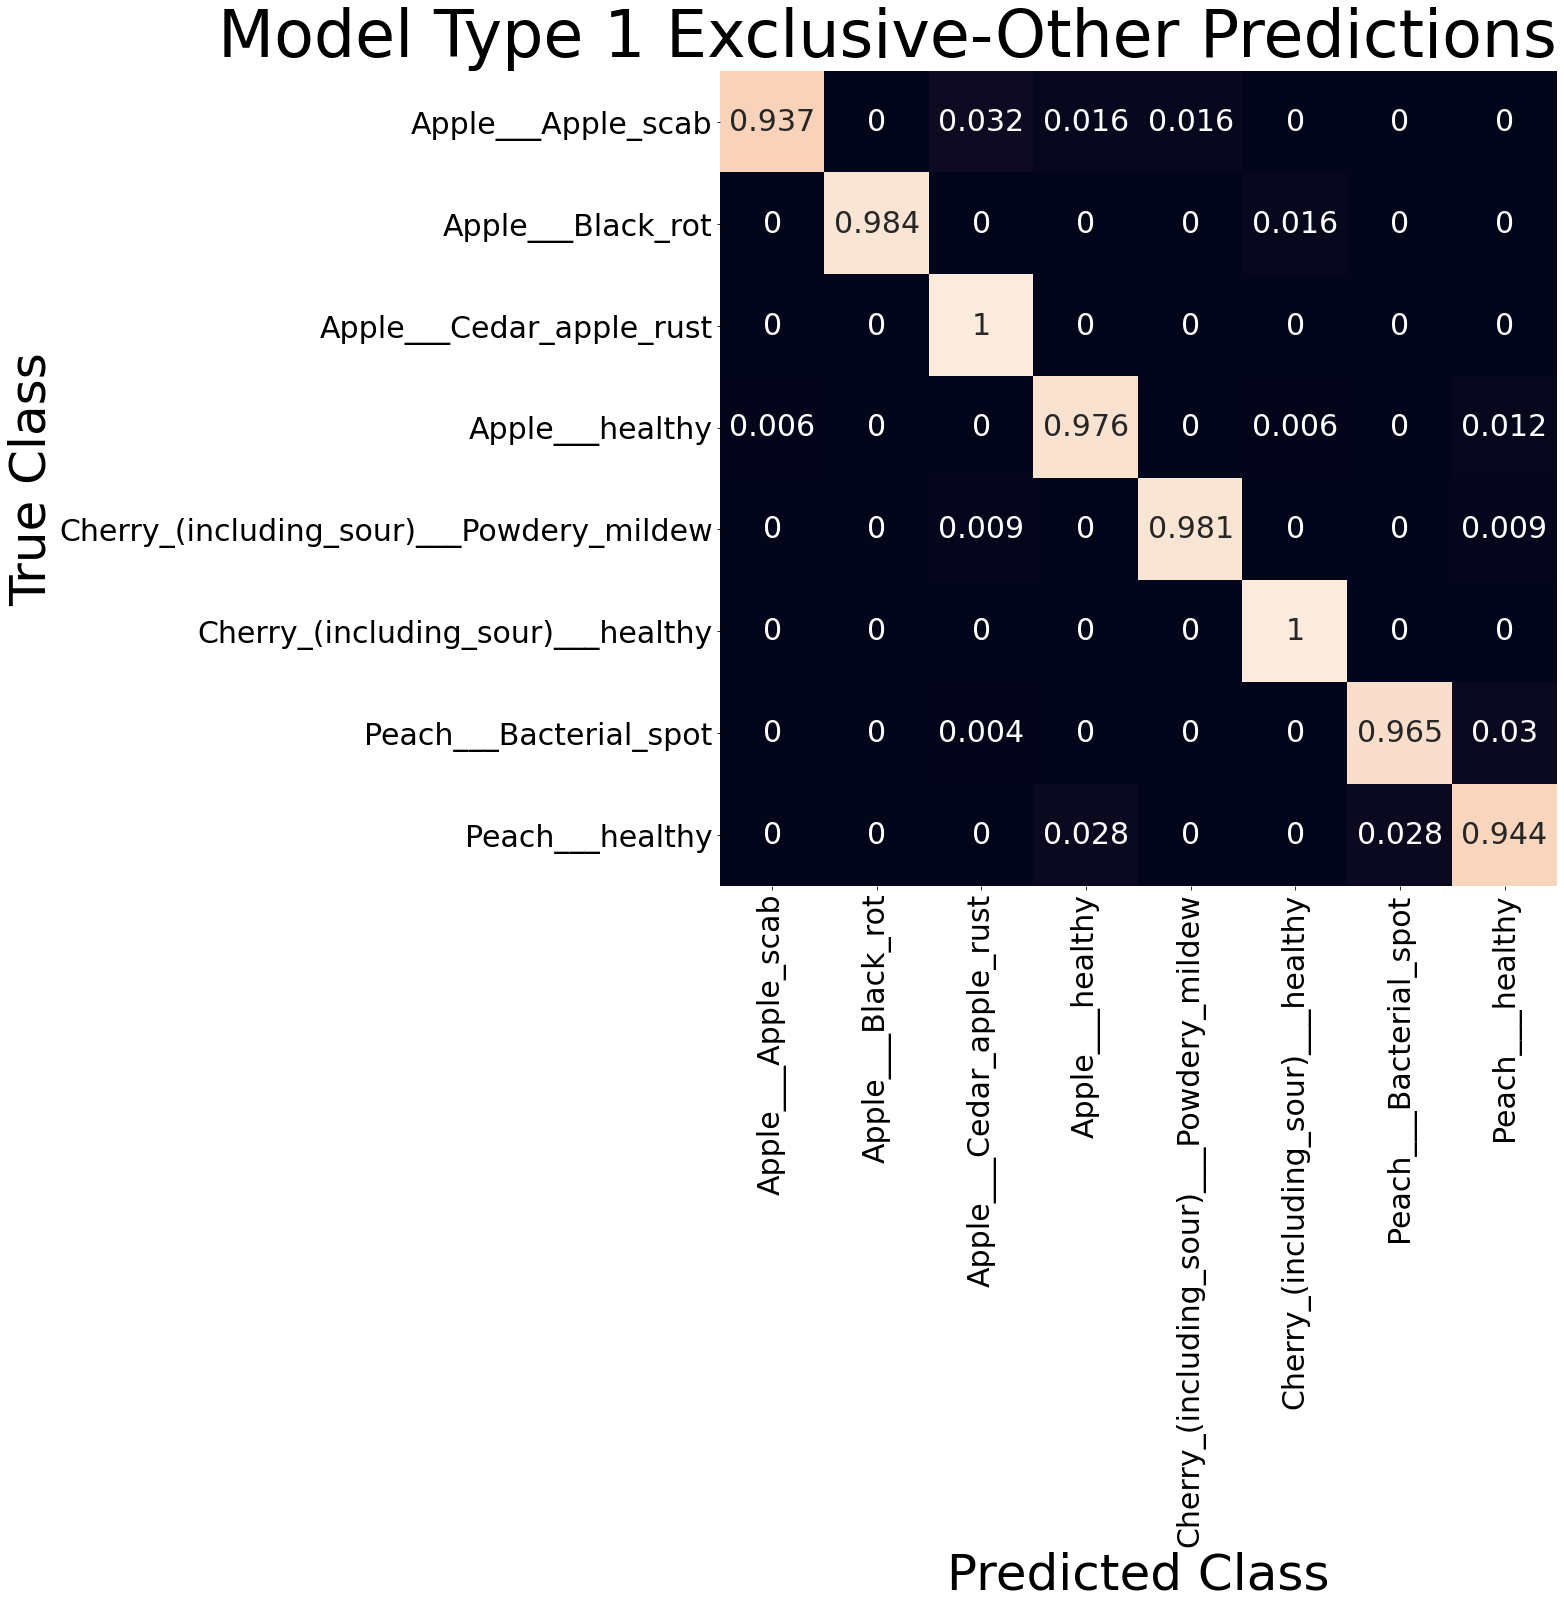

In [35]:
#some of the below plotting code taken from:
#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
target_names = testgen.class_indices.keys()
type1_noex_plotdf = pd.DataFrame(confusion_matrix(testgen.classes, y_pred),
                                 index = list(target_names),
                                 columns = list(target_names))

type1_noex_plotdf = type1_noex_plotdf.div(list(type1_noex_plotdf.sum(axis=1)), axis = 0)

plt.figure(figsize = (15,15))
ax = sns.heatmap(type1_noex_plotdf.round(3), annot=True, annot_kws={"size": 30}, fmt='g', cbar=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Predicted Class", fontsize = 50)
ax.set_ylabel("True Class", fontsize = 50)
ax.set_title('Model Type 1 Exclusive-Other Predictions', fontsize = 65, loc = 'right')
ax.tick_params(labelsize=30)

plt.savefig(r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Figures\type1_noex_cm.jpeg",
            bbox_inches = "tight") 

In [60]:
mod_paths = [r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleDiseaseOther1",
             r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryDiseaseOther1",
             r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachDiseaseOther1"]

test_path = r"C:\Datasets\Plant Village\ApplePeachCherryTest"

plants = ["Apple", "Cherry", "Peach"]

class_nums = [4,2,2]

predictions2 = model_type_1(mod_paths, test_path, plants, class_nums, eval_mode = False) 

########################
#Performance analytics

#There's probably an easier way to return true classe

test_path = r"C:\Datasets\Plant Village\ApplePeachCherryTest"

testdata = ImageDataGenerator(rescale=1./255)
testgen = testdata.flow_from_directory(
    directory = test_path,
    class_mode = "categorical",
    shuffle = False)

y_pred = predictions2["absolute_label"]


print('Confusion Matrix')
print(confusion_matrix(testgen.classes, y_pred))
print('Classification Report')
target_names = testgen.class_indices.keys()
print(classification_report(testgen.classes, y_pred, target_names=target_names))

#Gets a confidence interval
z = 1.96 # 95%
accuracy = accuracy_score(testgen.classes, y_pred)
conf = z * ((accuracy * (1 - accuracy)) / 777)**0.5
print("Accuracy: " + str(round(accuracy,3)))
print("95% CI: " + str(round(accuracy  - conf, 3)) + " - " + str(round(accuracy  + conf, 3)))


Found 777 files belonging to 8 classes.
98/98 [==============================] - 4s 32ms/step
Found 777 images belonging to 8 classes.
Confusion Matrix
[[ 60   0   1   0   1   0   1   0]
 [  0  62   0   0   0   1   0   0]
 [  0   0  28   0   0   0   0   0]
 [  2   0   0 161   0   1   0   1]
 [  2   0   0   0 104   0   0   0]
 [  0   0   0   0   0  86   0   0]
 [  1   0   0   0   0   0 221   8]
 [  0   1   0   1   0   0   1  33]]
Classification Report
                                          precision    recall  f1-score   support

                      Apple___Apple_scab       0.92      0.95      0.94        63
                       Apple___Black_rot       0.98      0.98      0.98        63
                Apple___Cedar_apple_rust       0.97      1.00      0.98        28
                         Apple___healthy       0.99      0.98      0.98       165
Cherry_(including_sour)___Powdery_mildew       0.99      0.98      0.99       106
       Cherry_(including_sour)___healthy       0.98 

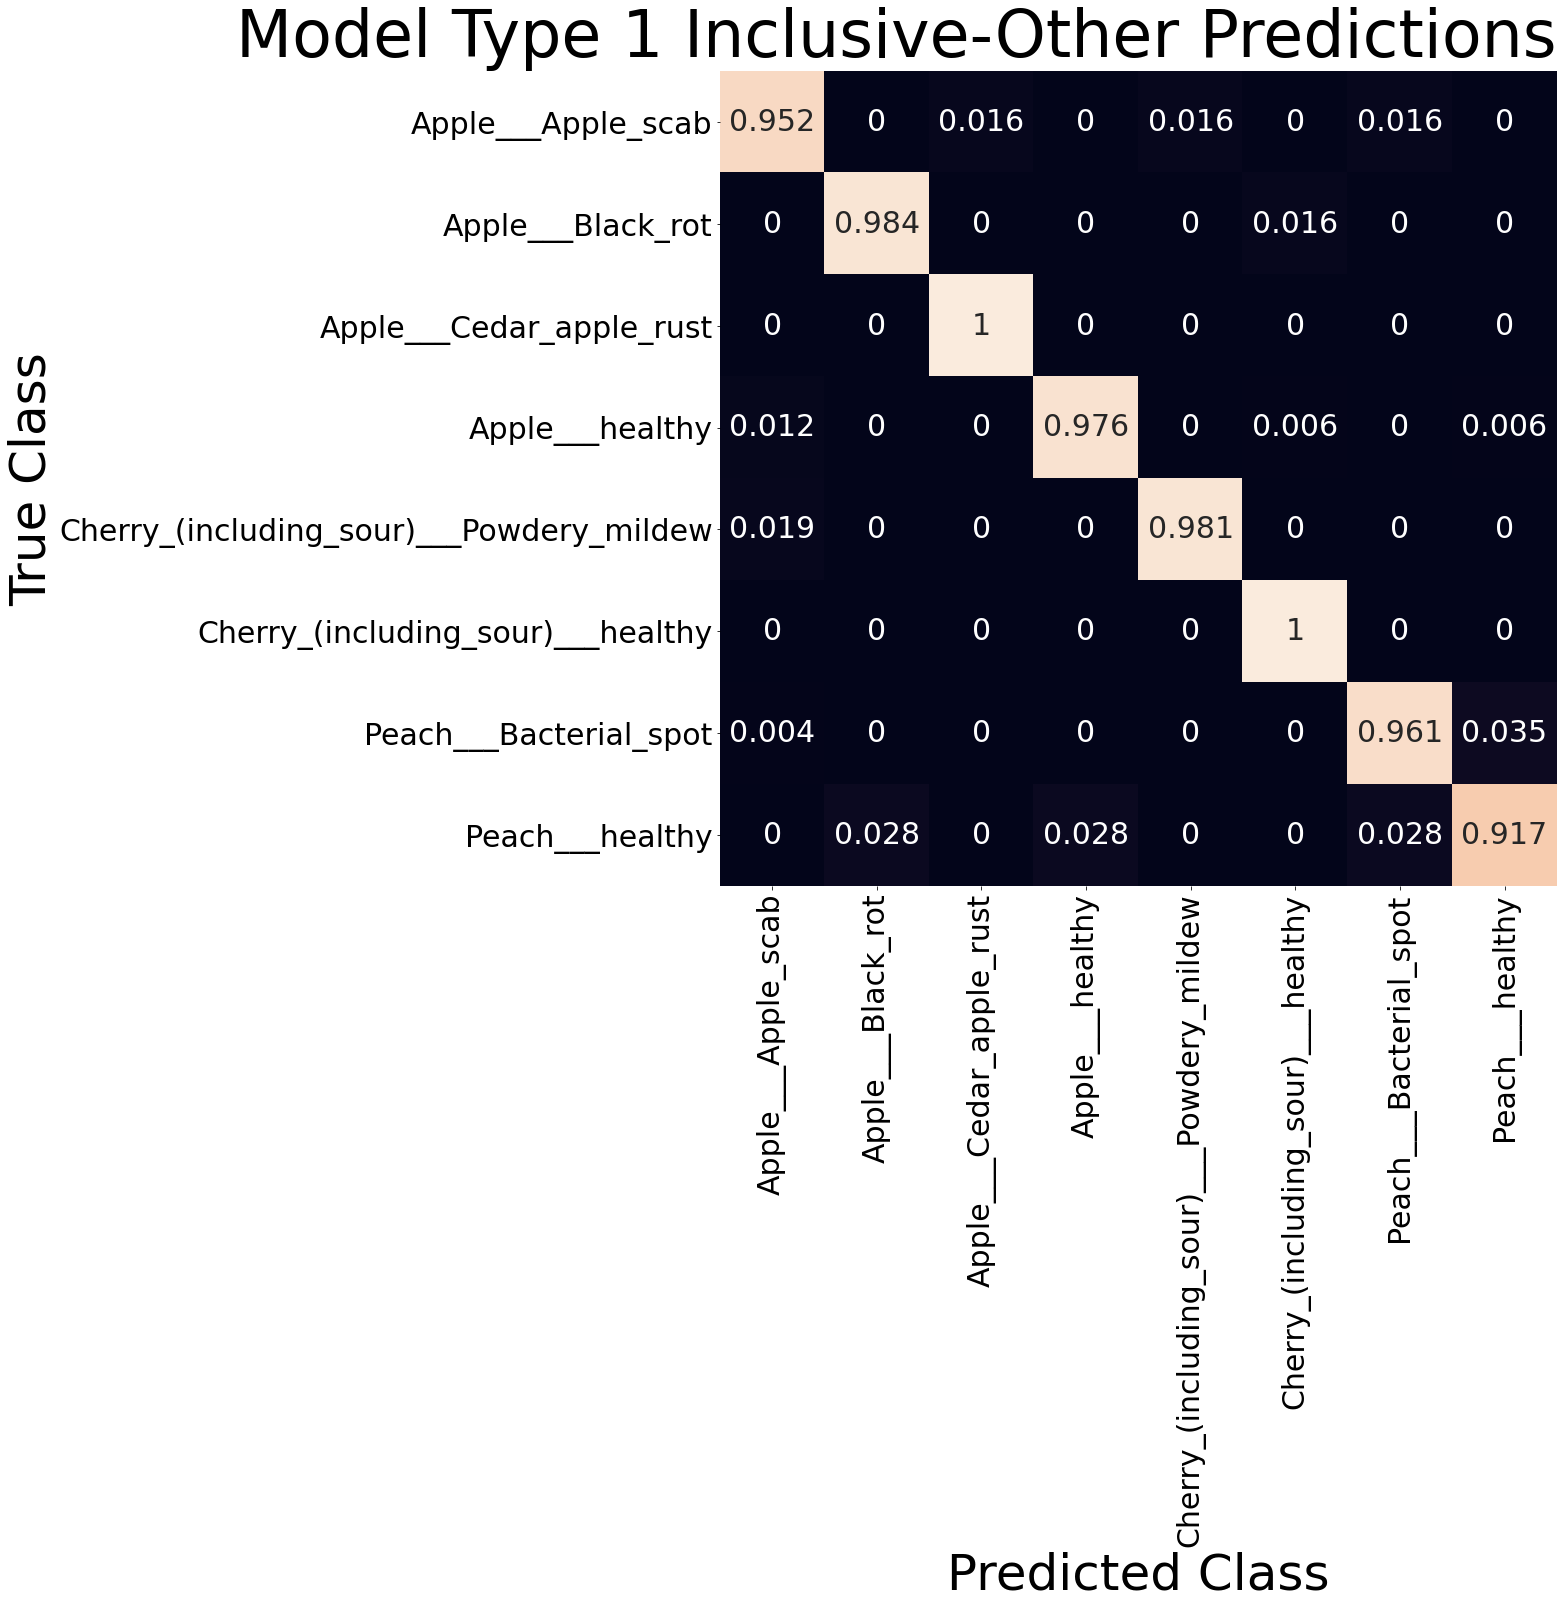

In [32]:
#some of the below plotting code taken from:
#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
target_names = testgen.class_indices.keys()
type1_plotdf = pd.DataFrame(confusion_matrix(testgen.classes, y_pred),
                                 index = list(target_names),
                                 columns = list(target_names))

type1_plotdf = type1_plotdf.div(list(type1_plotdf.sum(axis=1)), axis = 0)

plt.figure(figsize = (15,15))
ax = sns.heatmap(type1_plotdf.round(3), annot=True, annot_kws={"size": 30}, fmt='g', cbar=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Predicted Class", fontsize = 50)
ax.set_ylabel("True Class", fontsize = 50)
ax.set_title('Model Type 1 Inclusive-Other Predictions', fontsize = 65, loc = 'right')
ax.tick_params(labelsize=30)

plt.savefig(r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Figures\type1_cm.jpeg",
            bbox_inches = "tight")

In [23]:
#Evaluate


#####
#Paths, plants, and class nums need to be ordered the same as the test set classes are arranged in their directory (probbaly alphabetically)
#Otherwise we gotta change how the confusion matrix works
#####

#Specify layer 1 paths (need to keep same ordering throughout)

mod_paths_1 = [r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOther2',
               r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryOther1',
               r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachesOther1'
               ]

#Specify layer 2 paths
mod_paths_2 = [r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Apple1',
               r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Cherry_1_Model.h5',
               r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Peach_1_Model.h5'
               ]

#Need to provide plant type in the same order as the models
#Could probbaly make somthing to infer this automatically
plants = ["Apple", "Cherry", "Peach"]

#The dataset
test_path = r"C:\Datasets\Plant Village\ApplePeachCherryTest"

#The number of classes each layer 2 model can predict (dunno if there's any automatic way to get this info)
eval_class_nums = [4,2,2]

#Runs the models
prediction_aggregate = model_type_2(mod_paths_1, mod_paths_2, test_path, plants, eval_mode = False, eval_class_nums = eval_class_nums)

########################
#Performance analytics

#There's probably an easier way to return true classes
testdata = ImageDataGenerator(rescale=1./255)
testgen = testdata.flow_from_directory(
    directory = test_path,
    class_mode = "categorical",
    shuffle = False)

y_pred = prediction_aggregate["absolute"]


print('Confusion Matrix')
print(confusion_matrix(testgen.classes, y_pred))
print('Classification Report')
target_names = testgen.class_indices.keys()
print(classification_report(testgen.classes, y_pred, target_names=target_names))

#Gets a confidence interval
z = 1.96 # 95%
accuracy = accuracy_score(testgen.classes, y_pred)
conf = z * ((accuracy * (1 - accuracy)) / len(y_pred))**0.5
print("Accuracy: " + str(round(accuracy,3)))
print("95% CI: " + str(round(accuracy  - conf, 3)) + " - " + str(round(accuracy  + conf, 3)))


Found 777 files belonging to 8 classes.
98/98 [==============================] - 4s 32ms/step
Found 777 images belonging to 8 classes.
Confusion Matrix
[[ 57   0   1   0   3   1   1   0]
 [  0  58   0   1   0   4   0   0]
 [  0   0  28   0   0   0   0   0]
 [  1   0   0 163   0   0   0   1]
 [  0   0   1   1 103   0   0   1]
 [  0   0   0   0   0  85   1   0]
 [  1   0   1   0   0   0 225   3]
 [  0   0   0   2   0   0   0  34]]
Classification Report
                                          precision    recall  f1-score   support

                      Apple___Apple_scab       0.97      0.90      0.93        63
                       Apple___Black_rot       1.00      0.92      0.96        63
                Apple___Cedar_apple_rust       0.90      1.00      0.95        28
                         Apple___healthy       0.98      0.99      0.98       165
Cherry_(including_sour)___Powdery_mildew       0.97      0.97      0.97       106
       Cherry_(including_sour)___healthy       0.94 

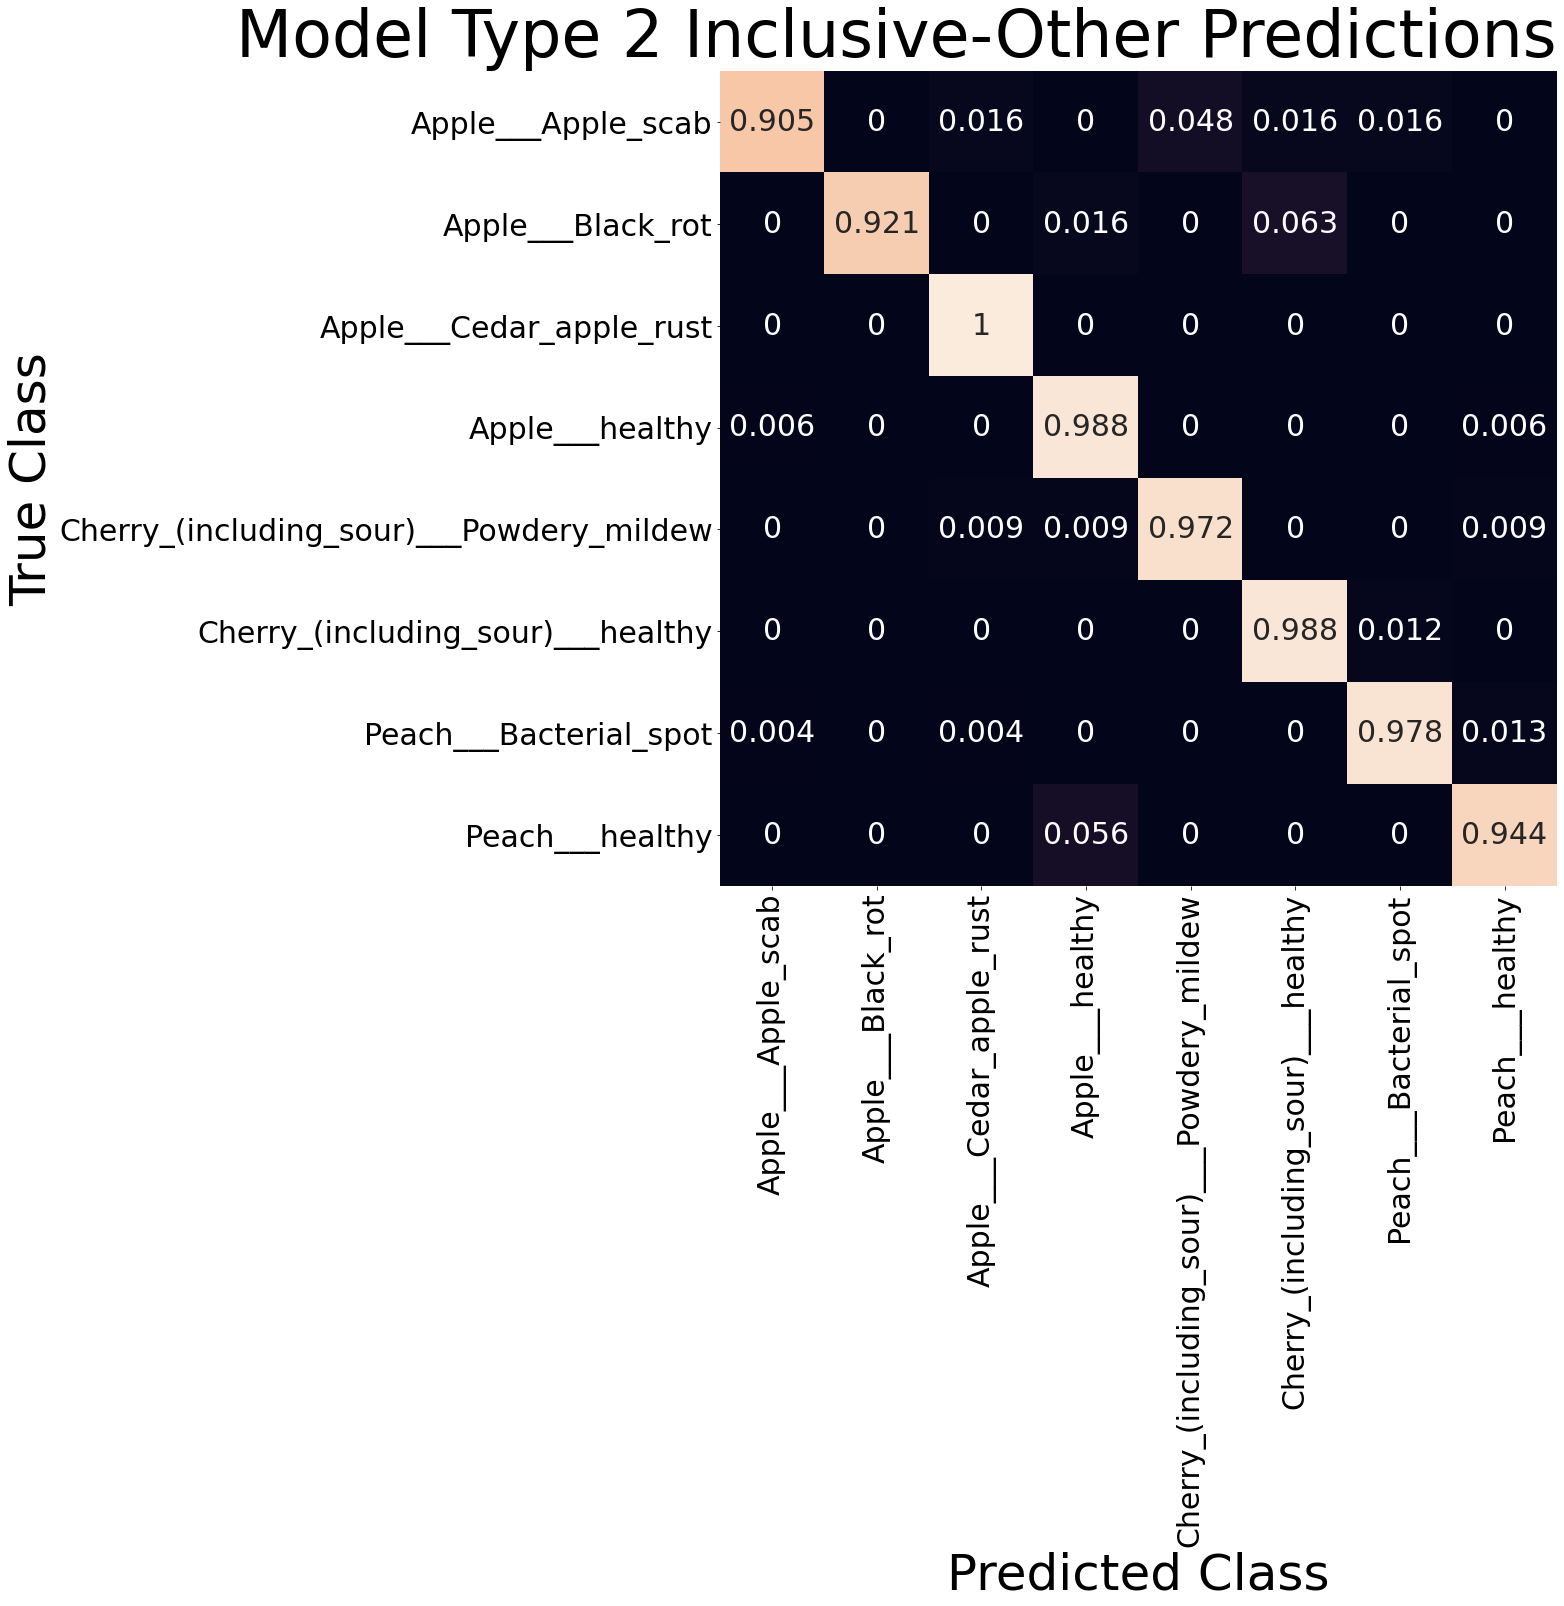

In [25]:
#some of the below plotting code taken from:
#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
target_names = testgen.class_indices.keys()
type2_plotdf = pd.DataFrame(confusion_matrix(testgen.classes, y_pred),
                                 index = list(target_names),
                                 columns = list(target_names))

type2_plotdf = type2_plotdf.div(list(type2_plotdf.sum(axis=1)), axis = 0)

plt.figure(figsize = (15,15))
ax = sns.heatmap(type2_plotdf.round(3), annot=True, annot_kws={"size": 30}, fmt='g', cbar=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Predicted Class", fontsize = 50)
ax.set_ylabel("True Class", fontsize = 50)
ax.set_title('Model Type 2 Inclusive-Other Predictions', fontsize = 65, loc = 'right')
ax.tick_params(labelsize=30)

plt.savefig(r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Figures\type2_cm.jpeg",
            bbox_inches = "tight")

In [26]:
#Evaluate


#####
#Paths, plants, and class nums need to be ordered the same as the test set classes are arranged in their directory (probbaly alphabetically)
#Otherwise we gotta change how the confusion matrix works
#####

#Specify layer 1 paths (need to keep same ordering throughout)

mod_paths_1 = [r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOtherNoex1',
               r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryOtherNoex1',
               r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachOtherNoex1'
               ]

#Specify layer 2 paths
mod_paths_2 = [r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Apple1',
               r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Cherry_1_Model.h5',
               r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Peach_1_Model.h5'
               ]

#Need to provide plant type in the same order as the models
#Could probbaly make somthing to infer this automatically
plants = ["Apple", "Cherry", "Peach"]

#The dataset
test_path = r"C:\Datasets\Plant Village\ApplePeachCherryTest"

#The number of classes each layer 2 model can predict (dunno if there's any automatic way to get this info)
eval_class_nums = [4,2,2]

#Runs the models
prediction_aggregate = model_type_2(mod_paths_1, mod_paths_2, test_path, plants, eval_mode = False, eval_class_nums = eval_class_nums)

########################
#Performance analytics

#There's probably an easier way to return true classes
testdata = ImageDataGenerator(rescale=1./255)
testgen = testdata.flow_from_directory(
    directory = test_path,
    class_mode = "categorical",
    shuffle = False)

y_pred = prediction_aggregate["absolute"]


print('Confusion Matrix')
print(confusion_matrix(testgen.classes, y_pred))
print('Classification Report')
target_names = testgen.class_indices.keys()
print(classification_report(testgen.classes, y_pred, target_names=target_names))

#Gets a confidence interval
z = 1.96 # 95%
accuracy = accuracy_score(testgen.classes, y_pred)
conf = z * ((accuracy * (1 - accuracy)) / len(y_pred))**0.5
print("Accuracy: " + str(round(accuracy,3)))
print("95% CI: " + str(round(accuracy  - conf, 3)) + " - " + str(round(accuracy  + conf, 3)))


Found 777 files belonging to 8 classes.
98/98 [==============================] - 4s 31ms/step
Found 777 images belonging to 8 classes.
Confusion Matrix
[[ 60   0   1   0   2   0   0   0]
 [  0  61   0   1   0   1   0   0]
 [  0   0  28   0   0   0   0   0]
 [  1   0   0 162   0   2   0   0]
 [  0   1   2   1 101   0   0   1]
 [  0   1   0   0   0  85   0   0]
 [  0   0   1   0   0   0 226   3]
 [  0   0   0   2   0   0   0  34]]
Classification Report
                                          precision    recall  f1-score   support

                      Apple___Apple_scab       0.98      0.95      0.97        63
                       Apple___Black_rot       0.97      0.97      0.97        63
                Apple___Cedar_apple_rust       0.88      1.00      0.93        28
                         Apple___healthy       0.98      0.98      0.98       165
Cherry_(including_sour)___Powdery_mildew       0.98      0.95      0.97       106
       Cherry_(including_sour)___healthy       0.97 

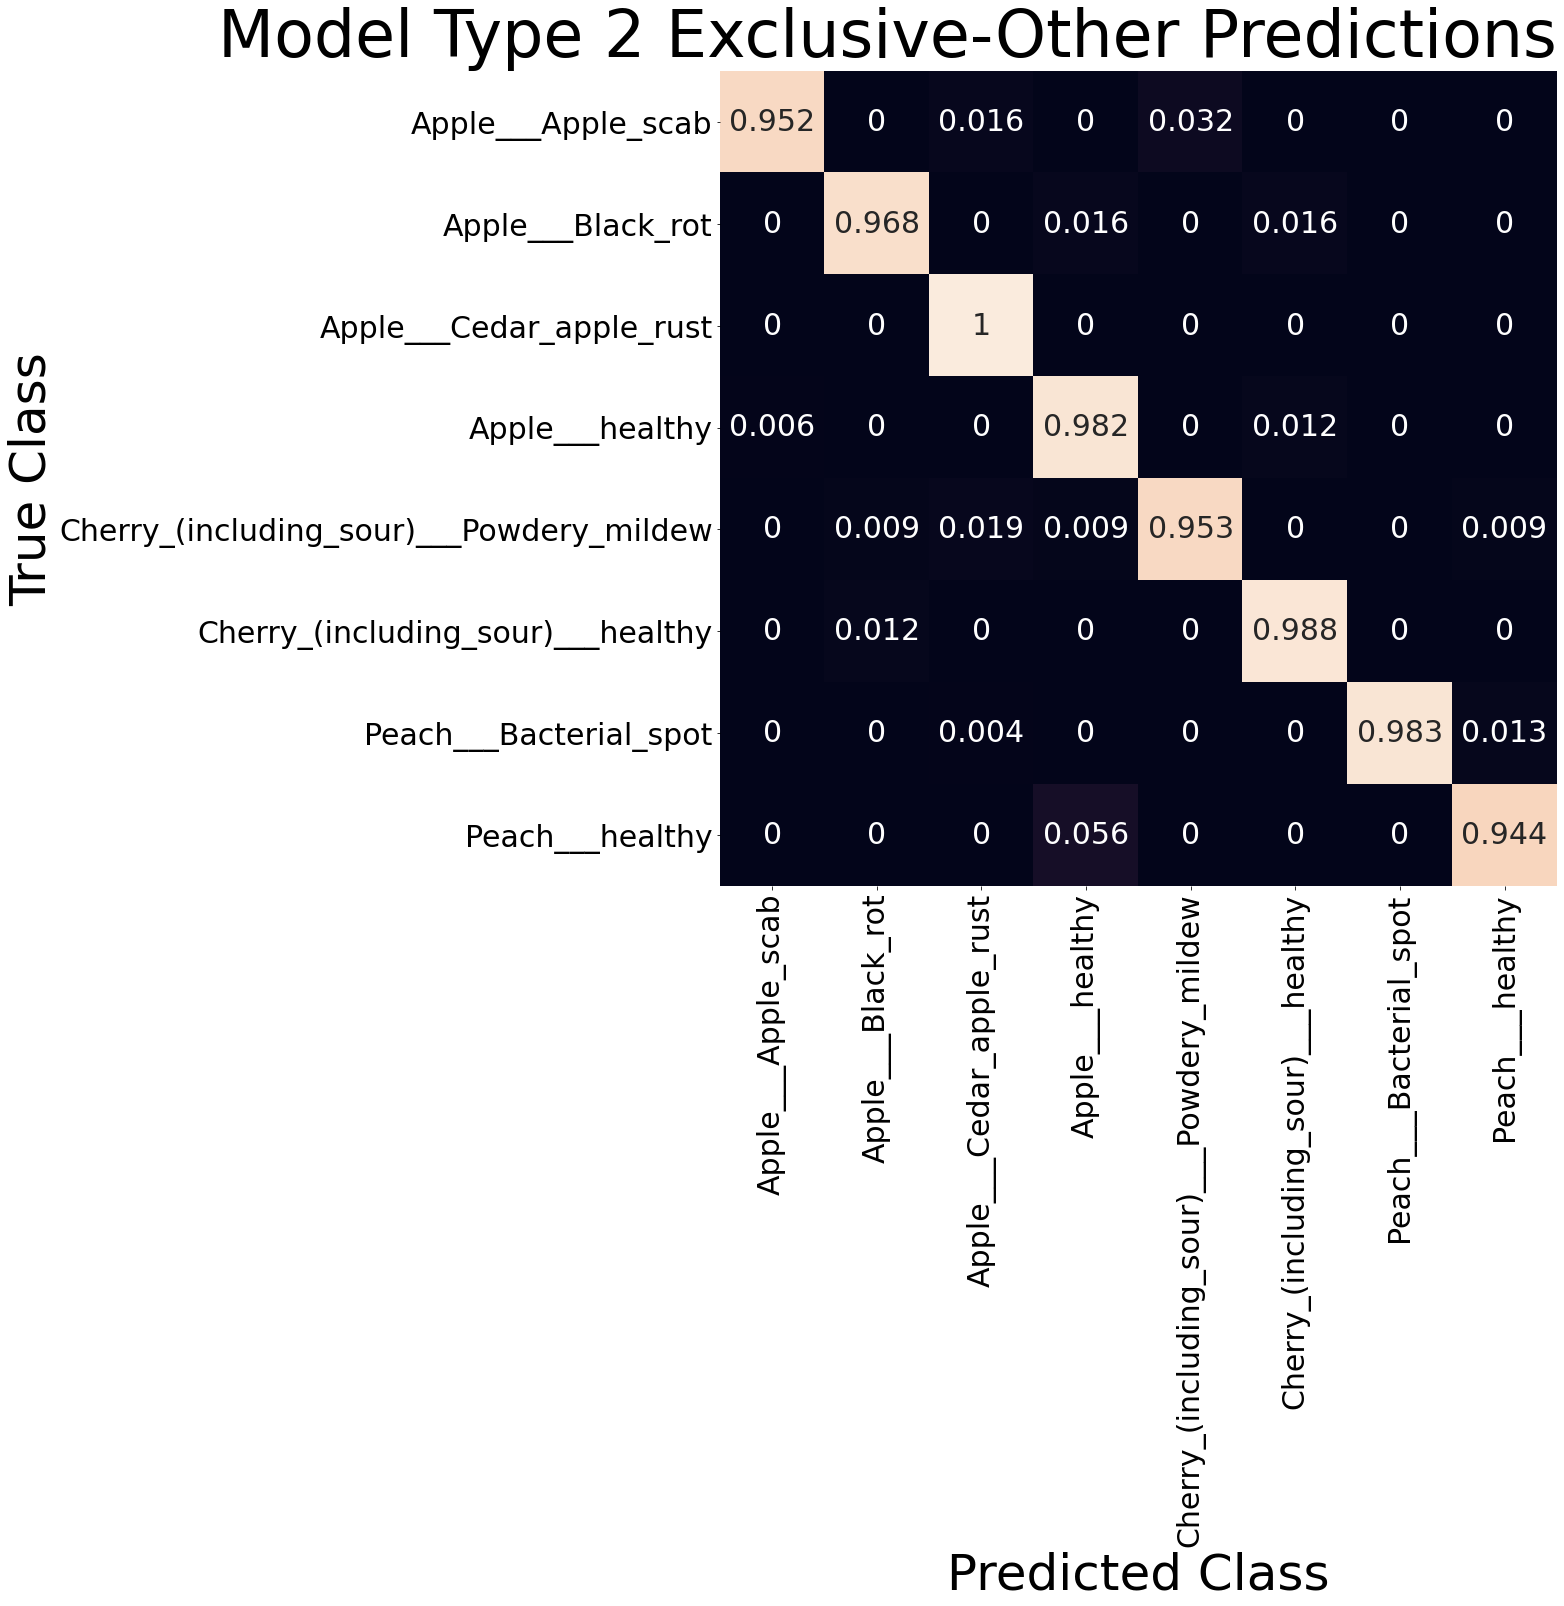

In [27]:
#some of the below plotting code taken from:
#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
target_names = testgen.class_indices.keys()
type2_plotnoexdf = pd.DataFrame(confusion_matrix(testgen.classes, y_pred),
                                 index = list(target_names),
                                 columns = list(target_names))

type2_plotnoexdf = type2_plotnoexdf.div(list(type2_plotnoexdf.sum(axis=1)), axis = 0)

plt.figure(figsize = (15,15))
ax = sns.heatmap(type2_plotnoexdf.round(3), annot=True, annot_kws={"size": 30}, fmt='g', cbar=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Predicted Class", fontsize = 50)
ax.set_ylabel("True Class", fontsize = 50)
ax.set_title('Model Type 2 Exclusive-Other Predictions', fontsize = 65, loc = 'right')
ax.tick_params(labelsize=30)

plt.savefig(r"C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Figures\type2_noex_cm.jpeg",
            bbox_inches = "tight")

In [41]:
# FOR TESTING INCREMENTALLY


#####
#Paths, plants, and class nums need to be ordered the same as the test set classes are arranged in their directory (probbaly alphabetically)
#Otherwise we gotta change how the confusion matrix works
#####

#Specify layer 1 paths (need to keep same ordering throughout)

mod_paths_1 = [r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\AppleOtherNoex1',
               r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\CherryOtherNoex1',
               r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\PeachOtherNoex1'
               ]

#Specify layer 2 paths
mod_paths_2 = [r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Model_Checkpoints\Apple1',
               r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Cherry_1_Model.h5',
               r'C:\Users\blume\OneDrive\Desktop\CUNY MSDS\Data 698 Masters Thesis\Python\Peach_1_Model.h5'
               ]


#Need to provide plant type in the same order as the models
#Could probbaly make somthing to infer this automatically
plants = ["Apple", "Cherry", "Peach"]

#The dataset
test_path = r"C:\Datasets\Plant Village\Peach\test"

#The number of classes each layer 2 model can predict (dunno if there's any automatic way to get this info)
eval_class_nums = [4,2,2]

#Runs the models
prediction_aggregate = model_type_2(mod_paths_1, mod_paths_2, test_path, plants, eval_mode = False, eval_class_nums = eval_class_nums)

########################
#Performance analytics

#There's probably an easier way to return true classes
testdata = ImageDataGenerator(rescale=1./255)
testgen = testdata.flow_from_directory(
    directory = test_path,
    class_mode = "categorical",
    shuffle = False)

y_pred = prediction_aggregate["absolute"]


print('Confusion Matrix')
print(confusion_matrix(testgen.classes, y_pred))
print('Classification Report')
target_names = testgen.class_indices.keys()
#print(classification_report(testgen.classes, y_pred, target_names=target_names))

#Gets a confidence interval
z = 1.96 # 95%
accuracy = accuracy_score(testgen.classes, y_pred)
conf = z * ((accuracy * (1 - accuracy)) / len(y_pred))**0.5
print("Accuracy: " + str(round(accuracy,3)))
print("95% CI: " + str(round(accuracy  - conf, 3)) + " - " + str(round(accuracy  + conf, 3)))


Found 266 files belonging to 8 classes.
34/34 [==============================] - 2s 32ms/step
Found 266 images belonging to 8 classes.
Confusion Matrix
[[  0   0   0   0]
 [  0   0   0   0]
 [  1   0 226   3]
 [  0   2   0  34]]
Classification Report
Accuracy: 0.977
95% CI: 0.96 - 0.995


In [42]:
np.array(y_pred)

array([7., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 7., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 2., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 7.,
       6., 6., 6., 6., 6.

## Notes on Noex performance

type 1 Noex models actually perform comprably to models with examples of non target plants from other models in the 'others' categories, but only when used in conjunction.  Noex models by themselves seem to have more trouble distinguishing between their target plant and other plants, although there is a bit of variability here (e.g. Cherry Noex models are better at correctly caregorizing peaches as offtarget than Apple noex Models are.).  Multiple Noex models sued in conjunction however, are able to compensate for eachother weaknesses in detecting off-target classes.  It seems that Noex models can typically identify their on-target plants with enough additional certainty to offset misclassifications from the other Noex models.  

Noex is worse at detecting when an image is off task, but better at detecting when its on task

My hypothesis is kinda backwards.  Not havign prior examples means generalizing worse when .